In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

load_dotenv()

True

Removendo warnings

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import numpy as np
import pandas as pd

# Opção 1: ignorar todos os warnings (global)
warnings.filterwarnings("ignore")

# Opção 2: ignorar apenas categorias específicas (recomendado)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Pandas: desativar aviso de SettingWithCopy (use com cuidado)
pd.options.mode.chained_assignment = None

# NumPy: ignorar avisos numéricos (overflow/underflow etc.)
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Importando os dados

Dados previamente tratados.
Foram importados 48 índices

In [136]:
# Carregar variáveis de ambiente
load_dotenv()

path_dados_tratados = os.getenv('PATH_DADOS_TRATADOS')

dados_indicadores = pd.read_csv(path_dados_tratados + "dados_indicadores_tratados.csv")
dados_indices = pd.read_csv(path_dados_tratados + "dados_indices.csv", sep=';')
dados_indices.drop(columns=['Unnamed: 0'], inplace=True)
dados_indices.drop(columns=['incc'], inplace=True)
preco_acoes = pd.read_csv(path_dados_tratados + 'preco_acoes.csv')
preco_acoes = preco_acoes.iloc[:-1, :]

In [4]:
dados_indices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 47 columns):
 #   Column                                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                                      --------------  -----  
 0   data                                                                                                                        59 non-null     object 
 1   ibov                                                                                                                        59 non-null     float64
 2   iee                                                                                                                         59 non-null     float64
 3   selic                                                                                                                       59 

Renomear colunas

In [141]:
rename_map = {
    "IPAOG-DI Ipa - todos os itens - Nro. Índice(1477007)": "IPAOG-DI",
    "INCC-Brasil-DI-Todos os itens(1464783)": "INCC-Brasil-DI",
    "Indicador de Incerteza da Economia Brasil (IIE-Br)(1428452)": "IIE-Br",
    "Indicador de Incerteza da Economia Brasil - Componente Mídia (Mídia - IIE-Br)(1463188)": "Mídia - IIE-Br",
    "Indicador de Incerteza da Economia Brasil - Componente Expactativas (Expec IIE-Br)(1463189)": "Expec IIE-Br",
    "Indicador Antecedente de Emprego (IA Emp) com ajuste sazonal(1416205)": "IA Emp",
    "Indicador Antecedente de Emprego (IA Emp) com ajuste sazonal(1416205) (Variação Percentual em Relação ao Período Anterior)": "Var. IA Emp",
    "PIB a preços de 1995(1428699)": "PIB 1995",
    "PIB a preços correntes(1428698)": "PIB Corrente",
    "Índice de volume mensal  - PIB a preços de mercado (1428676)": "Vol. PIB Mensal",
    "Índice de volume mensal pela ótica da produção - Valor adicionado a preços básicos(1428677)": "Vol. VA Produção",
    "Índice de volume mensal pela ótica da produção - Valor adicionado a preços básicos - Agropecuária(1428678)": "Vol. VA Agro",
    "Índice de volume mensal pela ótica da produção - Valor adicionado a preços básicos - Indústria(1428679)": "Vol. VA Indústria",
    "Índice de volume mensal pela ótica da produção - Valor adicionado a preços básicos - Serviços(1428680)": "Vol. VA Serviços",
    "Índice de volume mensal pela ótica da produção - Impostos (1428681)": "Vol. Impostos",
    "Índice de volume mensal com ajuste sazonal - PIB a preços de mercado (1428682)": "Vol. PIB Sazonal",
    "Índice de volume mensal pela ótica da produção com ajuste sazonal -Valor adicionado (1428683)": "Vol. VA Sazonal",
    "Índice de volume mensal pela ótica da produção com ajuste sazonal - Valor adicionado - Agropecuária(1428684)": "Vol. VA Agro Sazonal",
    "Índice de volume mensal pela ótica da produção com ajuste sazonal - Valor adicionado - Indústria(1428685)": "Vol. VA Ind. Sazonal",
    "Índice de volume mensal pela ótica da produção com ajuste sazonal - Valor adicionado - Serviços(1428686)": "Vol. VA Serv. Sazonal",
    "Índice de volume trimestral com ajuste sazonal - PIB(1428700)": "Vol. PIB Trim. Saz.",
    "Índice de volume trimestral com ajuste sazonal - Valor Adicionado(1428701)": "Vol. VA Trim. Saz.",
    "Índice de volume trimestral com ajuste sazonal - Valor Adicionado - Agropecuária(1428702)": "Vol. VA Agro Trim. Saz.",
    "Índice de volume trimestral com ajuste sazonal - Valor Adicionado - Indústria(1428703)": "Vol. VA Ind. Trim. Saz.",
    "Índice de volume trimestral com ajuste sazonal - Valor Adicionado - Serviços(1428704)": "Vol. VA Serv. Trim. Saz.",
    "Índice da Taxa de Câmbio Real - (Real / Dólar (EUA))(1003592)": "Câmbio Real/Dólar",
    "Índice da Taxa de Câmbio Real - (Real / Iene (Japão))(1003593)": "Câmbio Real/Iene",
    "Índice da Taxa de Câmbio Real - (Real / Peso (Argentina))(1003594)": "Câmbio Real/Peso",
    "Índice da Taxa de Câmbio Real - (Real / Euro (Zona do Euro))(1003595)": "Câmbio Real/Euro",
    "Índice da Taxa de Câmbio Real - (Real / Libra (Reino Unido))(1003596)": "Câmbio Real/Libra",
    "Índice da Taxa de Câmbio Efetiva Real - (Real / Cesta de Moedas)(1003597)": "Câmbio Efetiva Real",
    "Juros EUA": "Juros EUA",
    "Tbonds": "T-bonds",
    "Cotacao dolar": "Cotação Dólar",
    "CDI": "CDI",
    "TJLP": "TJLP",
    "Energia res": "Energia Res.",
    "Energia ind": "Energia Ind.",
    "Energia comer": "Energia Com.",
    "Divida/PIB": "Dívida/PIB",
}

if 'dados_indices' in globals():
    dados_indices.rename(columns=rename_map, inplace=True)

# Opcional: verificar quais colunas foram renomeadas em cada DF
for name, df in [('dados_indicadores', globals().get('dados_indicadores')),
                 ('dados_indices', globals().get('dados_indices'))]:
    if df is not None:
        renomeadas = [v for k, v in rename_map.items() if k in df.columns]
        print(f"{name}: {len(renomeadas)} colunas renomeadas.")
# ...existing code...

dados_indicadores: 0 colunas renomeadas.
dados_indices: 3 colunas renomeadas.


In [142]:
dados_indices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   data                      59 non-null     object 
 1   ibov                      59 non-null     float64
 2   iee                       59 non-null     float64
 3   selic                     59 non-null     float64
 4   vix                       59 non-null     float64
 5   igpm                      59 non-null     float64
 6   ipca                      59 non-null     float64
 7   IPAOG-DI                  59 non-null     float64
 8   INCC-Brasil-DI            59 non-null     float64
 9   IIE-Br                    59 non-null     float64
 10  Mídia - IIE-Br            59 non-null     float64
 11  Expec IIE-Br              59 non-null     float64
 12  IA Emp                    59 non-null     float64
 13  Var. IA Emp               59 non-null     float64
 14  PIB 1995    

Como o foco deste estudo são as companhias de transmissão de energia elétrica, as seguintes empresas serão consideradas:
* ELET6 - CD_CVM = 2437
* ISAE4 - CD_CVM = 18376
* TAEE4 - CD_CVM = 20257
* ALUP4 - CD_CVM = 21490

In [7]:
# Filtrar dataframe para possuir apenas os códigos 2437, 18376, 20257, 21490
dados_indicadores_transm = dados_indicadores[dados_indicadores['CD_CVM'].isin([2437, 18376, 20257, 21490])]
dados_indicadores_transm.query("CD_CVM == 21490").head()

CD_CVM                DENOM_CIA DT_FIM_EXERC         3.01         3.02  \
14297   21490  ALUPAR INVESTIMENTO S/A   2010-03-31  282083000.0 -109982000.0   
14298   21490  ALUPAR INVESTIMENTO S/A   2010-09-30  268152000.0  -91704000.0   
14299   21490  ALUPAR INVESTIMENTO S/A   2010-12-31  385496000.0  -42203000.0   
14300   21490  ALUPAR INVESTIMENTO S/A   2011-03-31  293389000.0  -94234000.0   
14301   21490  ALUPAR INVESTIMENTO S/A   2011-09-30  322241000.0 -104842000.0   

              3.03        3.04         3.05        3.06         3.07  \
14297  172101000.0 -14640000.0  157461000.0 -29583000.0  127878000.0   
14298  176448000.0  -5616000.0  170832000.0 -27612000.0  143220000.0   
14299  343293000.0 -17188000.0  326105000.0 -76033000.0  250072000.0   
14300  199155000.0 -11628000.0  187527000.0 -34444000.0  153083000.0   
14301  217399000.0 -22989000.0  194410000.0 -54647000.0  139763000.0   

             3.08         3.09         3.11  
14297 -20418000.0  107460000.0  107460000.0  
14298 -22458000.0  120762000.0  120762000.0  
14299 -56868000.0  193204000.0  193204000.0  
14300 -19058000.0  134025000.0  134025000.0  
14301 -24607000.0  115156000.0  115156000.0

Interpolando valores ausentes

In [8]:
novas_linhas = pd.DataFrame({
    'CD_CVM': [21490, 21490],
    'DENOM_CIA' : ['ALUPAR INVESTIMENTO S/A', 'ALUPAR INVESTIMENTO S/A'],
    'DT_FIM_EXERC': ['2010-06-30', '2011-06-30'],
    '3.01': [np.nan, np.nan],
    '3.02': [np.nan, np.nan],
    '3.03': [np.nan, np.nan],
    '3.04': [np.nan, np.nan],
    '3.05': [np.nan, np.nan],
    '3.06': [np.nan, np.nan],
    '3.07': [np.nan, np.nan],
    '3.08': [np.nan, np.nan],
    '3.09': [np.nan, np.nan],
    '3.11': [np.nan, np.nan]
})

In [9]:
dados_indicadores_transm = pd.concat([dados_indicadores_transm, novas_linhas], ignore_index=True)

In [10]:
#interpolar os valores nulos
dados_indicadores_transm = dados_indicadores_transm.sort_values(by=['CD_CVM', 'DT_FIM_EXERC'])
dados_indicadores_transm = dados_indicadores_transm.interpolate(method='linear', limit_direction='both')

Organiza indicadores

In [11]:
dict_indicadores = {}
for cd_cvm in dados_indicadores_transm['CD_CVM'].unique():
    df_temp = dados_indicadores_transm.copy()
    df_temp = df_temp[df_temp['CD_CVM'] == cd_cvm].copy()
    
    df_temp.drop(columns=['CD_CVM','DENOM_CIA'], inplace=True)
    df_temp.set_index('DT_FIM_EXERC', inplace=True)
    dict_indicadores[cd_cvm] = df_temp



Tornando variáveis exógenas estacionárias

In [12]:
def tornar_estacionaria(serie, max_diff=5, verbose=False):
    """
    Aplica diferenciações sucessivas até a série temporal ficar estacionária (ADF p < 0.05).
    Retorna a série estacionária e o número de diferenciações aplicadas.
    """
    serie_estac = serie.copy()
    diff_count = 0
    for _ in range(max_diff + 1):
        adf_result = adfuller(serie_estac.dropna())
        p_value = adf_result[1]
        if verbose:
            print(f"Differencing: {diff_count}, p-value: {p_value:.4f}")
        if p_value < 0.05:
            return serie_estac, diff_count
        serie_estac = serie_estac.diff().dropna()
        diff_count += 1
    if verbose:
        print("Atenção: não ficou estacionária após", max_diff, "diferenciações.")
    return serie_estac, diff_count

In [13]:
indices_estac = dados_indices.copy()
for column in dados_indices.columns:
    if column != 'data':
        indices_estac[column], diffs = tornar_estacionaria(dados_indices[column], verbose=False)
        print(f"Série '{column}' tornou-se estacionária após {diffs} diferenciações.")
indices_estac.set_index(dados_indices['data'], inplace=True)
indices_estac = indices_estac.iloc[1:, :]

Série 'ibov' tornou-se estacionária após 1 diferenciações.
Série 'iee' tornou-se estacionária após 1 diferenciações.
Série 'selic' tornou-se estacionária após 1 diferenciações.
Série 'vix' tornou-se estacionária após 0 diferenciações.
Série 'igpm' tornou-se estacionária após 0 diferenciações.
Série 'ipca' tornou-se estacionária após 0 diferenciações.
Série 'IPAOG-DI' tornou-se estacionária após 1 diferenciações.
Série 'INCC-Brasil-DI' tornou-se estacionária após 2 diferenciações.
Série 'IIE-Br' tornou-se estacionária após 1 diferenciações.
Série 'Mídia - IIE-Br' tornou-se estacionária após 0 diferenciações.
Série 'Expec IIE-Br' tornou-se estacionária após 0 diferenciações.
Série 'IA Emp' tornou-se estacionária após 0 diferenciações.
Série 'Var. IA Emp' tornou-se estacionária após 0 diferenciações.
Série 'PIB 1995' tornou-se estacionária após 1 diferenciações.
Série 'PIB Corrente' tornou-se estacionária após 2 diferenciações.
Série 'Vol. PIB Mensal' tornou-se estacionária após 1 diferen

In [144]:
indices_estac['INCC-Brasil-DI']

data
2010-06-30          NaN
2010-09-30    -1.929333
2010-12-31    -4.689667
2011-03-31     2.121667
2011-06-30    10.380000
2011-09-30    -7.777000
2011-12-31    -4.275333
2012-03-31     3.422333
2012-06-30     5.689333
2012-09-30    -3.065333
2012-12-31    -6.561667
2013-03-31     3.774333
2013-06-30     9.361000
2013-09-30    -4.043667
2013-12-31    -7.667667
2014-03-31     2.582000
2014-06-30     8.212333
2014-09-30    -4.352333
2014-12-31    -7.857667
2015-03-31     5.531667
2015-06-30     4.434333
2015-09-30     2.335000
2015-12-31    -9.871000
2016-03-31     1.270667
2016-06-30     4.754667
2016-09-30     1.942000
2016-12-31    -8.965333
2017-03-31     2.962000
2017-06-30    -0.948667
2017-09-30     2.625000
2017-12-31    -4.826333
2018-03-31    -0.489000
2018-06-30     2.520667
2018-09-30     4.047667
2018-12-31    -6.003667
2019-03-31     0.807333
2019-06-30     1.149000
2019-09-30     5.262333
2019-12-31    -6.678333
2020-03-31     0.868000
2020-06-30    -0.603333
2020-09-30 

In [14]:
indicadores_estac = {}
for cd_cvm, df in dict_indicadores.items():
    indicadores_estac[cd_cvm] = pd.DataFrame()
    for column in df.columns:
        indicadores_estac[cd_cvm][column], diffs = tornar_estacionaria(df[column], verbose=True)
        print(f"CD_CVM {cd_cvm} - Série '{column}' tornou-se estacionária após {diffs} diferenciações.")
    print(len(indicadores_estac[cd_cvm]))

    # Devido ao processo de diferenciação algumas séries podem ter perdido uma ou mais linhas no início
    if len(indicadores_estac[cd_cvm]) == 58:
        indicadores_estac[cd_cvm].set_index(df.index[1:], inplace=True)
    else:
        indicadores_estac[cd_cvm] = indicadores_estac[cd_cvm].iloc[1:, :]
        indicadores_estac[cd_cvm].set_index(df.index[1:], inplace=True)

Differencing: 0, p-value: 0.0000
CD_CVM 2437 - Série '3.01' tornou-se estacionária após 0 diferenciações.
Differencing: 0, p-value: 0.0002
CD_CVM 2437 - Série '3.02' tornou-se estacionária após 0 diferenciações.
Differencing: 0, p-value: 0.0000
CD_CVM 2437 - Série '3.03' tornou-se estacionária após 0 diferenciações.
Differencing: 0, p-value: 0.0000
CD_CVM 2437 - Série '3.04' tornou-se estacionária após 0 diferenciações.
Differencing: 0, p-value: 0.0000
CD_CVM 2437 - Série '3.05' tornou-se estacionária após 0 diferenciações.
Differencing: 0, p-value: 0.3244
Differencing: 1, p-value: 0.0000
CD_CVM 2437 - Série '3.06' tornou-se estacionária após 1 diferenciações.
Differencing: 0, p-value: 0.0000
CD_CVM 2437 - Série '3.07' tornou-se estacionária após 0 diferenciações.
Differencing: 0, p-value: 0.0000
CD_CVM 2437 - Série '3.08' tornou-se estacionária após 0 diferenciações.
Differencing: 0, p-value: 0.0000
CD_CVM 2437 - Série '3.09' tornou-se estacionária após 0 diferenciações.
Differencing:

Verificar sazonalidade

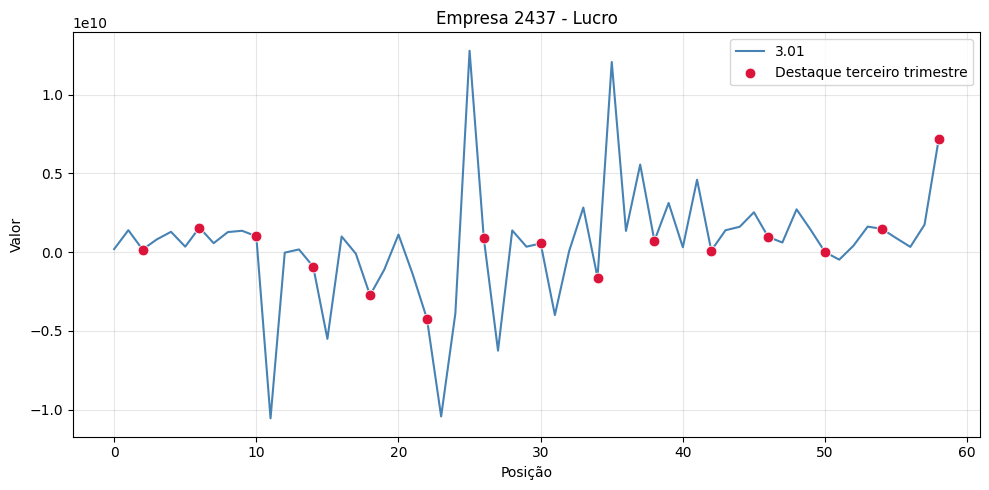

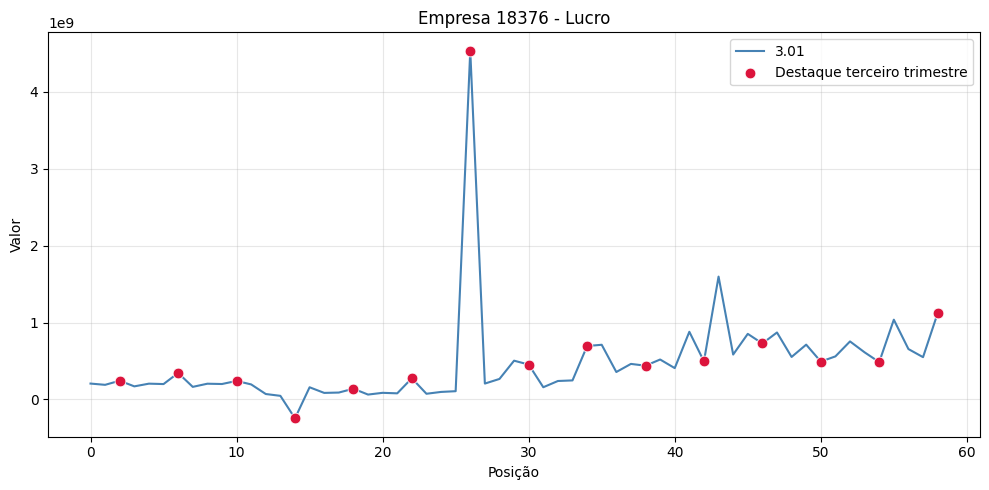

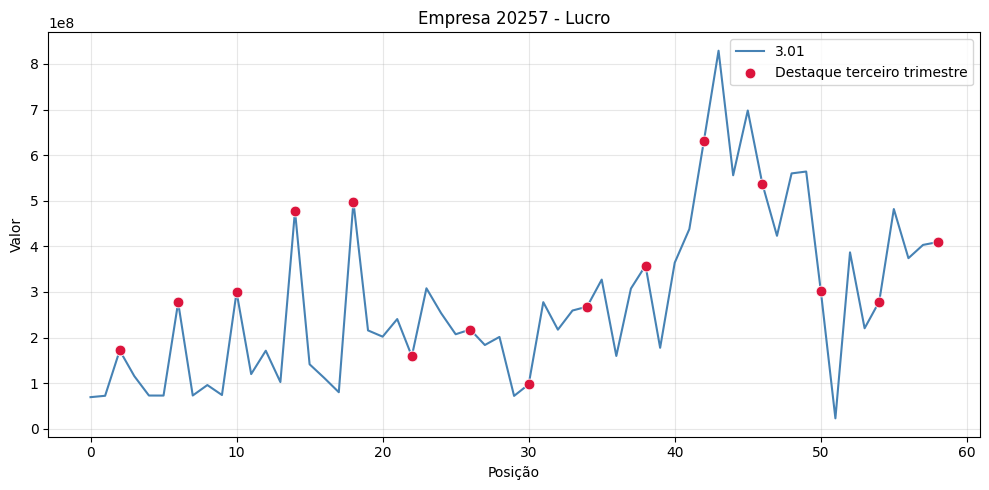

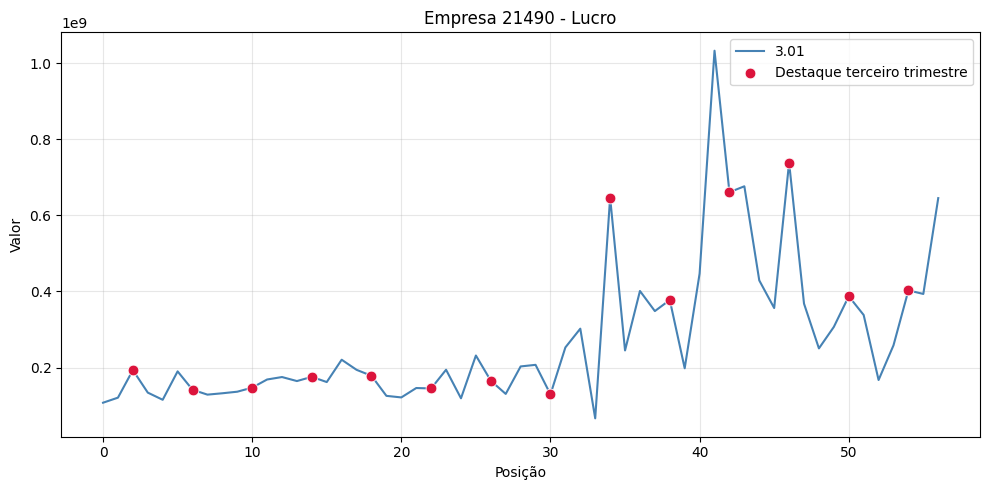

In [15]:
# ...existing code...
def plot_com_destaques(serie, n=4, offset=0, titulo=None, label='Série'):
    s = pd.Series(serie).reset_index(drop=True)
    x = np.arange(len(s))

    plt.figure(figsize=(10, 5))
    plt.plot(x, s.values, label=label, color='steelblue', linewidth=1.5)

    idx = np.arange(offset, len(s), n)  # ex.: 0,4,8,... (use offset=1 para 1,5,9,...)
    plt.scatter(idx, s.iloc[idx].values, color='crimson', s=60, zorder=3,
                edgecolors='white', linewidths=0.6, label=f'Destaque terceiro trimestre')

    plt.title(titulo or f'{label} (Destaque terceiro trimestre)')
    plt.xlabel('Posição')
    plt.ylabel('Valor')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Uso com a sua série:
for code in [2437, 18376, 20257, 21490]:
    plot_com_destaques(dados_indicadores.query(f"CD_CVM == {code}")['3.11'], n=4, offset=2, titulo=f'Empresa {code} - Lucro', label='3.01')

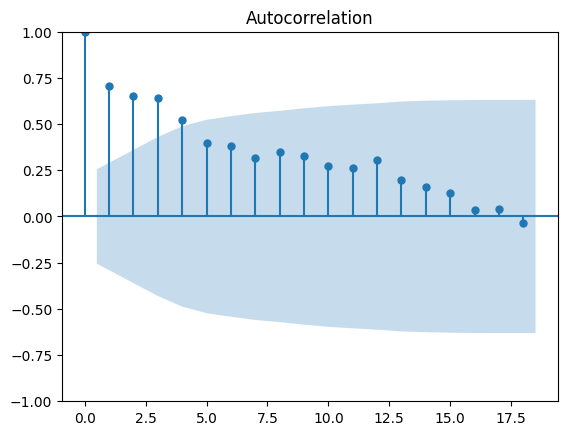

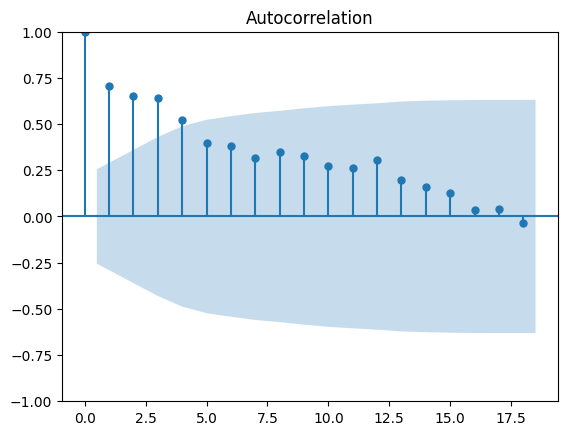

In [16]:
plot_acf(dados_indicadores.query(f"CD_CVM == 20257")['3.01'])

## Correlação Cruzada

O foco de predição será nos indicadores:
* 3.01 (Receitas de venda de Bens e/ou Serviços)
* 3.02 (Custo dos Bens e/ou Serviços)
* 3.11 (Lucro ou Prejuízo consolidado do Período)

In [18]:
def plot_ccf(lags, corr, indice, col, empresa=None):
    """
    Plota a CCF com linhas de confiança, eixos e legendas padronizados.
    - lags: array de lags
    - corr: array de correlações (mesmo tamanho de lags)
    - indice: nome da variável X
    - indicador: nome da variável Y
    - empresa: identificador opcional
    - n_obs: nº de observações para IC; se None usa len(corr) como aproximação
    - alpha: nível de significância (default 5%)
    """
    fig, ax =plt.subplots(figsize=(15, 6))
    plt.stem(lags, corr, use_line_collection=True)
    plt.title(f'CCF entre {indice} e {col} - Empresa {empresa}')
    confidence_interval = 1.96/np.sqrt(len(corr))
    ax.axhline(-confidence_interval, color='red', label='5% intervalo de confiança')
    ax.axhline(confidence_interval, color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(corr), color = 'blue', lw = 1,
            linestyle='--', label = 'Maior correlação +/-')
    ax.axhline(y = np.min(corr), color = 'blue', lw = 1,
            linestyle='--')
    ax.set(ylim = [-1, 1])
    # if y_label != x_label:
    #     ax.set_title('Correlação Cruzada ' + x_label + ' e ' + y_label, weight='bold', fontsize = 15)
    # if y_label == x_label:
    #     ax.set_title('Autocorrelação ' + x_label, weight='bold', fontsize = 15)
    ax.set_ylabel('Coeficientes de Correlação', weight='bold',
    fontsize = 12)
    #determina os pontos marcados no eixo X
    plt.xticks(range(min(lags), max(lags+1), 3))
    ax.set_xlabel('Lags', weight='bold', fontsize = 12)
    plt.legend()
# ...existing code...

In [19]:
# Calcular a Função de Correlação Cruzada (CCF) entre índices (VIF) e apenas os indicadores alvo
ccf_dict = {}
alvo_indicadores = ['3.01', '3.02', '3.11']

# Número de observações para o cálculo do intervalo de confiança (aprox.)
n_obs = len(indicadores_estac[2437])
conf_interval = 1.96 / np.sqrt(n_obs)

for empresa, df in indicadores_estac.items():
    # Indicadores alvo disponíveis neste df
    cols_indicadores = [c for c in alvo_indicadores if c in df.columns]
    if not cols_indicadores:
        continue

    # # Índices aprovados pelo VIF que existem em indices_norm_estac
    # cols_indices = [c for c in vif_finais.get(empresa, pd.Series(dtype=float)).index
    #                 if c in indices_norm_estac.columns]
    # if not cols_indices:
    #     continue

for indice in indices_estac.columns[1:]:
    serie_x = indices_estac[indice].dropna()
    for empresa, df in indicadores_estac.items():
        for col in cols_indicadores:
            serie_y = df[col].dropna()

            # Alinhar pelas datas em comum
            #print(f'{serie_x.shape} - {serie_y.shape}')

            aligned = pd.concat([serie_x, serie_y], axis=1, join='inner').dropna()
            if len(aligned) < 3:
                continue

            corr = ccf(aligned.iloc[:, 0], aligned.iloc[:, 1], adjusted=False)
            lags = np.arange(len(corr))
            ccf_dict[(empresa, indice, col)] = corr

In [20]:
ccf_dict[(2437, 'ibov', '3.01')]

array([-0.03232091,  0.06505161, -0.06453567,  0.08456084,  0.00347055,
        0.27864458, -0.09759673,  0.06333015, -0.22815514,  0.08372866,
        0.06309291,  0.13522476,  0.09167456, -0.1491097 ,  0.27538465,
       -0.53705608,  0.20997593,  0.05401178,  0.1235486 , -0.08209155,
        0.00095833, -0.10415999, -0.05038441,  0.09394258, -0.23759723,
        0.10813502, -0.01440926, -0.05878865,  0.23557194, -0.1265347 ,
        0.13075097, -0.07267938, -0.01339206,  0.02993911,  0.06037526,
        0.0096293 , -0.01732004, -0.03809489, -0.01210802,  0.00207134,
       -0.02393559, -0.00876407, -0.02655268, -0.00897711,  0.03989887,
        0.00633318, -0.00544046,  0.01709247,  0.01619877, -0.03057771,
       -0.00281815,  0.01565799, -0.00055379, -0.02180197, -0.01268599,
        0.01411292, -0.00082432, -0.00666429])

In [21]:
# Desempacotar ccf_dict em um DataFrame
records = []
for (empresa, indice_x, indicador), ccf_arr in ccf_dict.items():
    for lag, corr_val in enumerate(ccf_arr):
        records.append({
            'Indice': indice_x,
            'Empresa': empresa,
            'Indicador': indicador,
            'Lag': lag,          # statsmodels.ccf retorna lags >= 0
            'CCF': corr_val,
            'Abs_CCF': abs(corr_val)
        })

df_ccf = pd.DataFrame(records)

# Opcional: limitar por lag máximo (ex.: até 8)
lag_max = 8
df_ccf = df_ccf[df_ccf['Lag'] <= lag_max]

# Marcar significância pelo intervalo de confiança já calculado (conf_interval)
df_ccf['Significativo'] = df_ccf['Abs_CCF'] > conf_interval

# 1) Top N lags significativos em geral
topN = 10
top_lags = (df_ccf[df_ccf['Significativo']]
            .sort_values('Abs_CCF', ascending=False)
            .head(topN))
display(top_lags)

# 2) Ranking por par (Indice, Empresa, Indicador): melhor lag por par
idx_max = (df_ccf[df_ccf['Significativo']]
           .groupby(['Empresa', 'Indice', 'Indicador'])['Abs_CCF']
           .idxmax())
ranked_pairs = (df_ccf.loc[idx_max]
                .sort_values('Abs_CCF', ascending=False)
                .reset_index(drop=True))
display(ranked_pairs.head(topN))

Indice  Empresa Indicador  Lag       CCF   Abs_CCF  \
642              ibov    21490      3.11    4 -0.626943  0.626943   
1338              iee    21490      3.11    4 -0.580337  0.580337   
10132    PIB Corrente    20257      3.02    1  0.576699  0.576699   
12214    Vol. VA Agro    20257      3.02    0  0.565043  0.565043   
26831         T-bonds    20257      3.02    1  0.562560  0.562560   
1339              iee    21490      3.11    5  0.552158  0.552158   
5393   INCC-Brasil-DI    21490      3.01    8 -0.520846  0.520846   
3370             igpm    21490      3.02    6 -0.519114  0.519114   
2151              vix     2437      3.02    5  0.516247  0.516247   
4762         IPAOG-DI    21490      3.02    6 -0.515928  0.515928   

       Significativo  
642             True  
1338            True  
10132           True  
12214           True  
26831           True  
1339            True  
5393            True  
3370            True  
2151            True  
4762            True

Indice  Empresa Indicador  Lag       CCF   Abs_CCF  Significativo
0            ibov    21490      3.11    4 -0.626943  0.626943           True
1             iee    21490      3.11    4 -0.580337  0.580337           True
2    PIB Corrente    20257      3.02    1  0.576699  0.576699           True
3    Vol. VA Agro    20257      3.02    0  0.565043  0.565043           True
4         T-bonds    20257      3.02    1  0.562560  0.562560           True
5  INCC-Brasil-DI    21490      3.01    8 -0.520846  0.520846           True
6            igpm    21490      3.02    6 -0.519114  0.519114           True
7             vix     2437      3.02    5  0.516247  0.516247           True
8        IPAOG-DI    21490      3.02    6 -0.515928  0.515928           True
9  INCC-Brasil-DI    21490      3.02    7 -0.504726  0.504726           True

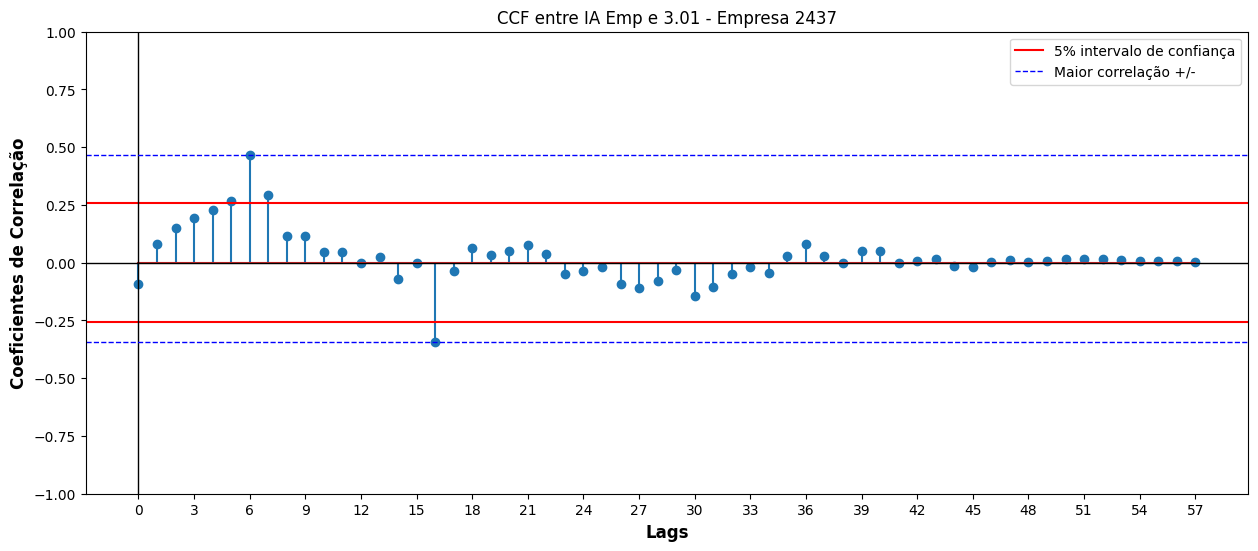

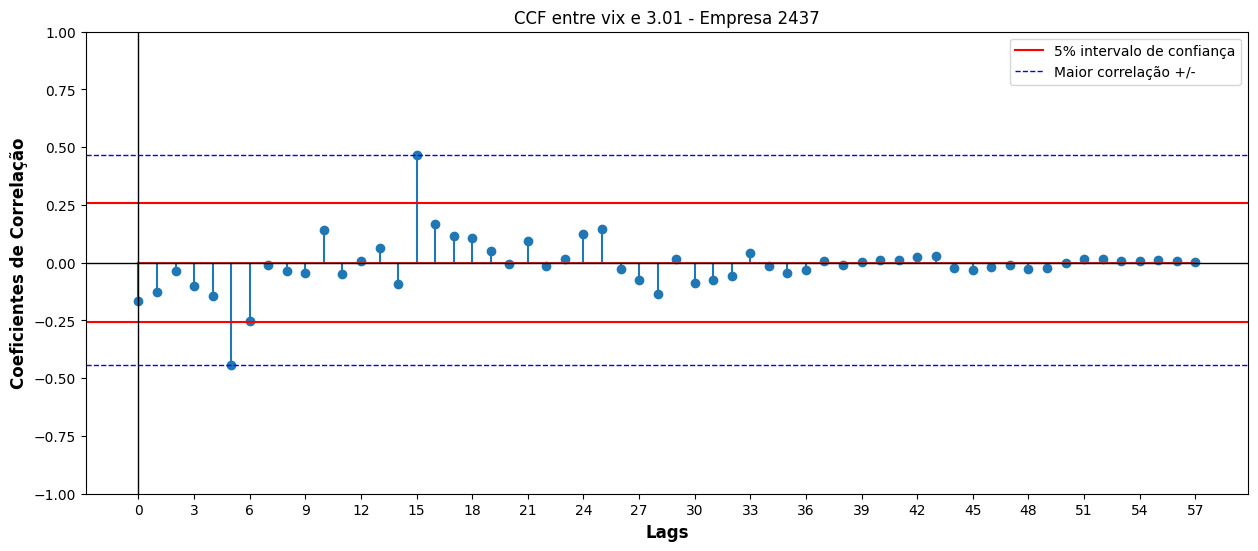

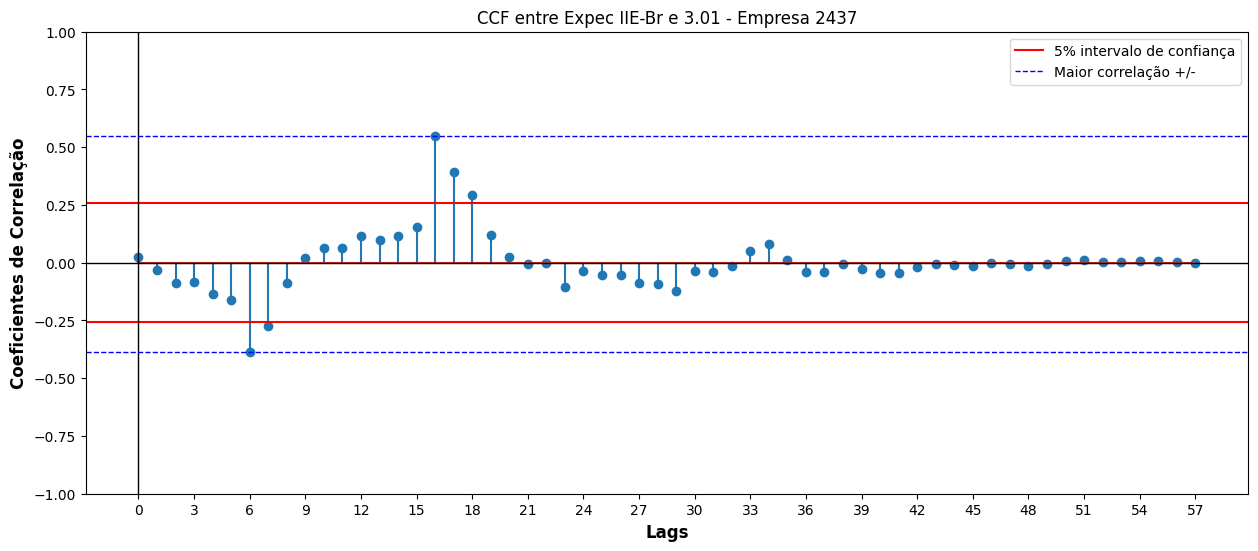

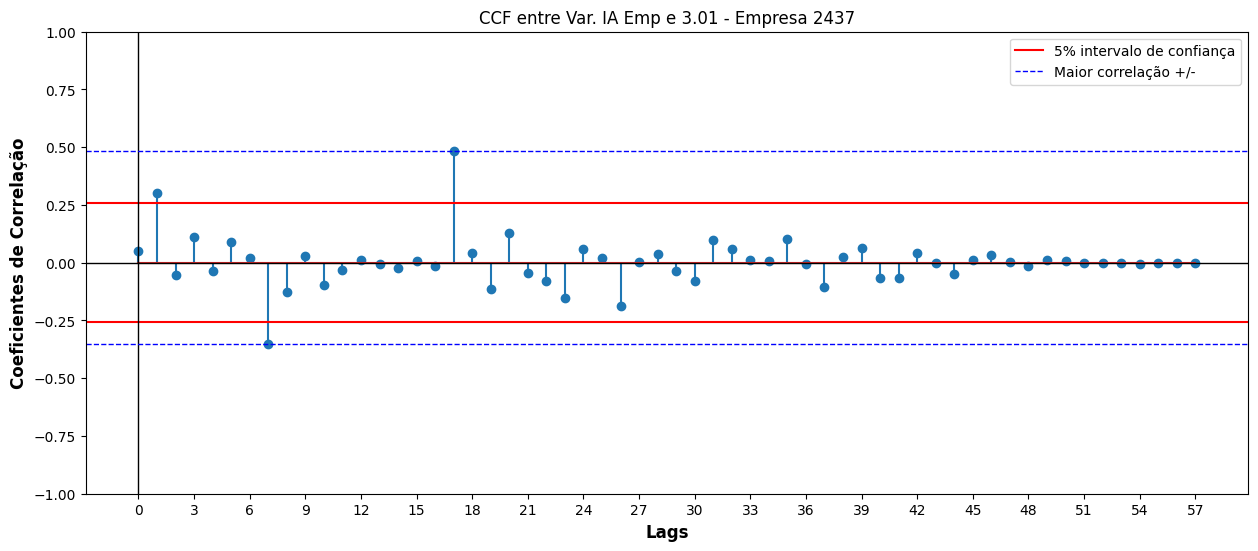

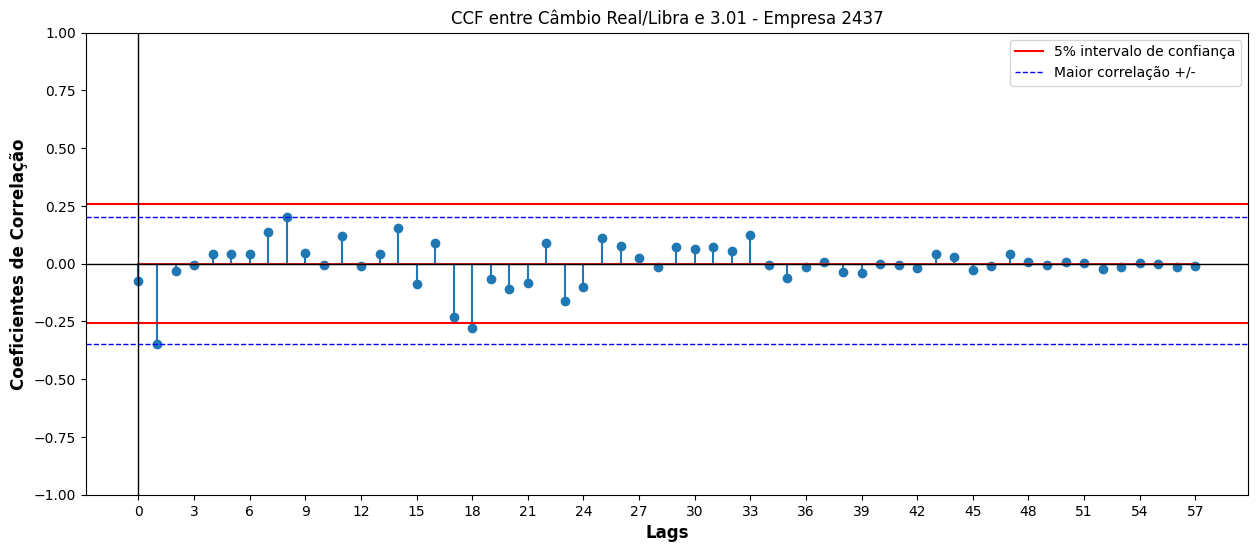

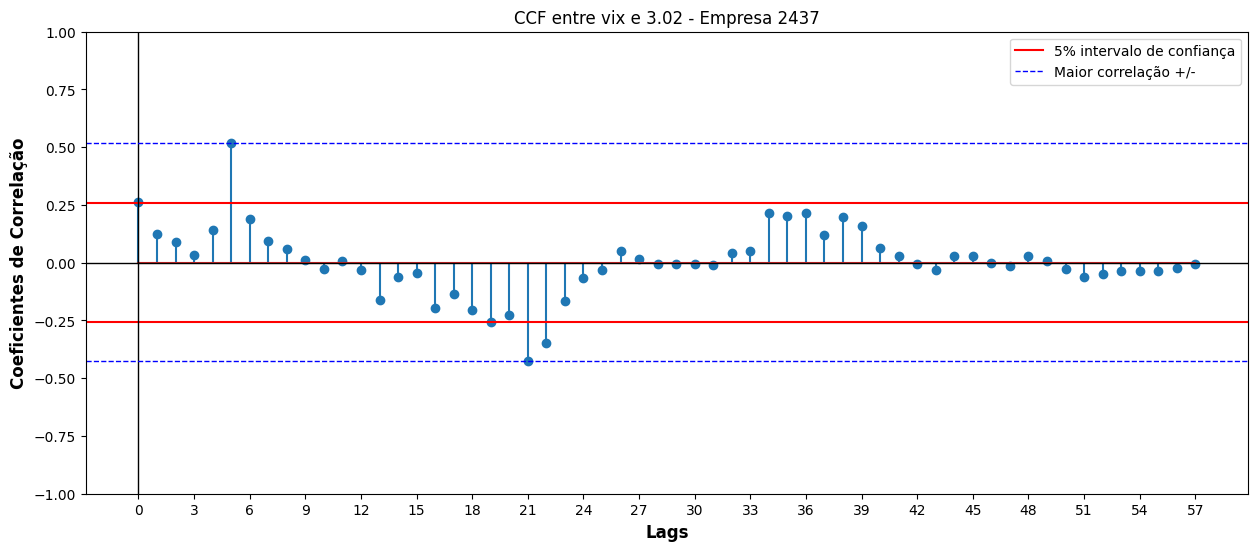

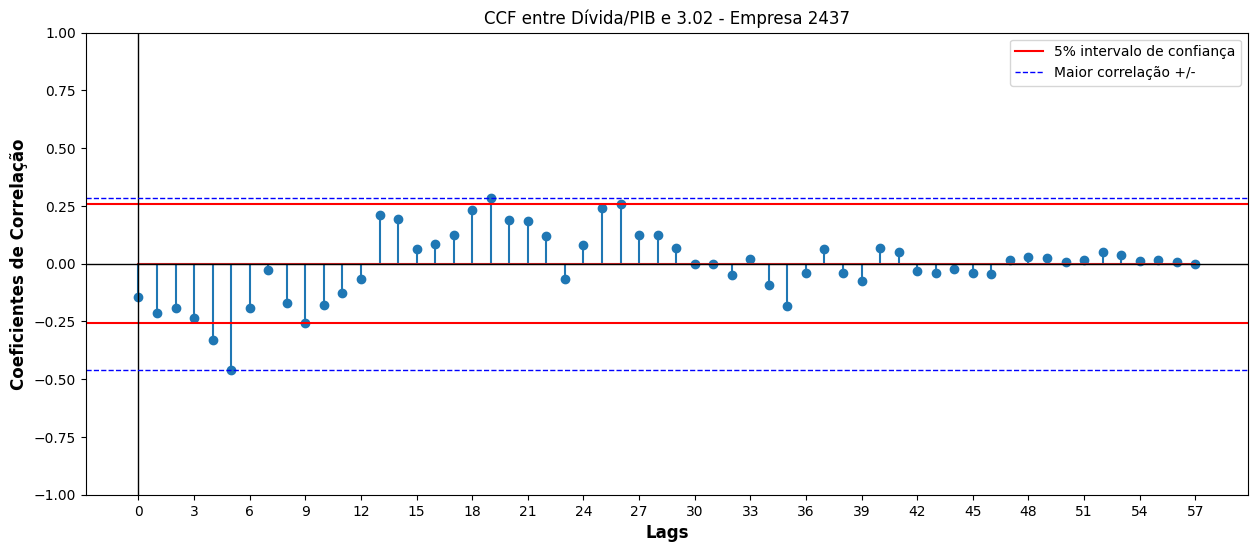

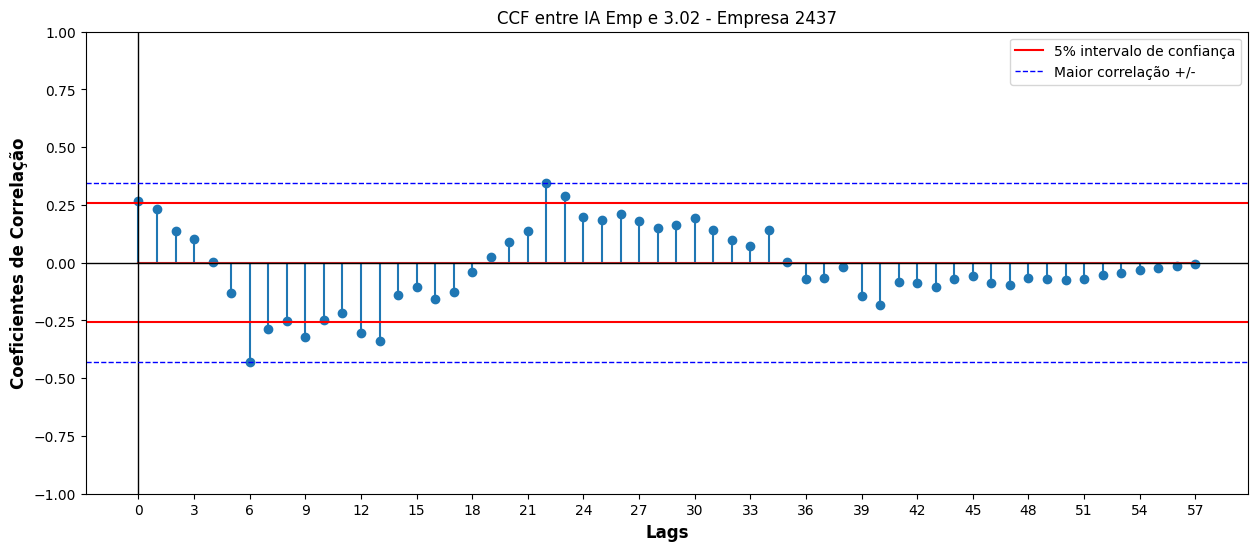

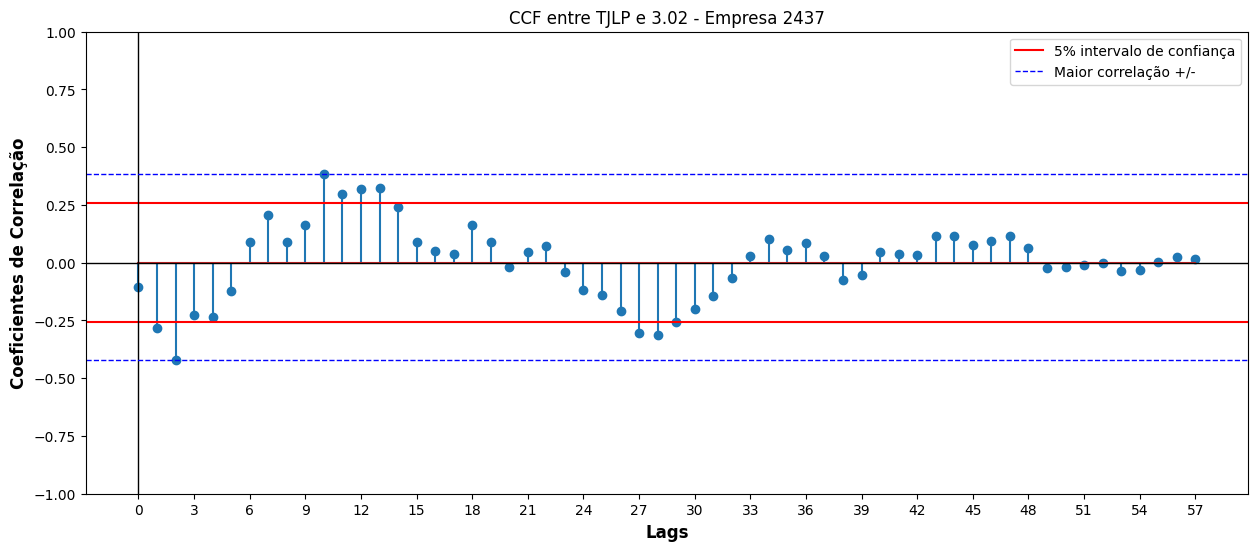

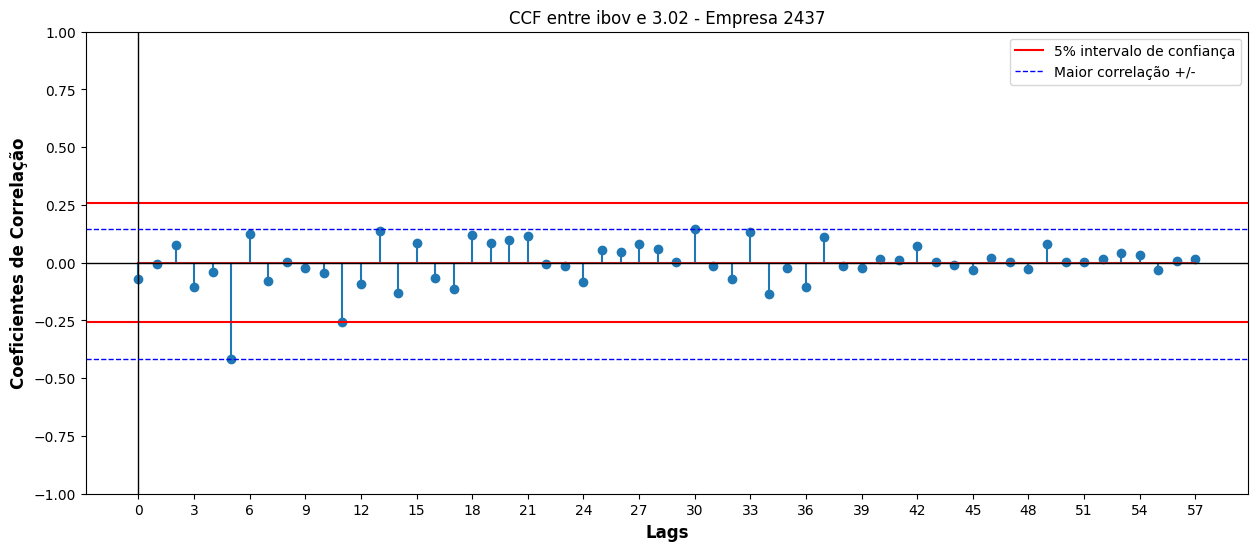

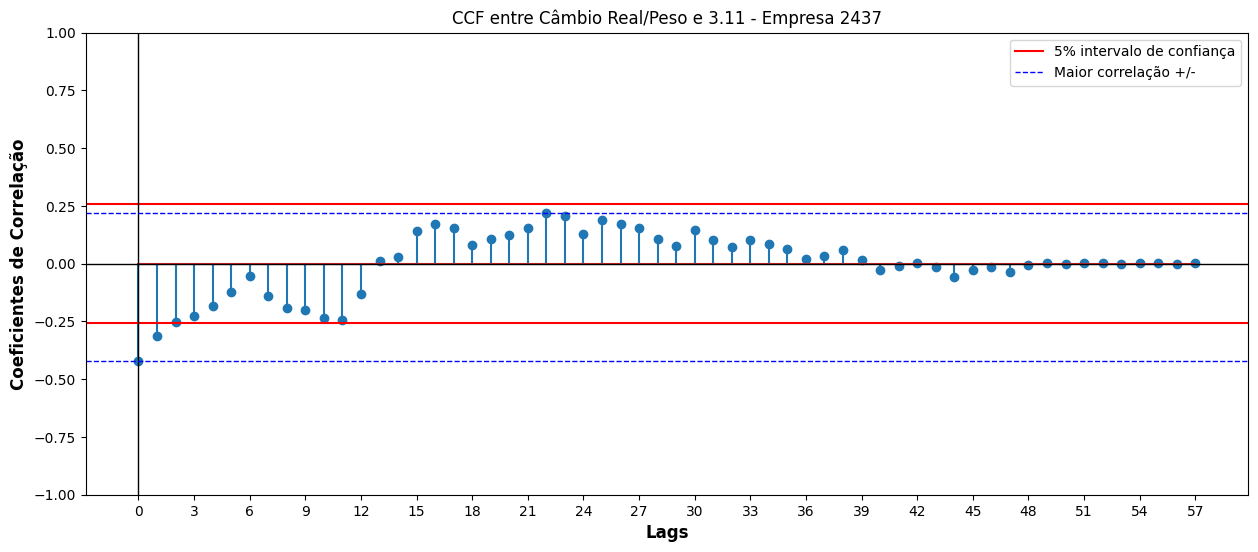

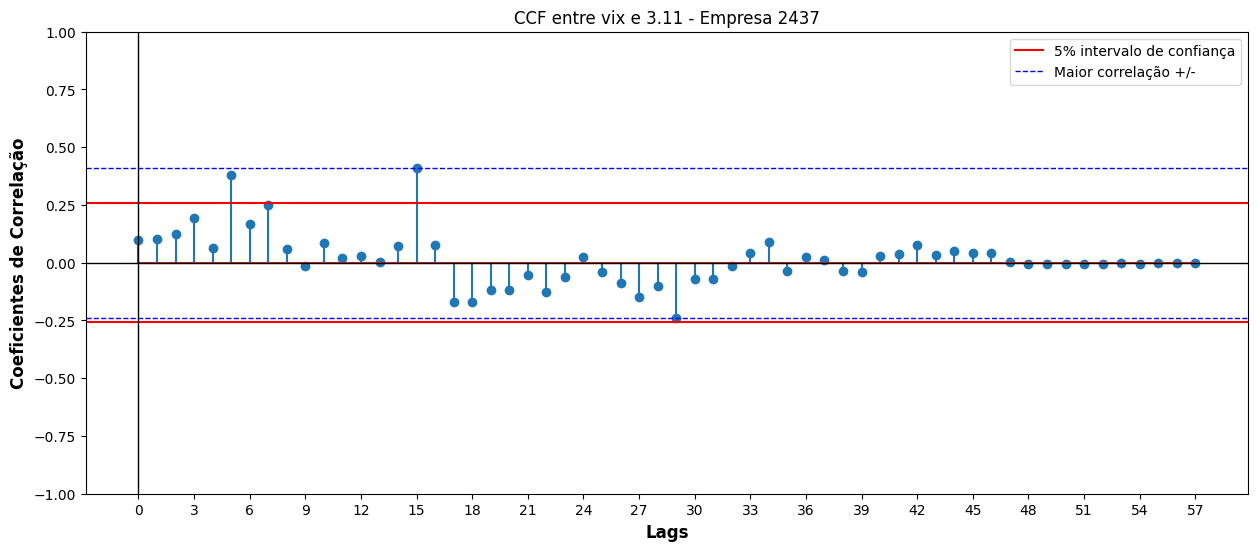

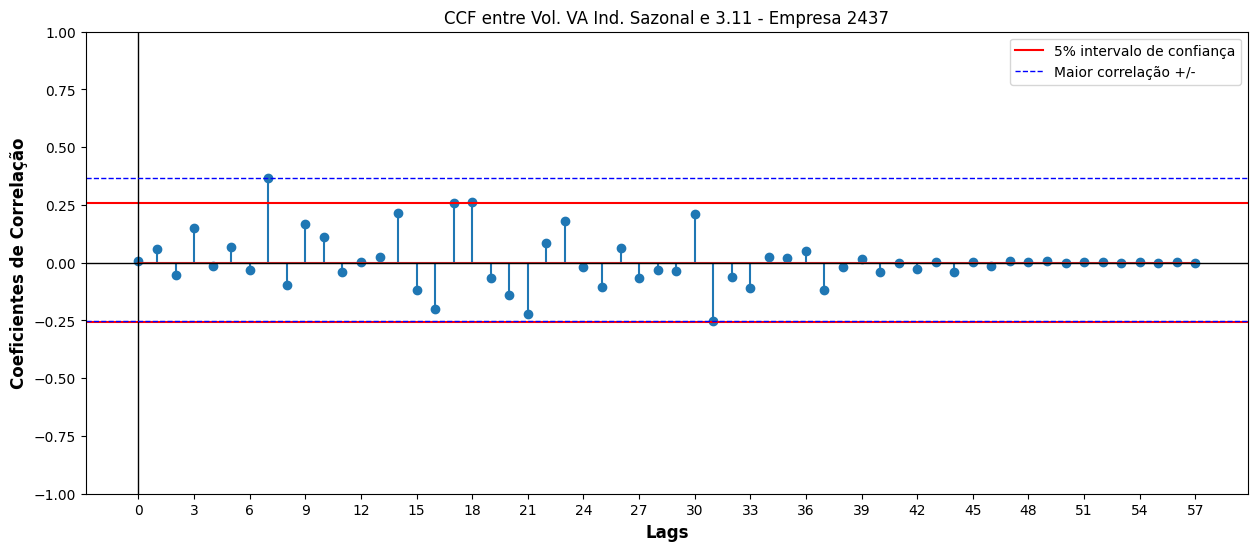

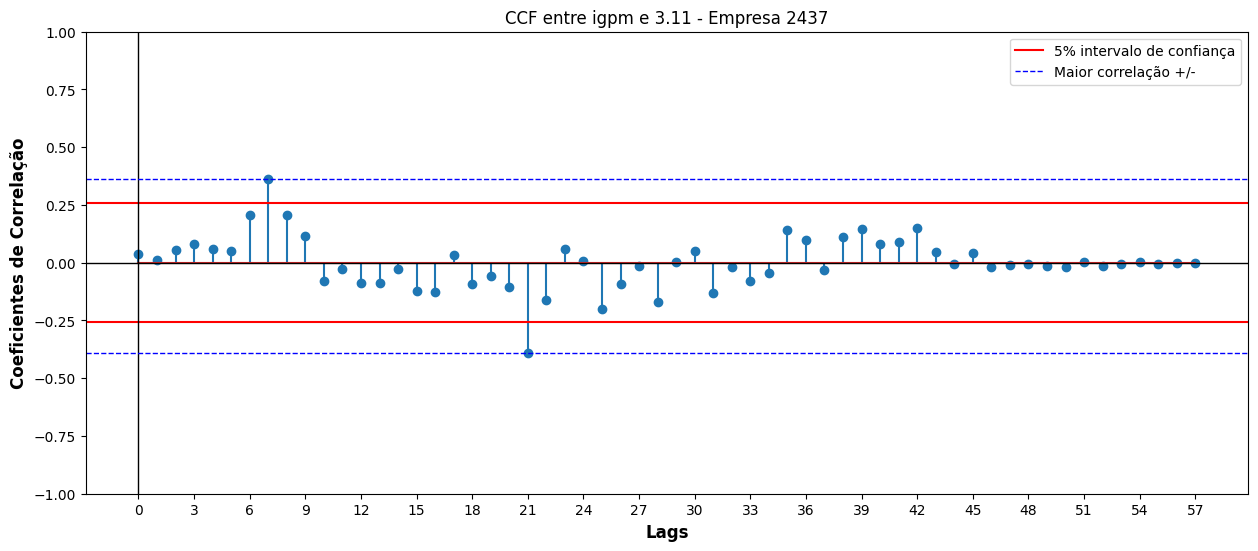

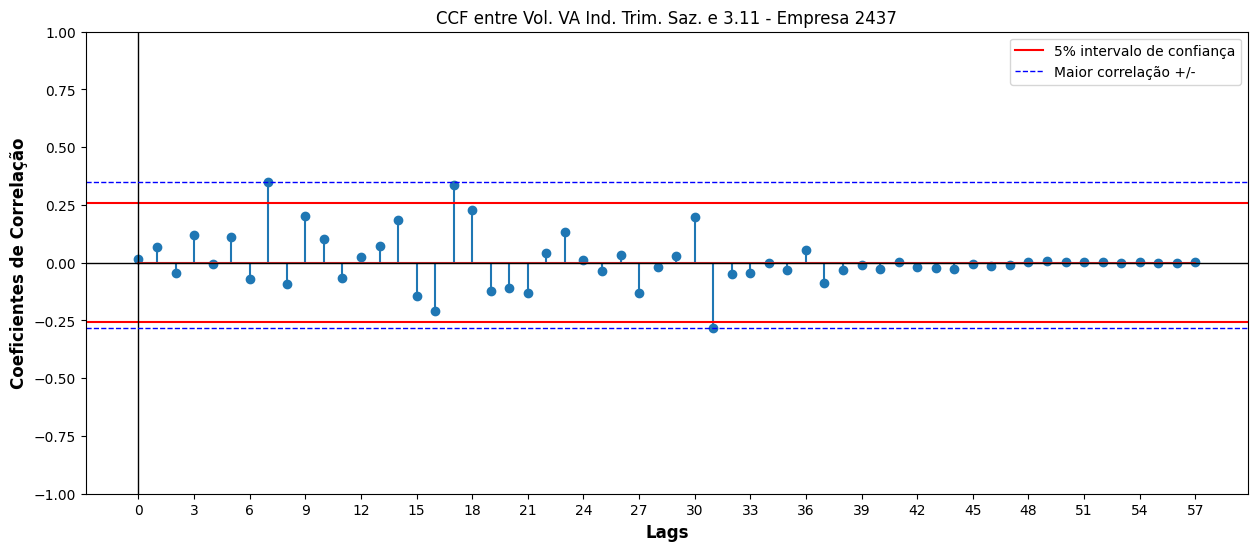

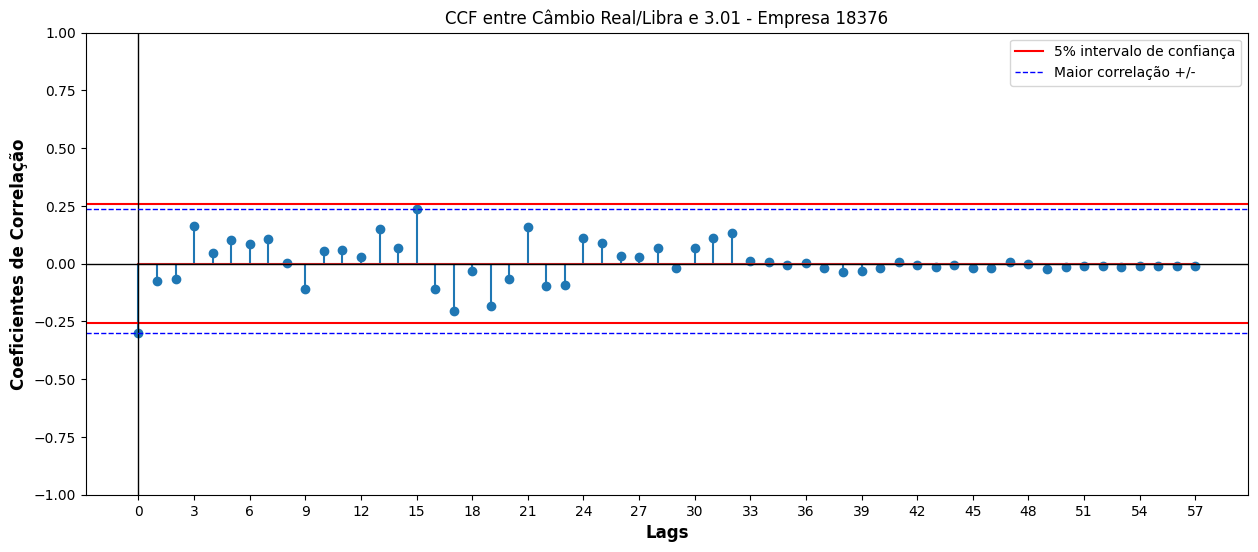

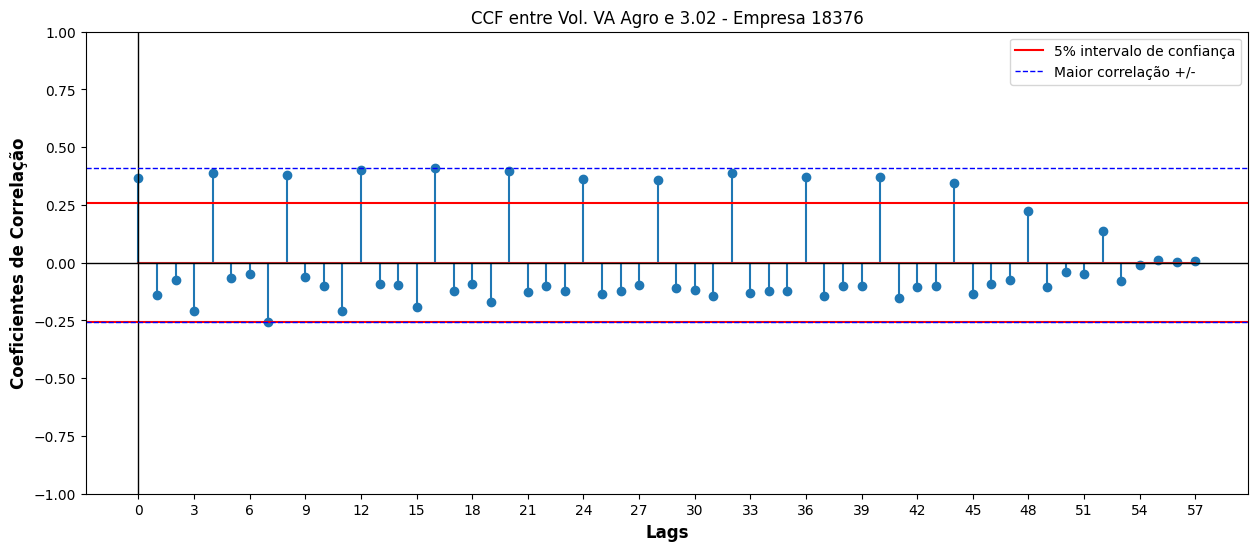

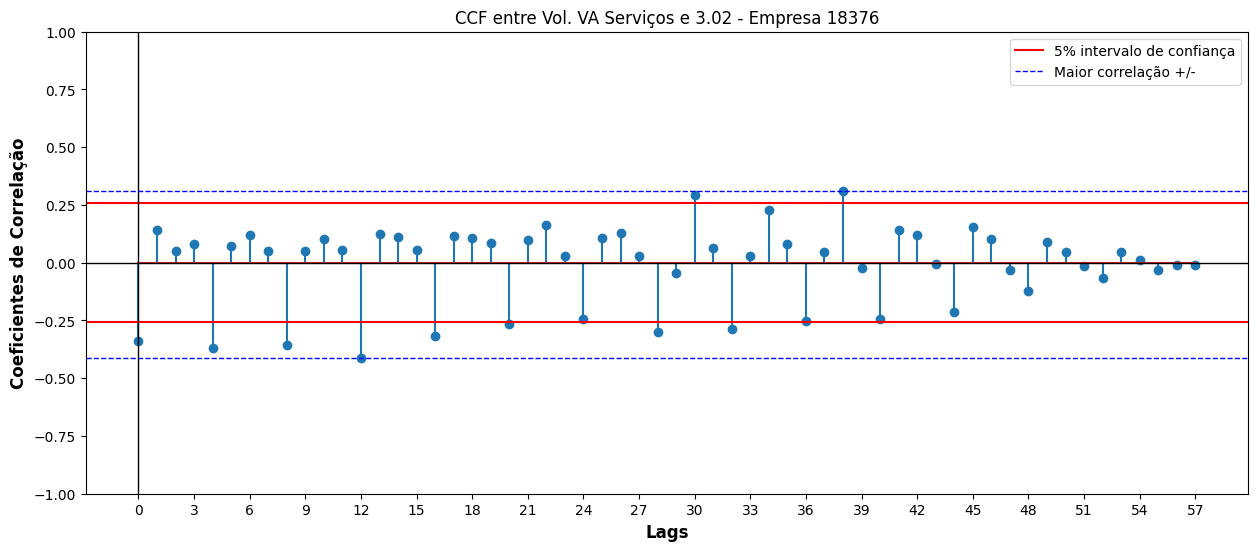

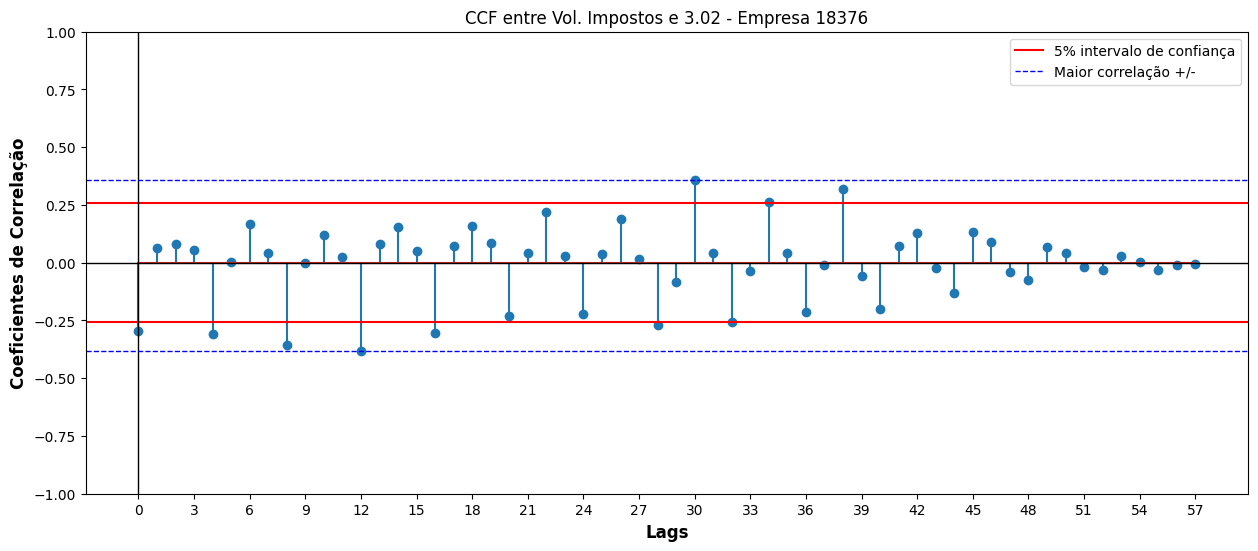

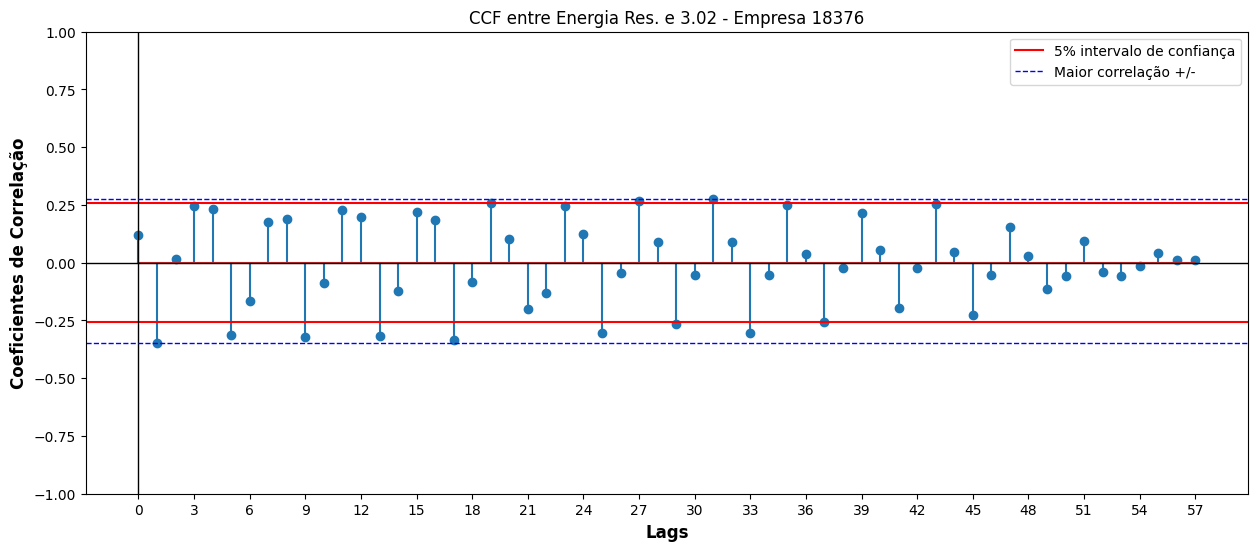

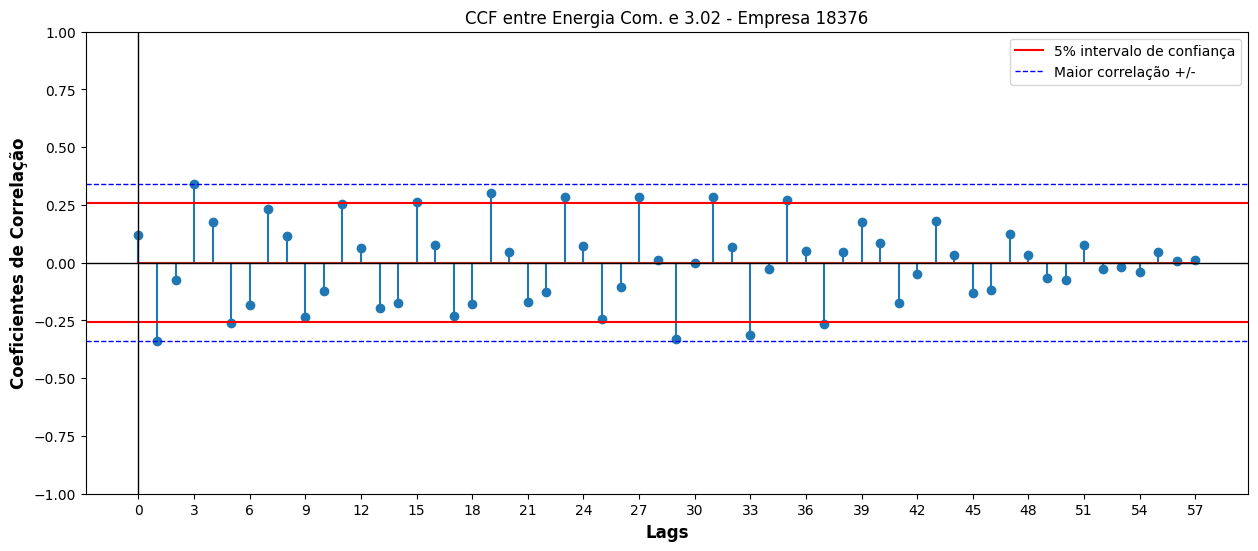

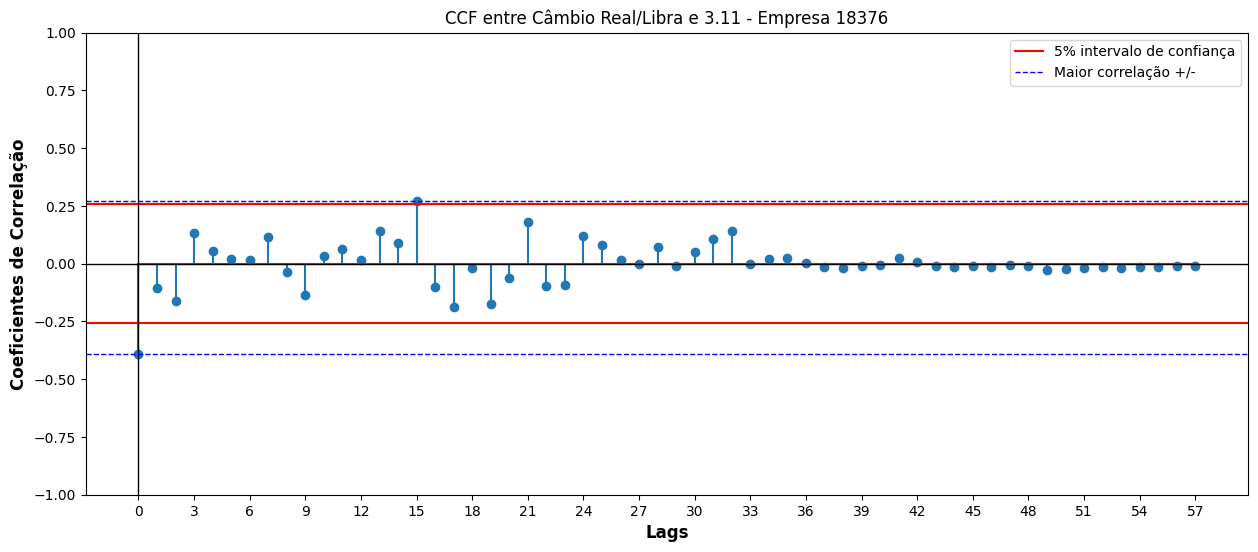

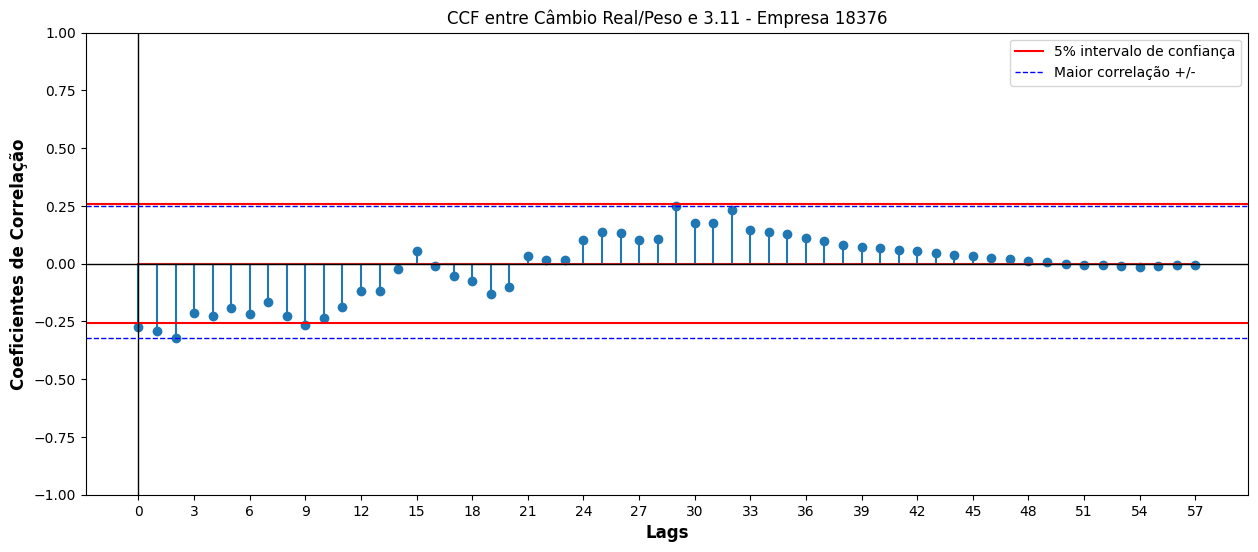

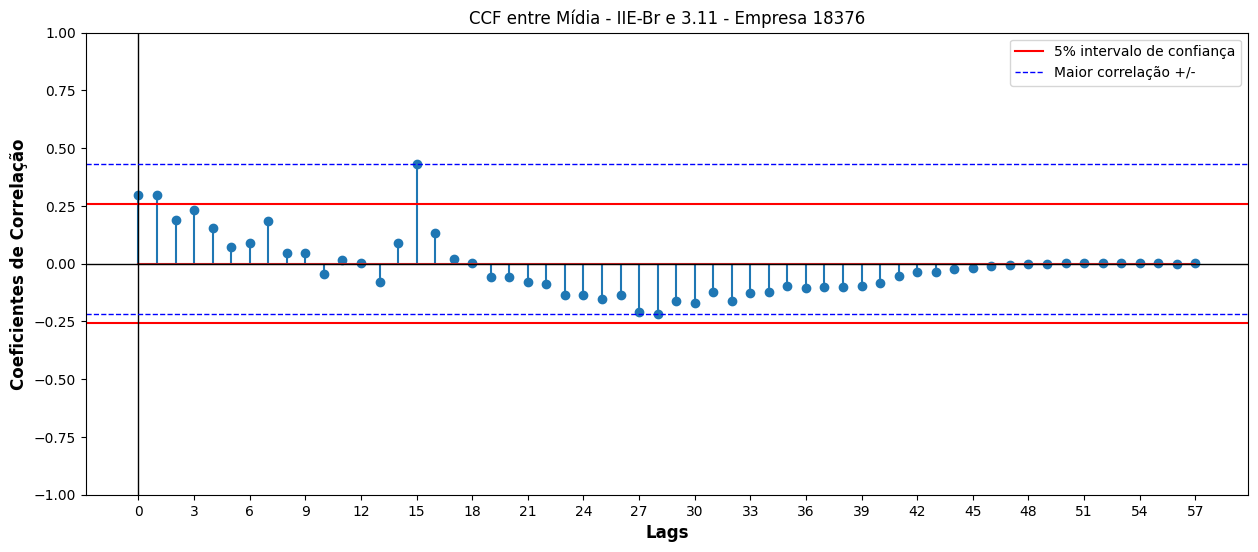

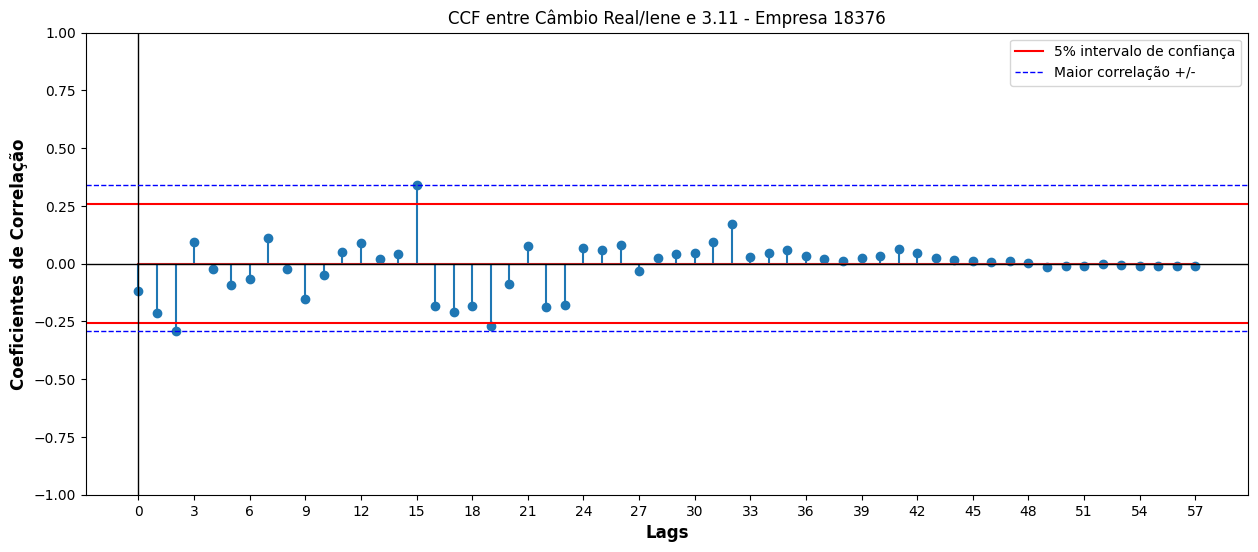

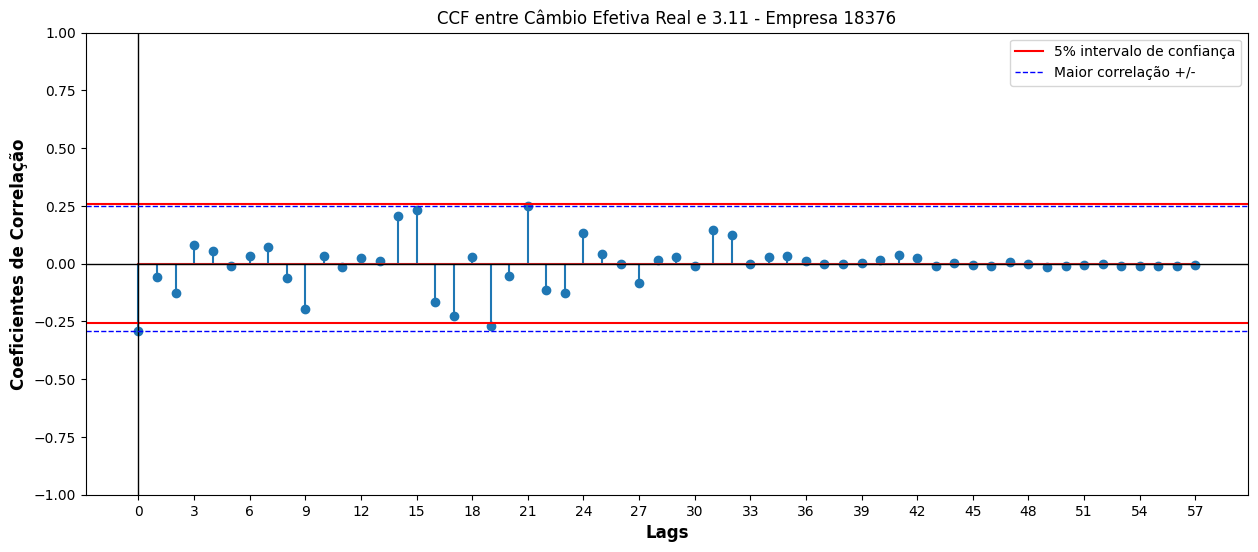

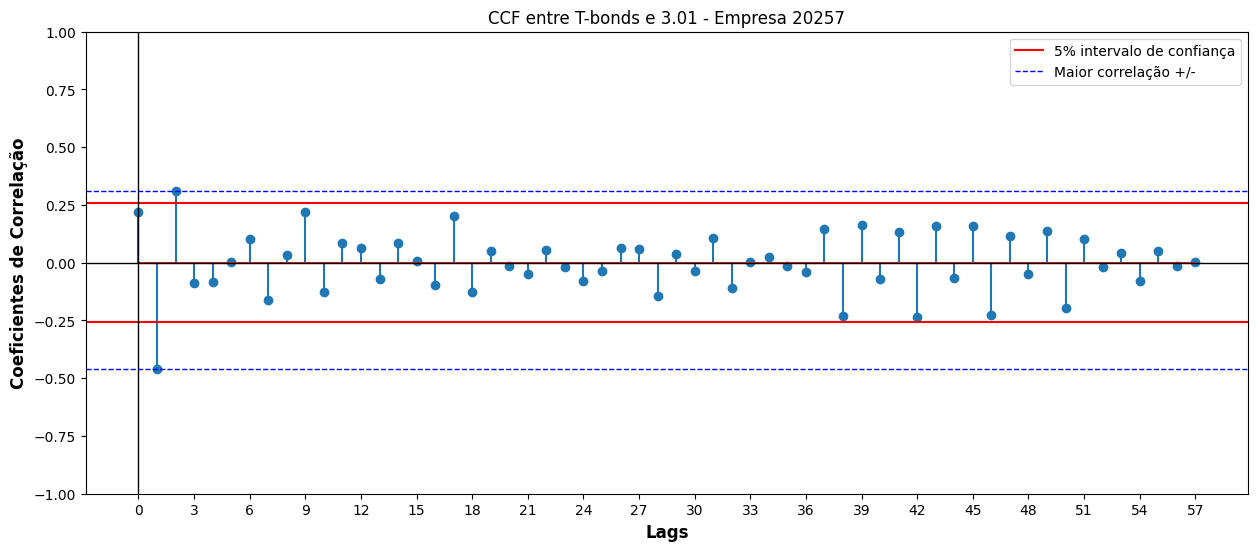

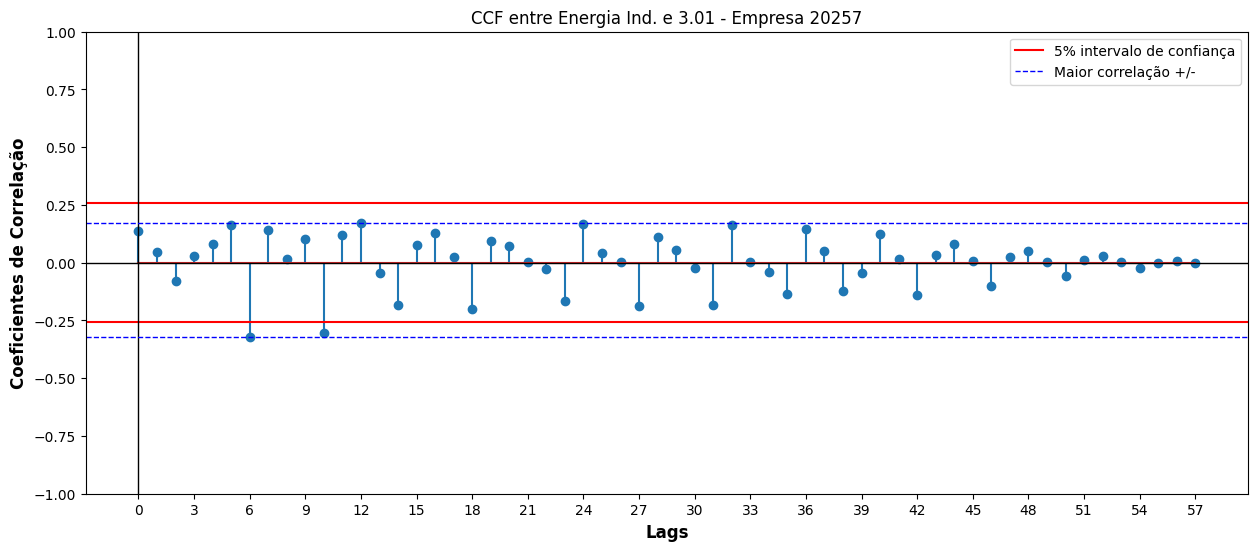

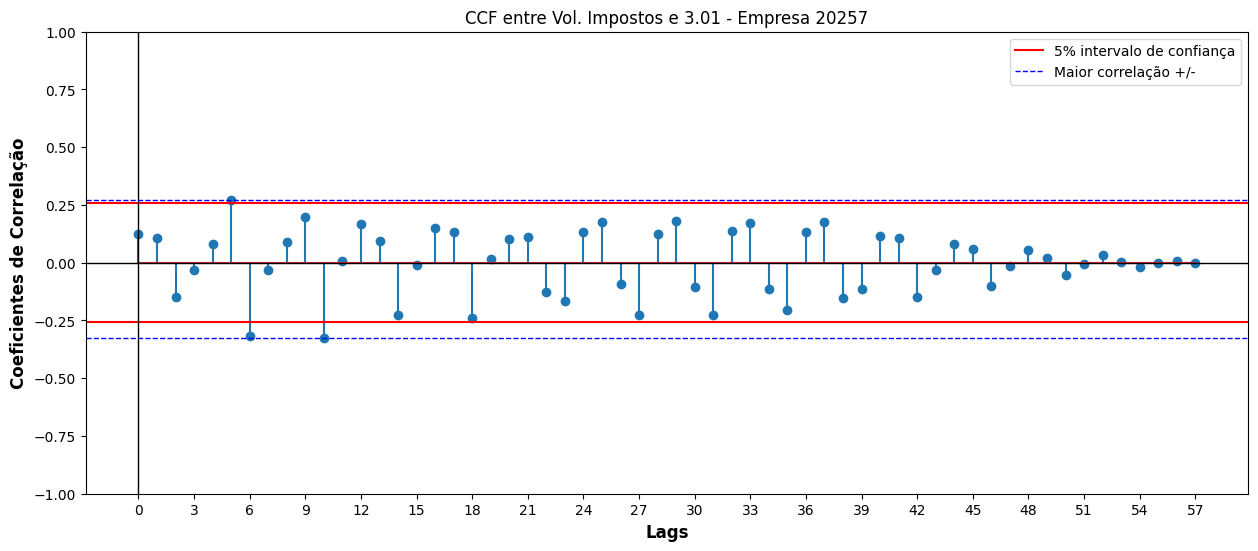

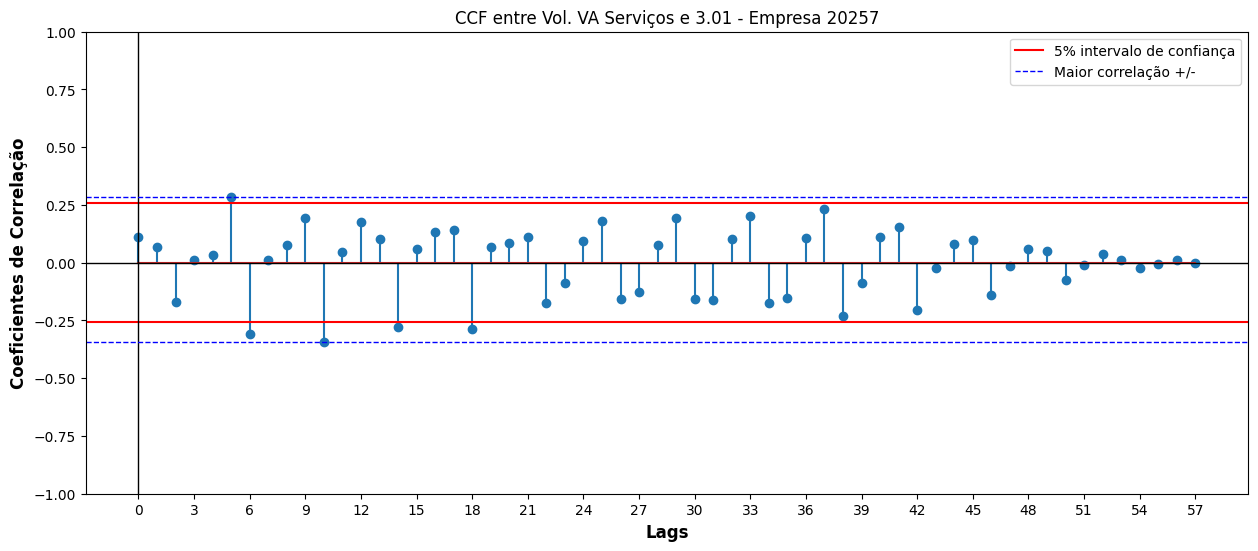

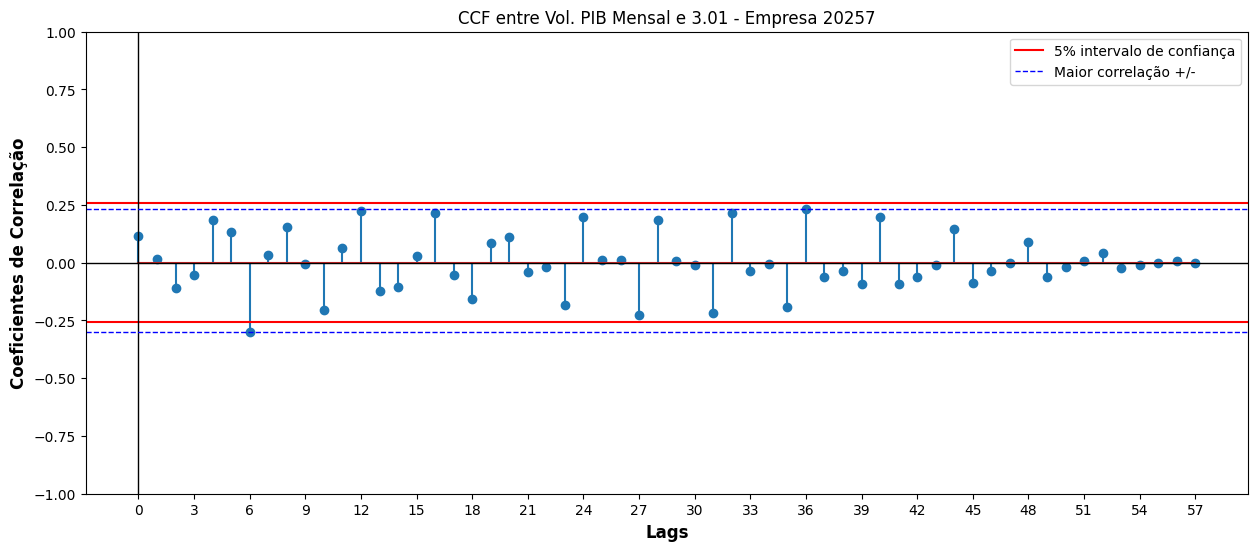

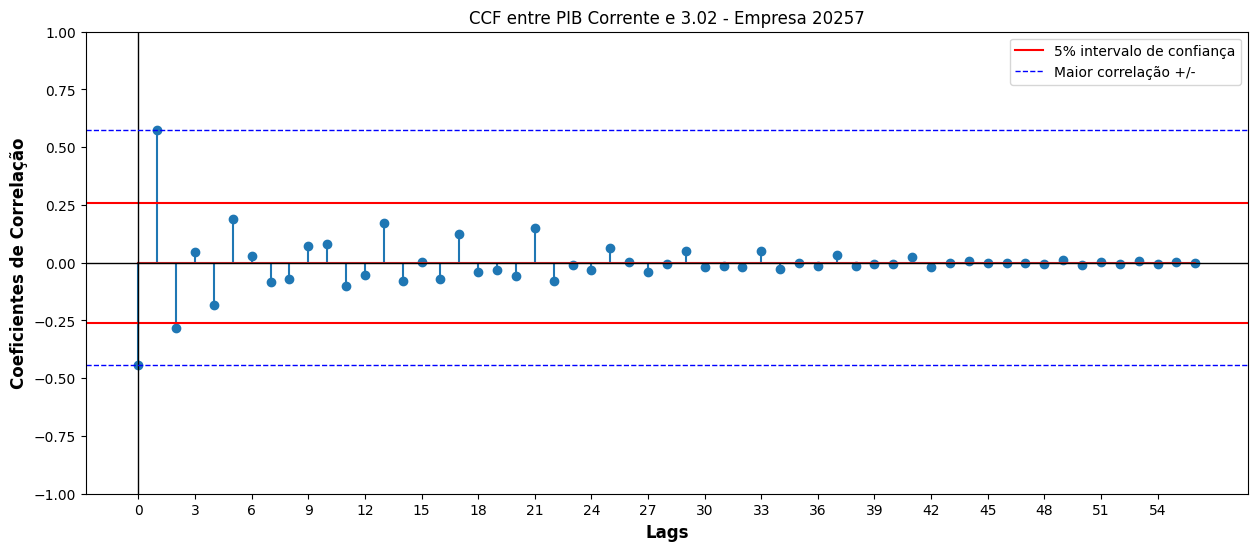

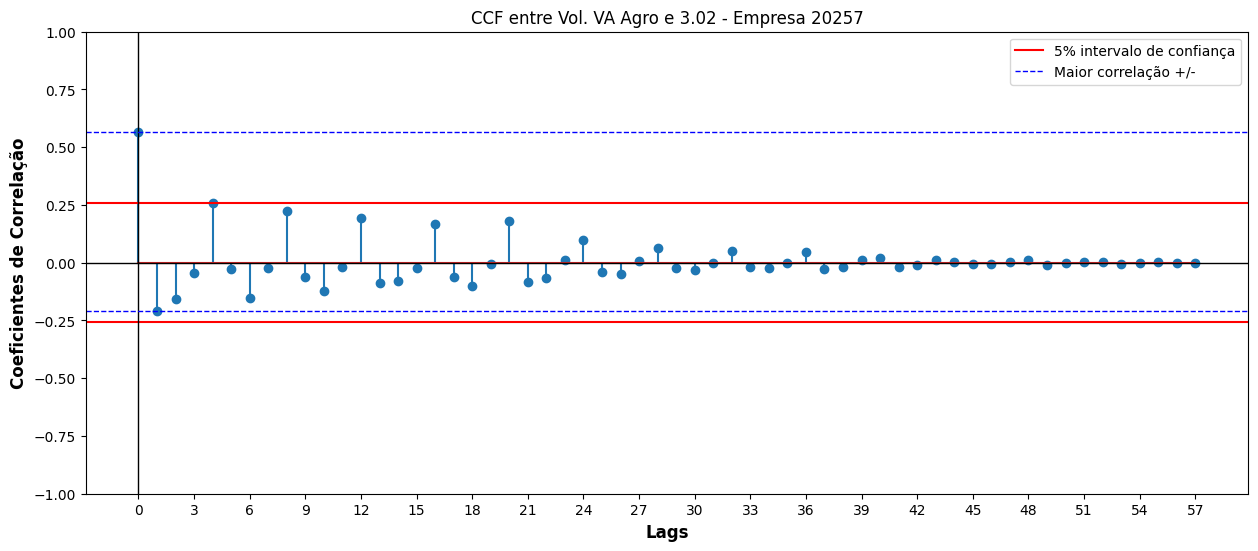

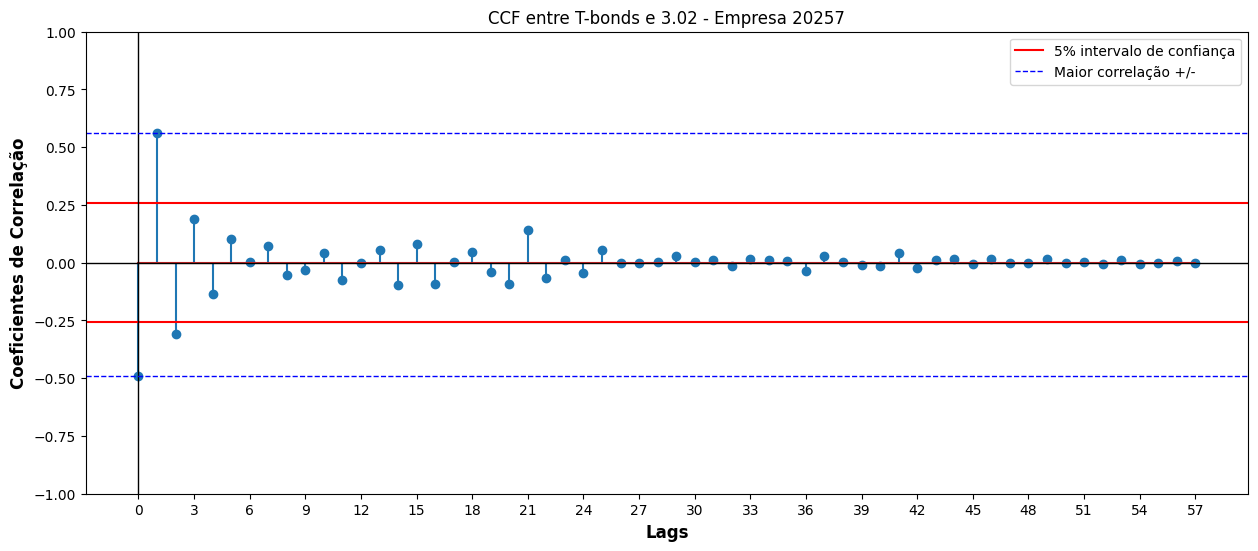

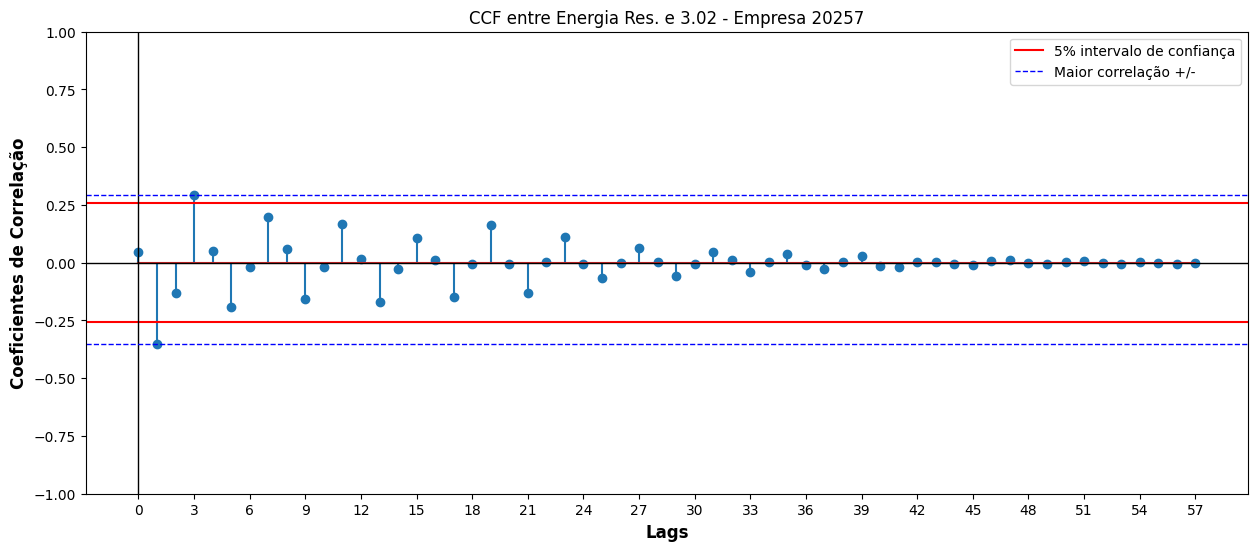

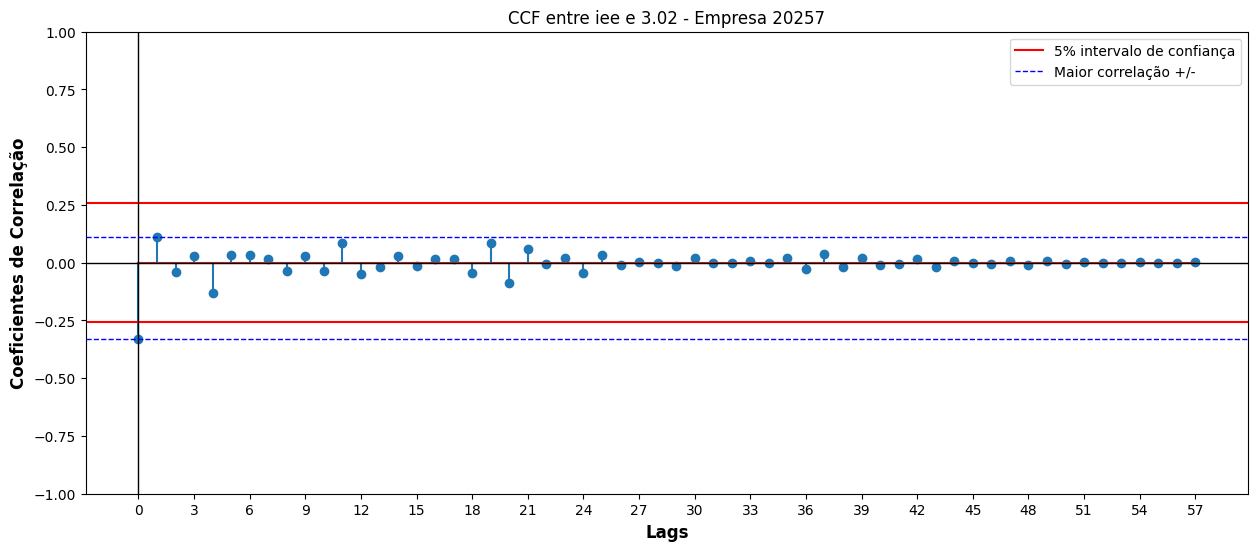

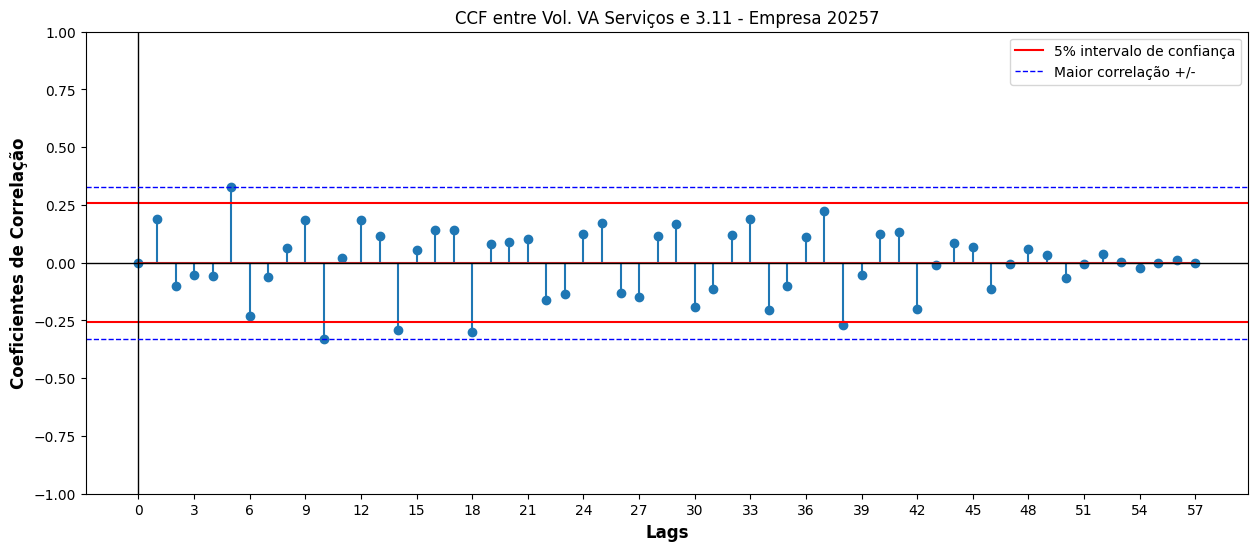

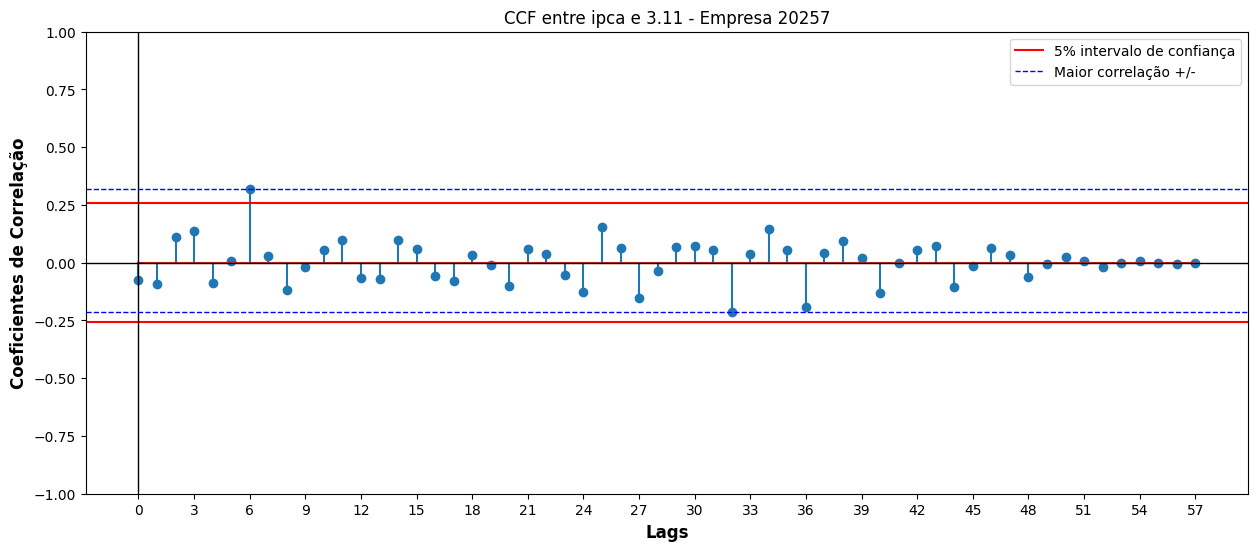

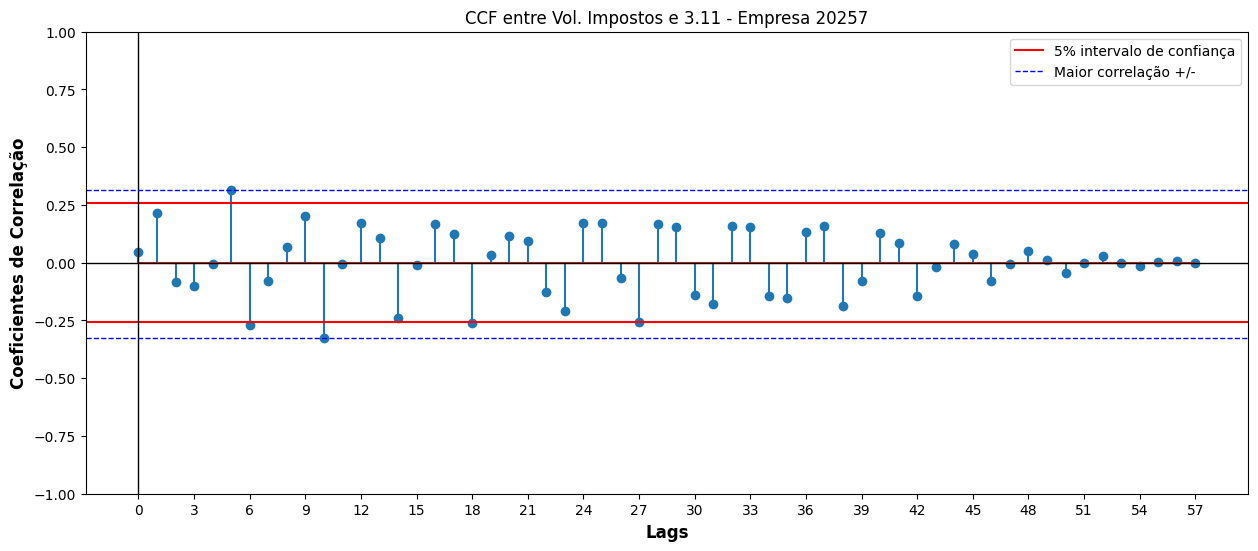

Error in callback <function flush_figures at 0x000001DA2490C540> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Plotar Top 5 por (Empresa, Indicador) com base em ranked_pairs
top_n = 5
alvo_indicadores = ['3.01', '3.02', '3.11']  # opcional: filtre apenas os indicadores-alvo

rp = ranked_pairs.copy()
if 'Indicador' in rp.columns and alvo_indicadores:
    rp = rp[rp['Indicador'].isin(alvo_indicadores)]

for (empresa, indicador), df_group in rp.groupby(['Empresa', 'Indicador']):
    df_top = df_group.sort_values('Abs_CCF', ascending=False).head(top_n)
    for _, row in df_top.iterrows():
        indice = row['Indice']
        key = (empresa, indice, indicador)
        corr = ccf_dict.get(key)
        if corr is None:
            # chave inexistente no dicionário (pode ocorrer por nomes/filtragens)
            continue
        lags = np.arange(len(corr))
        plot_ccf(lags, corr, indice=indice, col=indicador, empresa=empresa)

In [22]:
dict_indicadores.keys()

dict_keys([2437, 18376, 20257, 21490])

Montando dataframes de indicadores específicos

In [23]:
def criar_dataframe_indicador(df, coluna_valor):
    """
    Cria um dataframe pivotado onde a coluna 'DT_FIM_EXERC' é o índice
    e cada coluna corresponde ao valor da coluna especificada (coluna_valor)
    de cada empresa (CD_CVM).

    Parâmetros:
      df: DataFrame original com as colunas 'CD_CVM', 'DT_FIM_EXERC' e a coluna desejada.
      coluna_valor: Nome da coluna que será utilizada para os valores (ex.: 'Resultado Bruto').

    Retorna:
      Um DataFrame pivotado.
    """
    resultado = pd.DataFrame()
    for cd_cvm in df['CD_CVM'].unique():
        df_temp = df.loc[df['CD_CVM'] == cd_cvm, ['DT_FIM_EXERC', coluna_valor]].copy()
        df_temp = df_temp.rename(columns={coluna_valor: cd_cvm})
        df_temp = df_temp.set_index('DT_FIM_EXERC')
        if resultado.empty:
            resultado = df_temp.copy()
        else:
            resultado = resultado.join(df_temp, how='outer')

    # Preencher valores NaN com 0
    resultado.fillna(0, inplace=True)
    
    return resultado

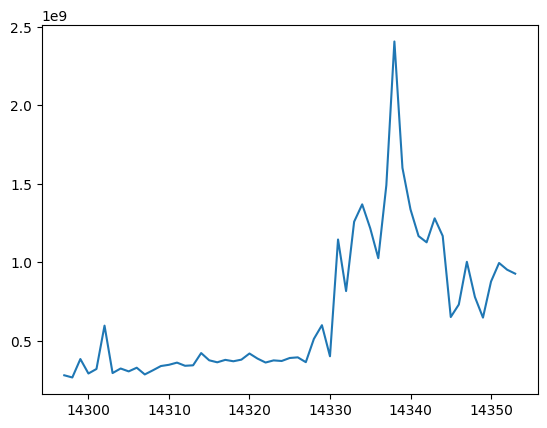

In [24]:
plt.plot(dados_indicadores.query("CD_CVM == 21490")['3.01'])

In [30]:
resultado_bruto = criar_dataframe_indicador(dados_indicadores_transm, '3.01')
lucro_consolidado = criar_dataframe_indicador(dados_indicadores_transm, '3.11')
despesas_operacionais = criar_dataframe_indicador(dados_indicadores_transm, '3.04')

In [25]:
dados_indicadores_transm['CD_CVM'].unique()

array([ 2437, 18376, 20257, 21490], dtype=int64)

Teste de estacionariedade KPSS
-   **Hipótese Nula (H0)**: A série é estacionária.
-   **Hipótese Alternativa (Ha)**: A série não é estacionária.

Teste de estacionariedade ADF
-   **Hipótese Nula (H0)**: A série não é estacionária.
-   **Hipótese Alternativa (Ha)**: A série é estacionária.

obs: utilizando dois métodos distintos para confirmar a estacionariedade

In [31]:
def teste_dados_estacionarios(series):
    dados_estacionarios_kpss = {}
    dados_estacionarios_adf = {}
    for cd_cvm, serie in series.items():
        print(cd_cvm)
        kpss_stat, p_value, lags, critical_values = kpss(serie)
        
        print(f'Estatística do teste: {kpss_stat:.4f}')
        print(f'p-valor: {p_value:.4f}')
        print('Valores Críticos:')
        for key, value in critical_values.items():
            print(f'{key}: {value:.4f}')
        print('Resultado:')
        if p_value > 0.05:
            #dados_estacionarios_kpss[cd_cvm] = p_value
            dados_estacionarios_kpss[cd_cvm] = 'S'
        else:
            #dados_estacionarios_kpss[cd_cvm] = p_value
            dados_estacionarios_kpss[cd_cvm] = 'N'

        adf_result = adfuller(serie)

        print('ADF Statistic: %f' % adf_result[0])
        print('p-value: %f' % adf_result[1])
        # Inspeciona valores críticos
        for key, value in adf_result[4].items():
            print(f'Critical Value ({key}): {value:.4f}')

        if adf_result[1] < 0.05:
            #dados_estacionarios_adf[cd_cvm] = adf_result[1]
            dados_estacionarios_adf[cd_cvm] = 'N'
        else:
            dados_estacionarios_adf[cd_cvm] = 'S'

        df_dados_estacionarios_KPSS = pd.DataFrame.from_dict(dados_estacionarios_kpss, orient='index', columns=['KPSS'])
        df_dados_estacionarios_ADF = pd.DataFrame.from_dict(dados_estacionarios_adf, orient='index', columns=['ADF'])
        
    return df_dados_estacionarios_KPSS.join(df_dados_estacionarios_ADF)


In [32]:
resultado_bruto_estacionariedade = teste_dados_estacionarios(resultado_bruto.copy())
lucro_consolidado_estacionariedade = teste_dados_estacionarios(lucro_consolidado.copy())
despesas_operacionais_estacionariedade = teste_dados_estacionarios(despesas_operacionais.copy())

2437
Estatística do teste: 0.0743
p-valor: 0.1000
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390
Resultado:
ADF Statistic: -7.333620
p-value: 0.000000
Critical Value (1%): -3.5485
Critical Value (5%): -2.9128
Critical Value (10%): -2.5941
18376
Estatística do teste: 0.7794
p-valor: 0.0100
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390
Resultado:
ADF Statistic: -6.623794
p-value: 0.000000
Critical Value (1%): -3.5485
Critical Value (5%): -2.9128
Critical Value (10%): -2.5941
20257
Estatística do teste: 0.9872
p-valor: 0.0100
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390
Resultado:
ADF Statistic: -0.974481
p-value: 0.762458
Critical Value (1%): -3.5529
Critical Value (5%): -2.9147
Critical Value (10%): -2.5951
21490
Estatística do teste: 0.8167
p-valor: 0.0100
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390
Resultado:
ADF Statistic: -2.209801
p-value: 0.202707
Critical Value (1%): -3.5485
Critical Value (5%): -2.9128

Armazenar valor do componente de integração para cada série temporal

In [28]:
def nivel_integracao(series):

    integration_level = {}  # Will store the integration order for each series
    series_corrigido = pd.DataFrame()

    for col in series.columns:
        serie = series[col]
        
        # Apply first-order differencing
        diff1 = serie.diff().dropna()
        adf_result1 = adfuller(diff1)
        
        if adf_result1[1] < 0.05:
            integration_level[col] = 1  # Series became stationary after 1st diff.
            series[col] = diff1
            print(f'{col}: Estacionário depois da primeira diferenciação (I=1)')
        else:
            # Aplicar diferenciação de segunda ordem
            diff2 = diff1.diff().dropna()
            adf_result2 = adfuller(diff2)
            integration_level[col] = 2  # Even after 1st diff, not stationary; use 2nd diff.
            series[col] = diff2
            print(f'{col}: Estaionário depois da segunda diferenciação (I=2) -- p-value: {adf_result2[1]:.4f}')

    print("\nIntegration levels:", integration_level)
    df_integration_level = pd.DataFrame.from_dict(integration_level, orient='index', columns=['Integration Level'])
    return df_integration_level

In [33]:
nivel_int_resultado_bruto = nivel_integracao(resultado_bruto.copy())
nivel_int_lucro_consolidado = nivel_integracao(lucro_consolidado.copy())
nivel_int_despesas_operacionais = nivel_integracao(despesas_operacionais.copy())

2437: Estacionário depois da primeira diferenciação (I=1)
18376: Estacionário depois da primeira diferenciação (I=1)
20257: Estacionário depois da primeira diferenciação (I=1)
21490: Estacionário depois da primeira diferenciação (I=1)

Integration levels: {2437: 1, 18376: 1, 20257: 1, 21490: 1}
2437: Estacionário depois da primeira diferenciação (I=1)
18376: Estacionário depois da primeira diferenciação (I=1)
20257: Estacionário depois da primeira diferenciação (I=1)
21490: Estacionário depois da primeira diferenciação (I=1)

Integration levels: {2437: 1, 18376: 1, 20257: 1, 21490: 1}
2437: Estacionário depois da primeira diferenciação (I=1)
18376: Estacionário depois da primeira diferenciação (I=1)
20257: Estacionário depois da primeira diferenciação (I=1)
21490: Estaionário depois da segunda diferenciação (I=2) -- p-value: 0.0002

Integration levels: {2437: 1, 18376: 1, 20257: 1, 21490: 2}


Analise ACF e PACF para séries estacionárias - fluxo para dados estacionarios

Algoritmo

In [34]:
# Função auxiliar para determinar o maior lag significativo
def obter_ordem(values, confint):
    ordem = 0
    for lag in range(1, len(values)):  # Ignora lag 0
        print(values)
        print(f'Lag {lag}: {values[lag]}, {confint[lag]}')
        if (values[lag] < confint[lag][0]) or (values[lag] > confint[lag][1]):
            ordem = lag
        else:
            # Se o primeiro não significativo aparecer, interrompe
            break
    return ordem

In [35]:
def analisar_componentes_arima(serie, nlags=10, alpha=0.05):
    """
    Analisa os componentes AR e MA de uma série temporal.

    Parâmetros:
    - serie: pandas Series ou array-like com a série temporal estacionária.
    - nlags: número de lags para avaliar.
    - alpha: nível de significância (default = 5%).

    Retorna:
    - Um dicionário com a conclusão sobre os componentes AR (p) e MA (q).
    """
    N = len(serie)
    z = norm.ppf(1 - alpha/2)  # por exemplo, 1.96 para 95% de confiança
    
    # Inicializa o array dos intervalos de confiança
    ci_acf = np.zeros((nlags+1, 2))
    ci_pacf = np.zeros((nlags+1, 2))

    # Para o lag zero, o ACF é 1 e não calculamos intervalo (ou pode ser [0,0])
    ci_acf[0] = [0, 0]
    ci_pacf[0] = [0, 0]

    # Calcular ACF e PACF com intervalos de confiança
    acf_values, acf_interval = acf(serie, nlags=nlags, alpha=alpha)
    # Calcular ACF e PACF com intervalos de confiança
    pacf_values, pacf_interval= pacf(serie, nlags=nlags, alpha=alpha)

        # Calcula os intervalos para cada lag > 0 usando a fórmula de Bartlett
    for k in range(1, nlags+1):
        var = (1.0 / N) * (1 + 2 * np.sum( acf_values[1:k]**2 ))
        margin = z * np.sqrt(var)
        ci_acf[k] = [-margin, margin]

    # Calcula os intervalos para cada lag > 0 usando a fórmula de Bartlett
    for k in range(1, nlags+1):
        var = (1.0 / N) * (1 + 2 * np.sum( pacf_values[1:k]**2 ))
        margin = z * np.sqrt(var)
        ci_pacf[k] = [-margin, margin]

    # Determinar p e q
    #print("Valores ACF:", acf_values)
    #print("Valores PACF:", pacf_values)
    #print("Intervalos de Confiança ACF:", ci_acf)
#print("Intervalos de Confiança PACF:", ci_pacf)
    p = obter_ordem(pacf_values, ci_pacf)
    q = obter_ordem(acf_values, ci_acf)

    # Construir conclusão
    conclusao = {
        'AR (p)': p,
        'MA (q)': q,
        'Interpretacao': f"O modelo sugerido é ARIMA({p}, d, {q}), onde d é definido pela análise de estacionariedade."
    }
    return p, q, conclusao


Montando variações de ARIMA para cada empresa

In [36]:
def componentes_arima(serie_temporal, nivel_int_serie):
    resultados = []

    for cd_cvm, series in serie_temporal.items():
        p,q, retorno = analisar_componentes_arima(series)
       # print(f'CD_CVM: {cd_cvm}')
       # print(f'AR(p): {p}, MA(q): {q}')
        serie_temporal_arima_dict = {}
        serie_temporal_arima_dict['CD_CVM'] = cd_cvm
        
        serie_temporal_arima = pd.DataFrame()
        if p == 0 and q == 0:
            #print('Setando p=1 para existir pelo menos um modelo AR')
            p = 1 
            q = 1
        resultados.append({
            'CD_CVM': cd_cvm,
            'AR(p)': p,
            'MA(q)': q
        })

    df_componentes = pd.DataFrame(resultados).set_index('CD_CVM')

    #Juntando componente integrativo com os componentes AR e MA
    df_componentes_arima = pd.concat([nivel_int_serie, df_componentes], axis=1)
    df_componentes_arima.columns = ['I(d)', 'AR(p)', 'MA(q)']
    df_componentes_arima.fillna(0, inplace=True)
    df_componentes_arima['I(d)'] = df_componentes_arima['I(d)'].astype(int)
    print(df_componentes_arima)
    return df_componentes_arima

In [37]:
def gera_modelo_arima(serie_temporal, df_componentes):
    # Dicionário para armazenar os modelos ajustados para cada CD_CVM
    modelos_arima = {}

    for cd_cvm in df_componentes.index:
        # Split dos dados em treino/validação e teste
        n = len(serie_temporal)
        split_point = int(n * 0.8) 

        p = df_componentes.loc[cd_cvm, 'AR(p)']
        q = df_componentes.loc[cd_cvm, 'MA(q)']
        i = df_componentes.loc[cd_cvm, 'I(d)']
        # Como as séries já são estacionárias, definimos d = 0
        order = (p, i, q)

        serie = serie_temporal[cd_cvm].iloc[:split_point]
        
        try:
            modelo = ARIMA(serie, order=order).fit()
            modelos_arima[cd_cvm] = modelo
            print(f'Modelo ARIMA({p}, {i}, {q}) para CD_CVM {cd_cvm} ajustado com sucesso.')
            print(modelo.summary())
        except Exception as e:
            print(f'Erro ao ajustar modelo para CD_CVM {cd_cvm}: {str(e)}')

    return modelos_arima

In [38]:
def adicionar_lags(df, lags=4):
    frames = df.copy()  # copia do DataFrame original
    for lag in range(1, lags + 1):
        lagged = df.shift(lag).copy()
        lagged.columns = [f"{col}_lag{lag}" for col in df.columns]
        frames = pd.concat([frames, lagged], axis=1)
    return frames

In [39]:
resultado_bruto_comp_arima = componentes_arima(resultado_bruto[1:].copy(), nivel_int_resultado_bruto)
lucro_consolidado_comp_arima = componentes_arima(lucro_consolidado[1:].copy(), nivel_int_lucro_consolidado)
despesas_operacionais_comp_arima = componentes_arima(despesas_operacionais[1:].copy(), nivel_int_despesas_operacionais)

[ 1.00000000e+00  1.50487446e-02  4.98431606e-02  1.07052893e-02
 -9.98556152e-03  9.30974241e-03  2.16145315e-04 -5.20857070e-02
  1.20901951e-01 -5.54338793e-02 -5.32139665e-01]
Lag 1: 0.015048744632002486, [-0.25735588  0.25735588]
[ 1.00000000e+00  1.47892835e-02  4.83321880e-02  1.15140792e-02
 -6.64918315e-03  9.30727380e-03 -2.15358677e-04 -4.49767241e-02
  1.02638678e-01 -4.69542534e-02 -4.23085954e-01]
Lag 1: 0.014789283517657596, [-0.25735588  0.25735588]
[ 1.          0.11181592  0.07114882  0.12028897  0.10383499  0.0234324
  0.00609341  0.02478777  0.09044061  0.03754183 -0.01316572]
Lag 1: 0.11181592231655012, [-0.25735588  0.25735588]
[1.         0.10988806 0.0799082  0.12776593 0.1226049  0.05590485
 0.03863535 0.05342821 0.10261865 0.05992978 0.01838057]
Lag 1: 0.10988806158695445, [-0.25735588  0.25735588]
[ 1.          0.71027778  0.34449769  0.24211153 -0.07776197 -0.2278558
  0.09592761 -0.01150999  0.29710164  0.05964667 -0.07020413]
Lag 1: 0.7102777779084878, [-0

In [41]:
result_bruto_arima = gera_modelo_arima(resultado_bruto, resultado_bruto_comp_arima)
lucro_consolidado_arima = gera_modelo_arima(lucro_consolidado, lucro_consolidado_comp_arima)
despesas_operacionais_arima = gera_modelo_arima(despesas_operacionais, despesas_operacionais_comp_arima)

Modelo ARIMA(1, 1, 1) para CD_CVM 2437 ajustado com sucesso.
                               SARIMAX Results                                
Dep. Variable:                   2437   No. Observations:                   47
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1090.851
Date:                Sun, 21 Sep 2025   AIC                           2187.701
Time:                        14:08:06   BIC                           2193.187
Sample:                    03-31-2010   HQIC                          2189.757
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0543      0.456      0.119      0.905      -0.840       0.948
ma.L1         -0.9672      0.107     -9.033      0.000      -1.177    

In [42]:
resultado_bruto.columns

Index([2437, 18376, 20257, 21490], dtype='int64')

In [43]:
def walk_forward_arima(serie, ordem_arima, n_splits=8):

    # Configurando o TimeSeriesSplit
    # Vamos dividir os dados em 8 janelas de teste. A janela de treino irá crescer a cada passo.
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar os resultados de cada dobra da validação
    valores_reais = []
    previsoes = []

    print("Iniciando a validação Walk-Forward...")
    # --- 3. O Loop de Validação Walk-Forward ---
    # O tscv.split(serie) gera os índices de treino e teste para cada dobra
    for i, (train_index, test_index) in enumerate(tscv.split(serie)):
        print(f"--- Dobra {i+1}/{n_splits} ---")
        
        # 1. Separar os dados de treino e teste da dobra atual
        treino = serie.iloc[train_index]
        teste = serie.iloc[test_index]
        print(f"Tamanho do Treino: {len(treino)}, Tamanho do Teste: {len(teste)}")
        
        # 2. Treinar o modelo ARIMA APENAS com os dados de treino
        # O modelo é retreinado a cada passo com mais dados, simulando a realidade
        modelo = sm.tsa.ARIMA(treino, order=ordem_arima, )
        modelo_ajustado = modelo.fit()
        
        # 3. Fazer a previsão para o período de teste
        # O número de passos da previsão é o tamanho do conjunto de teste
        previsao = modelo_ajustado.forecast(steps=len(teste))
        
        # 4. Guardar os resultados
        previsoes.extend(previsao)
        valores_reais.extend(teste)

    print("\nValidação Walk-Forward concluída.")

    # --- 4. Avaliação e Visualização dos Resultados ---

    # Calcular a métrica de erro final sobre todos os pontos previstos
    rmse_final = np.sqrt(mean_squared_error(valores_reais, previsoes))
    print(f"\nRMSE Final (out-of-sample): {rmse_final:.4f}")

    # Criar um DataFrame com os resultados para facilitar a visualização
    df_resultados = pd.DataFrame({
        'Real': valores_reais,
        'Previsao': previsoes
    }, index=serie.index[-len(valores_reais):]) # Garante que o índice de datas está correto

    # Plotar os resultados
    plt.figure(figsize=(14, 7))
    plt.plot(serie, label='Série Original Completa', color='gray')
    plt.plot(df_resultados['Real'], label='Valores Reais (Teste)', color='blue', marker='o', linestyle='None')
    plt.plot(df_resultados['Previsao'], label='Previsões Walk-Forward', color='red', linestyle='--')
    plt.title('Validação Walk-Forward - Previsões vs. Real', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()


Empresa 2437 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 4703312988.8429


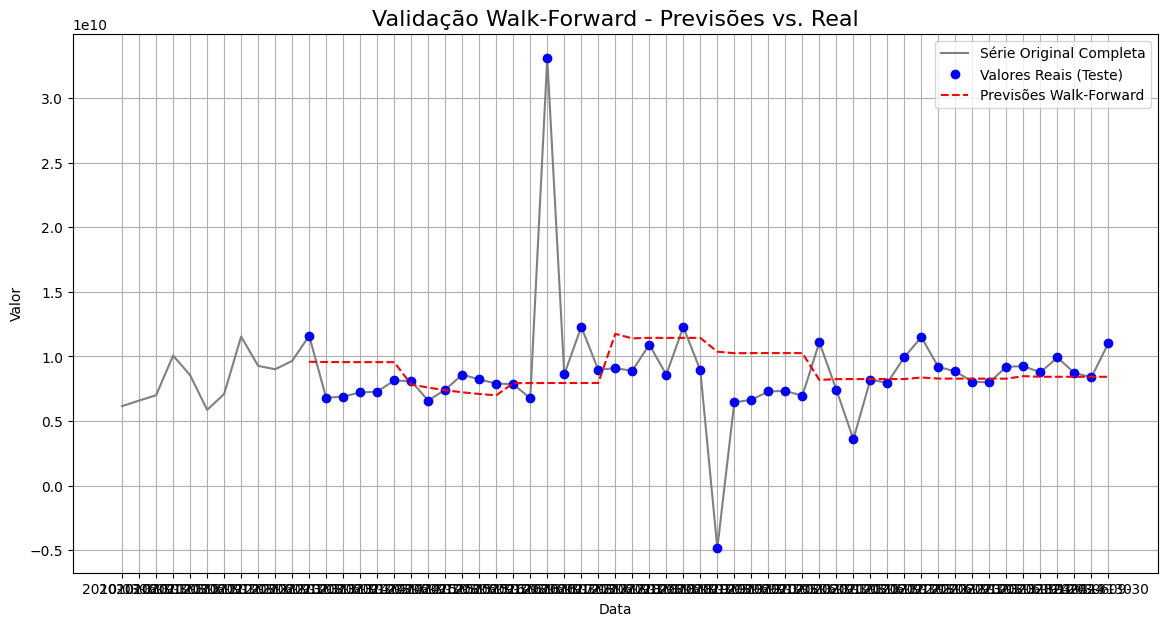


Empresa 18376 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 991206053.7826


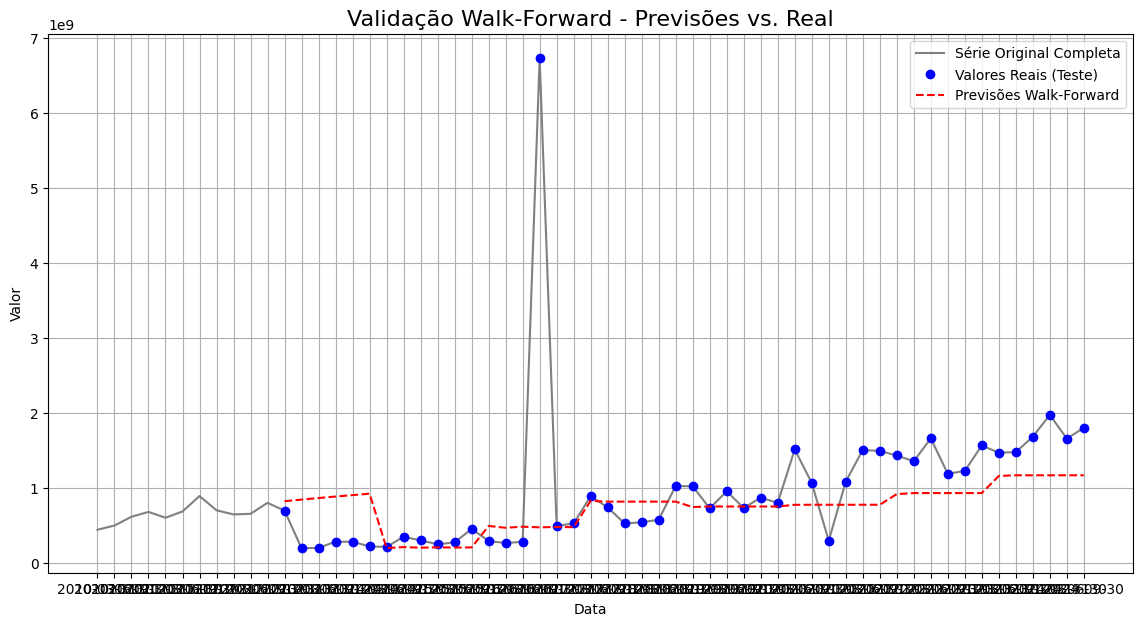


Empresa 20257 - Ordem ARIMA: [1, 1, 4]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 254771986.6279


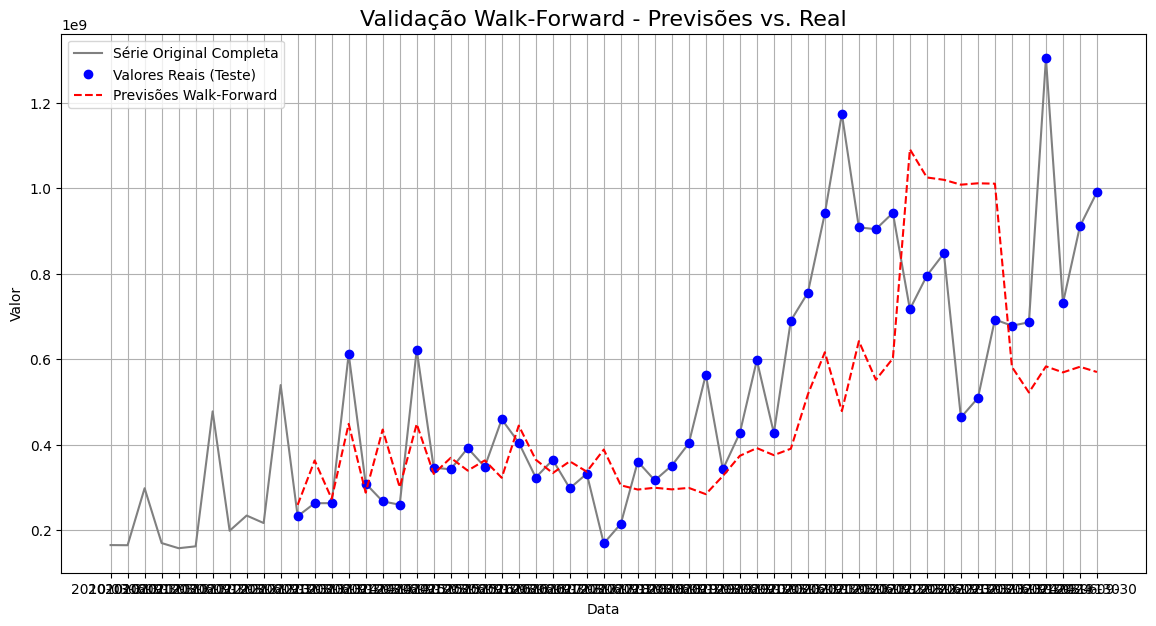


Empresa 21490 - Ordem ARIMA: [1, 1, 5]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 324265330.1498


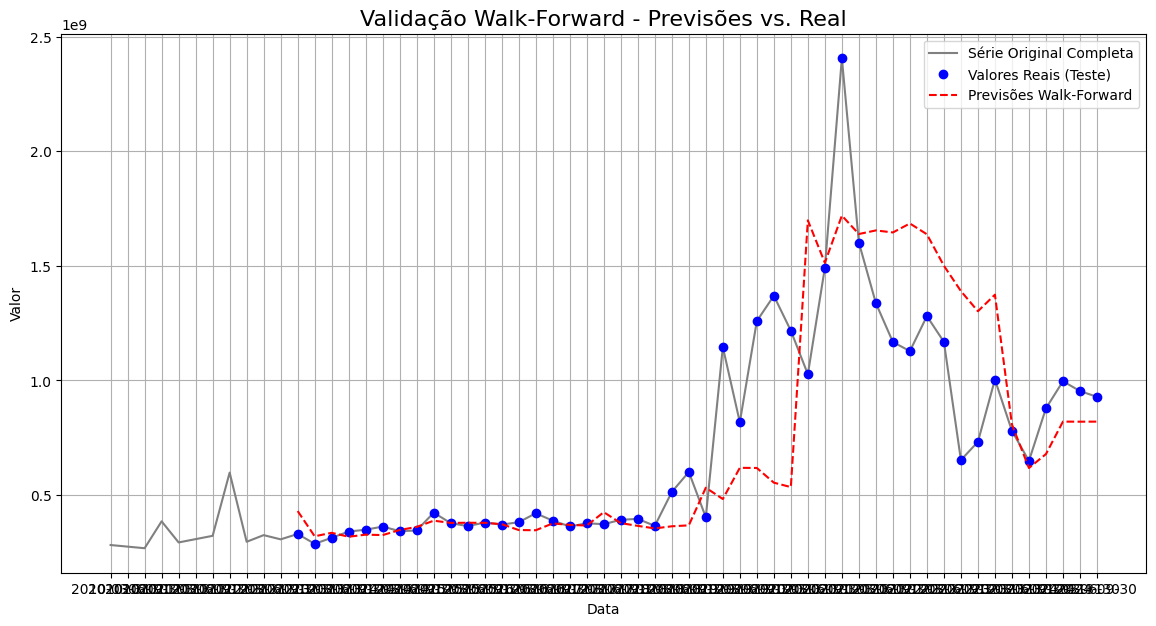

In [44]:
for empresa in resultado_bruto.keys():
    print(f"\nEmpresa {empresa} - Ordem ARIMA: {resultado_bruto_comp_arima.loc[empresa].tolist()}")
    walk_forward_arima(resultado_bruto[empresa], ordem_arima=resultado_bruto_comp_arima.loc[empresa].tolist(), n_splits=8)


Empresa 2437 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 5505185752.4664


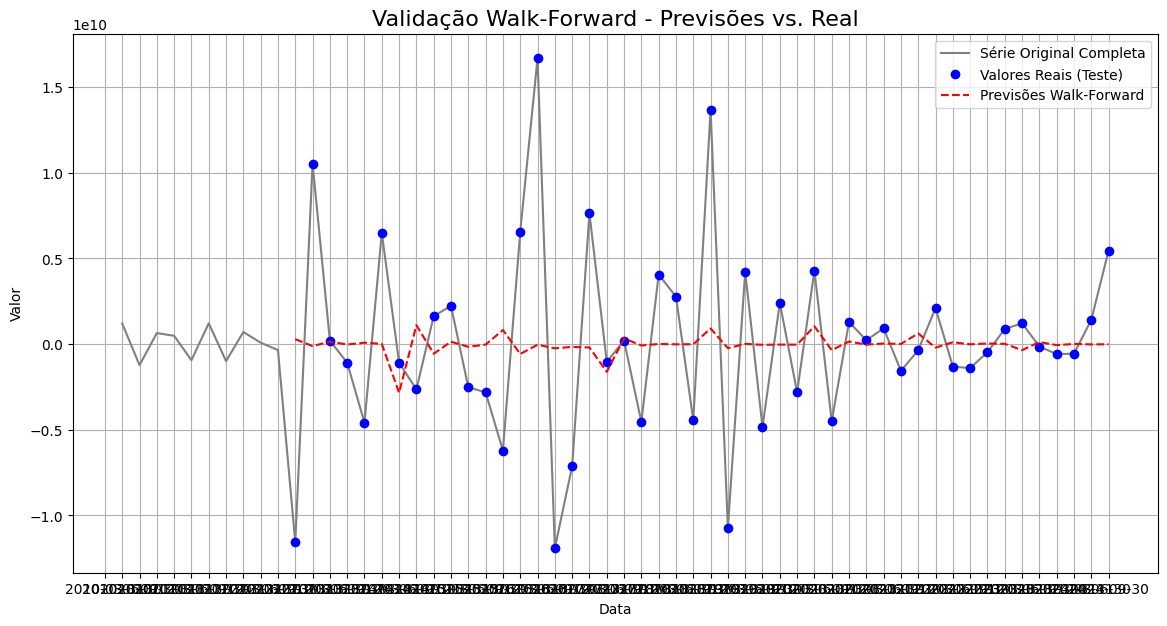


Empresa 18376 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 945400849.3011


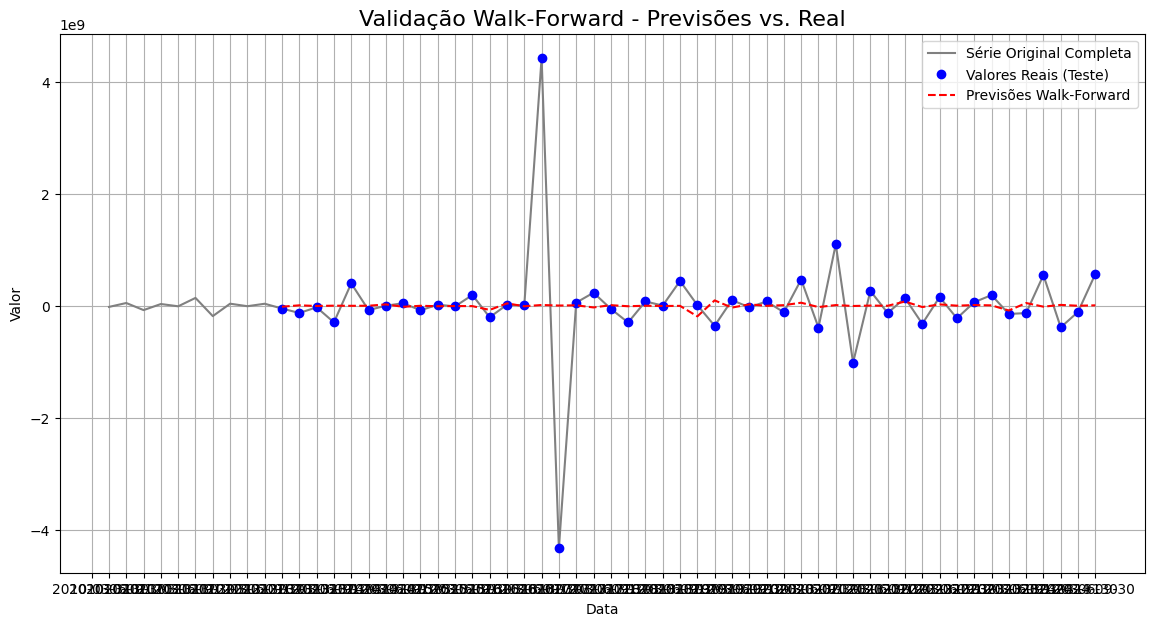


Empresa 20257 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 170840708.9582


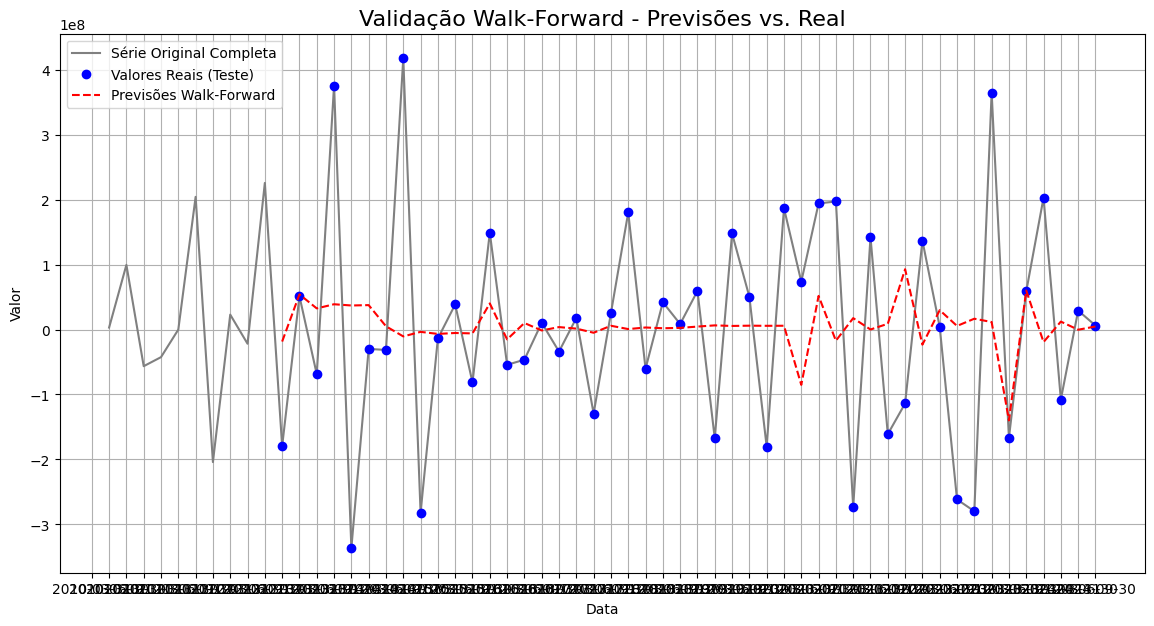


Empresa 21490 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 194167683.4203


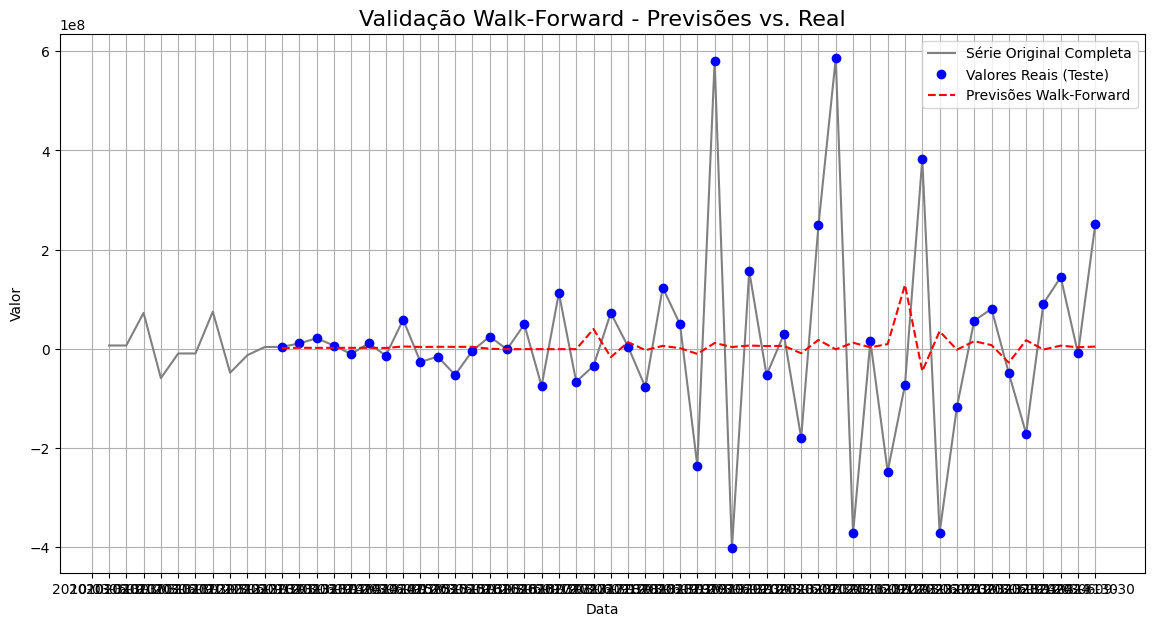

In [ ]:
for empresa in lucro_consolidado.keys():
    print(f"\nEmpresa {empresa} - Ordem ARIMA: {lucro_consolidado_comp_arima.loc[empresa].tolist()}")
    walk_forward_arima(lucro_consolidado[empresa], ordem_arima=lucro_consolidado_comp_arima.loc[empresa].tolist(), n_splits=8)


Empresa 2437 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 5828507800.1674


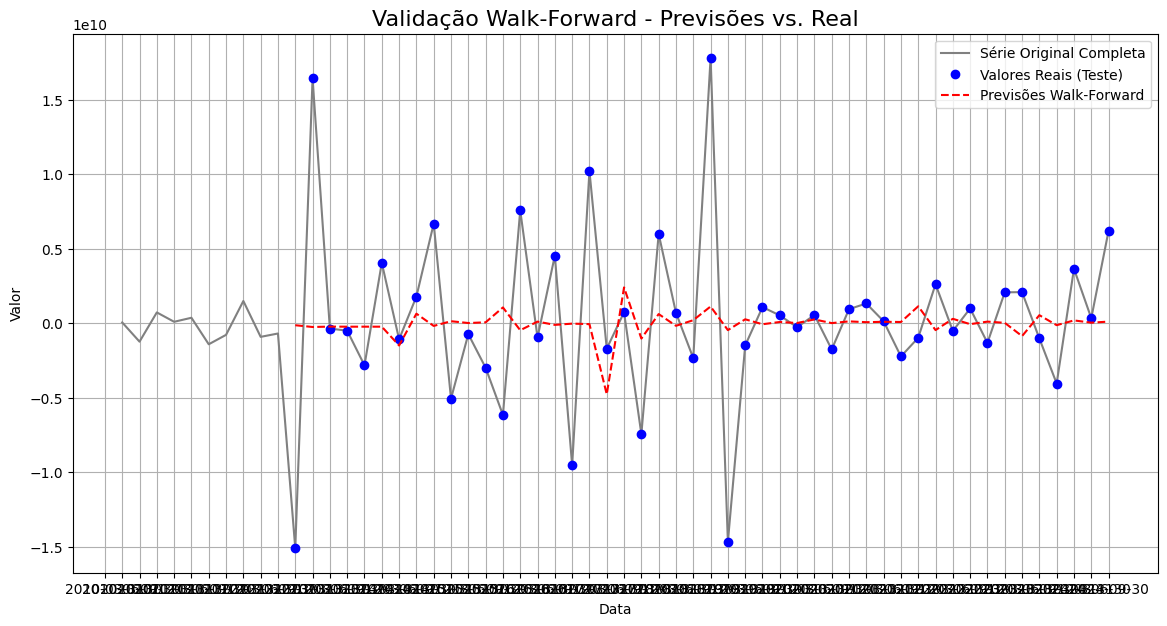


Empresa 18376 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 429809880.1807


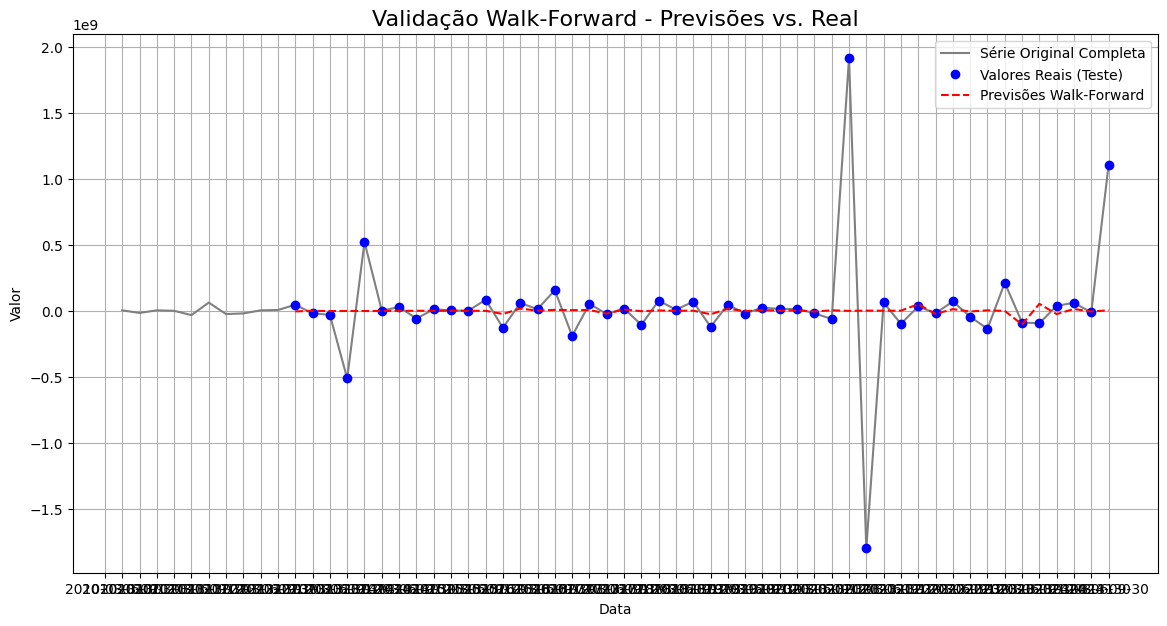


Empresa 20257 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 81292295.6322


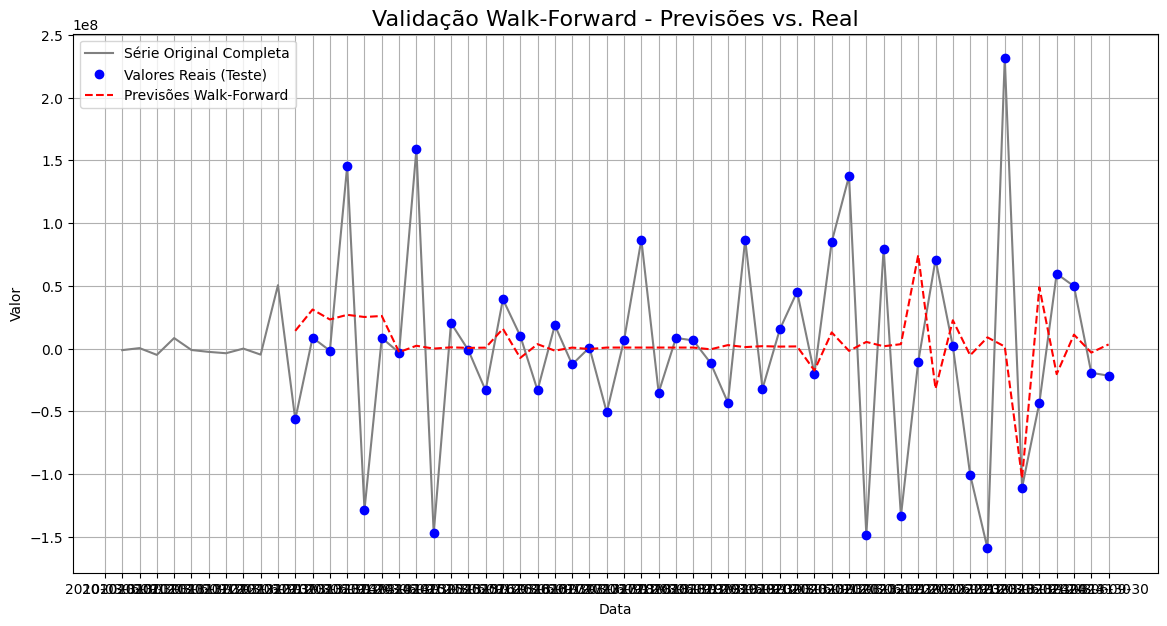


Empresa 21490 - Ordem ARIMA: [2, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 11, Tamanho do Teste: 6
--- Dobra 2/8 ---
Tamanho do Treino: 17, Tamanho do Teste: 6
--- Dobra 3/8 ---
Tamanho do Treino: 23, Tamanho do Teste: 6
--- Dobra 4/8 ---
Tamanho do Treino: 29, Tamanho do Teste: 6
--- Dobra 5/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 6
--- Dobra 6/8 ---
Tamanho do Treino: 41, Tamanho do Teste: 6
--- Dobra 7/8 ---
Tamanho do Treino: 47, Tamanho do Teste: 6
--- Dobra 8/8 ---
Tamanho do Treino: 53, Tamanho do Teste: 6

Validação Walk-Forward concluída.

RMSE Final (out-of-sample): 81204425.2713


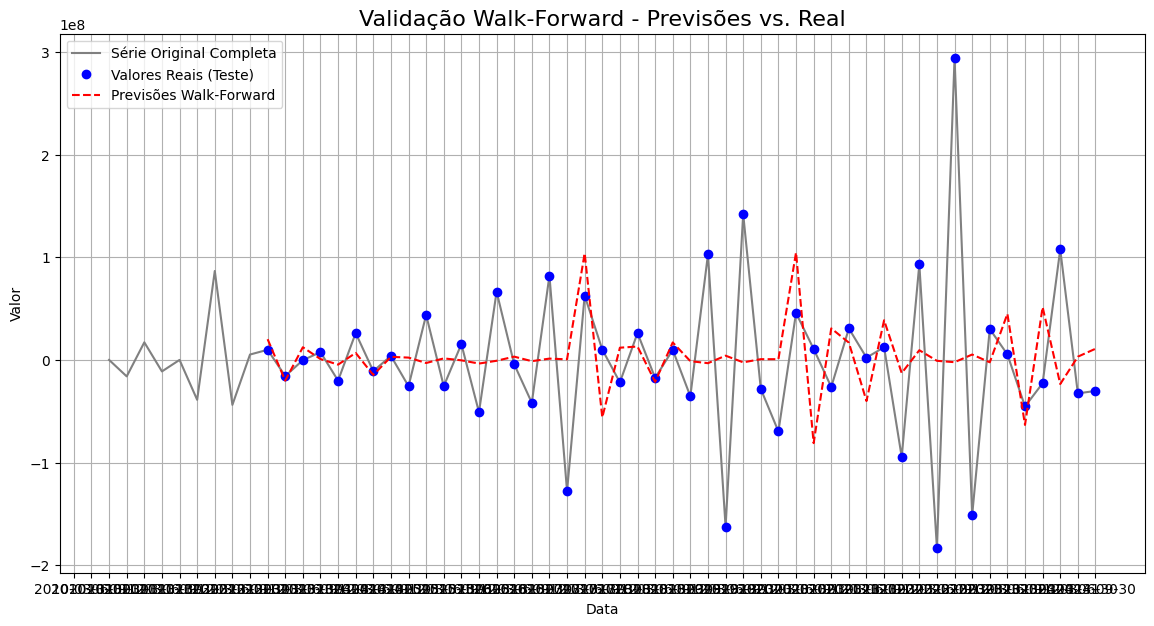

In [ ]:
for empresa in despesas_operacionais.keys():
    print(f"\nEmpresa {empresa} - Ordem ARIMA: {despesas_operacionais_comp_arima.loc[empresa].tolist()}")
    walk_forward_arima(despesas_operacionais[empresa], ordem_arima=despesas_operacionais_comp_arima.loc[empresa].tolist(), n_splits=8)

2 passos de previsão - não utilizado ainda

In [ ]:
# from tqdm import tqdm # Biblioteca para adicionar uma barra de progresso (útil para loops longos)


# serie = resultado_bruto[21490]


# # --- 2. Definição do Modelo e Configuração do Walk-Forward com Horizonte Fixo ---

# ordem_arima = (2, 1, 1)
# horizonte_previsao = 2 # <-- A MUDANÇA PRINCIPAL: queremos prever 2 passos à frente

# # Definir o tamanho do conjunto de treino inicial
# # Vamos usar os primeiros 5 anos (20 trimestres) para o primeiro treino
# tamanho_treino_inicial = 20

# # Listas para armazenar os resultados
# valores_reais = []
# previsoes_h2 = []
# indices_previsao = [] # Guardar os índices de data para o plot

# print(f"Iniciando a validação Walk-Forward para horizonte h={horizonte_previsao}...")
# # --- 3. O Loop de Validação Walk-Forward Manual ---
# # Iteramos a partir do final do treino inicial até o penúltimo ponto possível
# for i in tqdm(range(tamanho_treino_inicial, len(serie) - horizonte_previsao + 1)):
    
#     # 1. Separar os dados de treino da iteração atual
#     treino = serie.iloc[:i]
    
#     # 2. Treinar o modelo ARIMA com os dados de treino
#     modelo = sm.tsa.ARIMA(treino, order=ordem_arima)
#     modelo_ajustado = modelo.fit()
    
#     # 3. Fazer a previsão de 'horizonte_previsao' passos à frente
#     previsao_passos = modelo_ajustado.forecast(steps=horizonte_previsao)
    
#     # 4. Capturar APENAS a previsão do horizonte desejado (a segunda previsão)
#     previsao_final = previsao_passos.iloc[horizonte_previsao - 1]
    
#     # 5. Capturar o valor real correspondente
#     indice_real = i + horizonte_previsao - 1
#     valor_real = serie.iloc[indice_real]
    
#     # 6. Guardar os resultados
#     previsoes_h2.append(previsao_final)
#     valores_reais.append(valor_real)
#     indices_previsao.append(serie.index[indice_real])

# print("\nValidação Walk-Forward concluída.")

# # --- 4. Avaliação e Visualização dos Resultados ---

# # Calcular a métrica de erro final
# rmse_final_h2 = np.sqrt(mean_squared_error(valores_reais, previsoes_h2))
# print(f"\nRMSE Final para Horizonte h=2 (out-of-sample): {rmse_final_h2:.4f}")

# # Criar um DataFrame com os resultados para facilitar a visualização
# df_resultados_h2 = pd.DataFrame({
#     'Real': valores_reais,
#     'Previsao_h2': previsoes_h2
# }, index=indices_previsao)

# # Plotar os resultados
# plt.figure(figsize=(14, 7))
# plt.plot(serie, label='Série Original Completa', color='gray', alpha=0.6)
# plt.plot(df_resultados_h2['Real'], label='Valores Reais (Teste, h=2)', color='blue', marker='o', linestyle='None')
# plt.plot(df_resultados_h2['Previsao_h2'], label=f'Previsões Walk-Forward (h={horizonte_previsao})', color='red', linestyle='--')
# plt.title(f'Validação Walk-Forward - Horizonte de Previsão h={horizonte_previsao}', fontsize=16)
# plt.xlabel('Data')
# plt.ylabel('Valor')
# plt.legend()
# plt.grid(True)
# plt.show()

ARIMAX

Reorganizando indicadores - usados nos modelos

In [45]:
#meça o tamanho de todas as listas do dict_indicadores
tamanhos = {k: v.shape[0] for k, v in dict_indicadores.items()}
tamanhos

{2437: 59, 18376: 59, 20257: 59, 21490: 59}

Criando lags

In [46]:
dict_indicadores[empresa].columns

Index(['3.01', '3.02', '3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09',
       '3.11'],
      dtype='object')

In [47]:
#adicionar lags aos indicadores
df_lags_indicadores = {}
dict_indicadores_select = indicadores_estac.copy()

for empresa in dict_indicadores_select.keys(): 
    #Removendo indicadores que serão previstos nos modelos
    dict_indicadores_select[empresa].drop(columns=['3.01', '3.02', '3.11'], inplace=True)
    df_lags_indicadores[empresa] = adicionar_lags(dict_indicadores_select[empresa], lags=4)
    df_lags_indicadores[empresa] = df_lags_indicadores[empresa].iloc[8:]
    #renomear index
    print(df_lags_indicadores[empresa].columns)
    #normalizar os valores
    df_lags_indicadores[empresa] = (df_lags_indicadores[empresa] - df_lags_indicadores[empresa].mean()) / df_lags_indicadores[empresa].std()

#adicionar lags às entradas
df_lags_entradas = adicionar_lags(indices_estac, lags=8)
#df_lags_entradas = df_lags_entradas.iloc[4:]
#df_lags_entradas.set_index('data', inplace=True)


exog_vars_estac_lags = {}
for empresa in dict_indicadores.keys(): 
    #Removendo lags 0 dos indicadores, uma vez que não teremos estes valores
    dict_indicadores_select[empresa] = dict_indicadores_select[empresa].drop(columns=['3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09'])
    exog_vars_estac_lags[empresa] = pd.concat([dict_indicadores_select[empresa], df_lags_entradas], axis=1)
    exog_vars_estac_lags[empresa] = exog_vars_estac_lags[empresa].iloc[8:]
#antes de alimentar os modelos, dependendo da saída do modelo, tirar o indicador referente

Index(['3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09', '3.03_lag1',
       '3.04_lag1', '3.05_lag1', '3.06_lag1', '3.07_lag1', '3.08_lag1',
       '3.09_lag1', '3.03_lag2', '3.04_lag2', '3.05_lag2', '3.06_lag2',
       '3.07_lag2', '3.08_lag2', '3.09_lag2', '3.03_lag3', '3.04_lag3',
       '3.05_lag3', '3.06_lag3', '3.07_lag3', '3.08_lag3', '3.09_lag3',
       '3.03_lag4', '3.04_lag4', '3.05_lag4', '3.06_lag4', '3.07_lag4',
       '3.08_lag4', '3.09_lag4'],
      dtype='object')
Index(['3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09', '3.03_lag1',
       '3.04_lag1', '3.05_lag1', '3.06_lag1', '3.07_lag1', '3.08_lag1',
       '3.09_lag1', '3.03_lag2', '3.04_lag2', '3.05_lag2', '3.06_lag2',
       '3.07_lag2', '3.08_lag2', '3.09_lag2', '3.03_lag3', '3.04_lag3',
       '3.05_lag3', '3.06_lag3', '3.07_lag3', '3.08_lag3', '3.09_lag3',
       '3.03_lag4', '3.04_lag4', '3.05_lag4', '3.06_lag4', '3.07_lag4',
       '3.08_lag4', '3.09_lag4'],
      dtype='object')
Index(['3.03', '

In [48]:
exog_vars_estac_lags[2437].columns

Index(['data', 'ibov', 'iee', 'selic', 'vix', 'igpm', 'ipca', 'IPAOG-DI',
       'INCC-Brasil-DI', 'IIE-Br',
       ...
       'Câmbio Efetiva Real_lag8', 'Juros EUA_lag8', 'T-bonds_lag8',
       'Cotação Dólar_lag8', 'CDI_lag8', 'TJLP_lag8', 'Energia Res._lag8',
       'Energia Ind._lag8', 'Energia Com._lag8', 'Dívida/PIB_lag8'],
      dtype='object', length=423)

Escolher as variáveis a serem utilizadas

In [49]:
def montar_exog_filtradas(ranked_pairs, exog_vars_estac_lags, top_n=None, verbose=False):
    """
    Retorna um dicionário: exog_filtradas[empresa][indicador] = DataFrame com colunas filtradas.
    Colunas esperadas em exog_vars_estac_lags: 'indice' (lag 0) e 'indice_lagN' (N>=1).
    """
    rp = ranked_pairs.copy()
    if top_n is not None:
        rp = (rp.sort_values('Abs_CCF', ascending=False)
                .groupby(['Empresa', 'Indicador'])
                .head(top_n))

    exog_filtradas = {}
    for emp, df_emp in rp.groupby('Empresa'):
        base = exog_vars_estac_lags.get(emp)
        if base is None:
            continue
        exog_filtradas[emp] = {}
        for indicador, df_ind in df_emp.groupby('Indicador'):
            cols = []
            for _, row in df_ind.iterrows():
                indice = str(row['Indice'])
                lag = int(row['Lag'])
                col = indice if lag == 0 else f"{indice}_lag{lag}"
                # aceita 'indice' (lag0) ou 'indice_lag0' se existir
                if col in base.columns:
                    cols.append(col)
                elif lag == 0 and f"{indice}_lag0" in base.columns:
                    cols.append(f"{indice}_lag0")
            cols = sorted(pd.unique(cols))
            if cols:
                exog_filtradas[emp][indicador] = base[cols].copy()
                if verbose:
                    print(f"Empresa {emp} | Indicador {indicador}: {len(cols)} colunas -> {cols}")
    return exog_filtradas

In [ ]:
exog_filtradas = montar_exog_filtradas(ranked_pairs, exog_vars_estac_lags, top_n=15, verbose=True)

# Visualização rápida
exog_filtradas[21490]['3.11'].head()

Empresa 2437 | Indicador 3.01: 15 colunas -> ['Câmbio Real/Libra_lag1', 'Dívida/PIB_lag1', 'Energia Com._lag6', 'Energia Ind._lag7', 'Expec IIE-Br_lag6', 'IA Emp_lag6', 'IIE-Br_lag6', 'Mídia - IIE-Br_lag6', 'PIB Corrente_lag7', 'Var. IA Emp_lag7', 'Vol. Impostos_lag7', 'Vol. VA Serv. Sazonal_lag6', 'Vol. VA Serv. Trim. Saz._lag6', 'igpm_lag4', 'vix_lag5']
Empresa 2437 | Indicador 3.02: 15 colunas -> ['Cotação Dólar_lag6', 'Dívida/PIB_lag5', 'Energia Ind._lag6', 'IA Emp_lag6', 'PIB 1995_lag6', 'TJLP_lag2', 'Vol. PIB Mensal_lag6', 'Vol. PIB Trim. Saz._lag6', 'Vol. VA Produção_lag6', 'Vol. VA Serv. Sazonal_lag6', 'Vol. VA Serv. Trim. Saz._lag6', 'ibov_lag5', 'iee_lag5', 'ipca_lag8', 'vix_lag5']
Empresa 2437 | Indicador 3.11: 15 colunas -> ['Câmbio Real/Dólar_lag7', 'Câmbio Real/Peso', 'Energia Com._lag7', 'Energia Ind._lag5', 'Expec IIE-Br_lag6', 'INCC-Brasil-DI_lag8', 'IPAOG-DI_lag7', 'Vol. Impostos_lag1', 'Vol. VA Ind. Sazonal_lag7', 'Vol. VA Ind. Trim. Saz._lag7', 'Vol. VA Indústria_la

Câmbio Real/Dólar_lag7  Câmbio Real/Peso  Energia Com._lag7  \
2012-06-30               -2.246667         42.390000        -251.666667   
2012-09-30               -2.416667         42.080000         506.333333   
2012-12-31               -0.913333         41.783333         367.666667   
2013-03-31               -1.456667         39.590000        -312.000000   
2013-06-30                1.260000         40.776667        -123.666667   

            Energia Ind._lag5  Expec IIE-Br_lag6  INCC-Brasil-DI_lag8  \
2012-06-30        -592.333333         103.533333                  NaN   
2012-09-30         611.333333          92.833333            -1.929333   
2012-12-31         348.000000          95.366667            -4.689667   
2013-03-31        -194.333333          90.333333             2.121667   
2013-06-30        -410.666667          96.166667            10.380000   

            IPAOG-DI_lag7  Vol. Impostos_lag1  Vol. VA Ind. Sazonal_lag7  \
2012-06-30      13.102333           -5.515000                   0.124333   
2012-09-30      19.624000            4.667667                   2.494333   
2012-12-31      13.283000            6.403333                   1.695667   
2013-03-31       2.765667            5.213333                   2.740333   
2013-06-30       1.727667          -10.876667                  -1.470000   

            Vol. VA Ind. Trim. Saz._lag7  Vol. VA Indústria_lag5  \
2012-06-30                         0.076               -9.310333   
2012-09-30                         2.151               10.804667   
2012-12-31                         0.616                5.434000   
2013-03-31                         4.482               -4.209000   
2013-06-30                        -1.585               -8.742333   

            Vol. VA Sazonal_lag7      iee  igpm_lag7  vix_lag5  
2012-06-30              1.283333   134.60   0.020817     17.74  
2012-09-30              2.222333 -5325.05   0.031817     16.52  
2012-12-31              1.490333 -1298.39   0.024290     42.96  
2013-03-31              1.515333 -1042.28   0.007003     23.40  
2013-06-30              0.209667 -2343.23   0.009715     15.50

In [152]:
exog_filtradas[21490]['3.01'] = exog_filtradas[21490]['3.01'].interpolate(method='linear', limit_direction='both')

Retira multicolinearidade - VIF

In [153]:
def calcular_vif_iterativo(df, thresh=5.0, max_iter=100, verbose=True):
    """
    Calcula VIF iterativamente removendo a variável com maior VIF até que todos fiquem <= thresh.
    Retorna:
      - df_filtrado: DataFrame final após remoções
      - vif_final: Series com VIF das variáveis remanescentes
      - removidas: DataFrame com ordem de remoção e VIF no momento da remoção
    """
    # Copiar e manter apenas colunas numéricas
    df_work = df.select_dtypes(include=[np.number]).copy()

    # Remover colunas constantes ou quase-constantes
    const_cols = [c for c in df_work.columns if df_work[c].nunique(dropna=True) <= 1]
    if const_cols and verbose:
        print(f"Removendo colunas constantes: {const_cols}")
    df_work.drop(columns=const_cols, inplace=True, errors='ignore')

    # # Limpeza de dados: remover linhas com NaN/Inf
    # df_work = df_work.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how='any')

    removidas = []
    it = 0
    while it < max_iter and df_work.shape[1] > 1:
        it += 1
        X = sm.add_constant(df_work, has_constant='add')
        vifs = []
        for i, col in enumerate(X.columns):
            try:
                val = variance_inflation_factor(X.values, i)
            except Exception:
                val = np.inf
            vifs.append(val)
        vif = pd.Series(vifs, index=X.columns)

        # descartar a constante
        if 'const' in vif.index:
            vif = vif.drop('const', errors='ignore')

        # Se todas as variáveis estão abaixo do limiar, parar
        max_v = vif.max()
        if pd.isna(max_v) or max_v <= thresh:
            if verbose:
                print("\nTodos os VIFs estão abaixo do limite.")
            break

        # Remover a variável com maior VIF (inclusive se for inf)
        col_remover = vif.idxmax()
        if verbose:
            print(f"Removendo '{col_remover}' com VIF de {max_v:.2f}")
        removidas.append({'variavel': col_remover, 'vif': float(max_v), 'iter': it})
        df_work = df_work.drop(columns=[col_remover])

        # Se sobrar 1 coluna, não há por que continuar
        if df_work.shape[1] <= 1:
            break

    # VIF final das variáveis remanescentes
    if df_work.shape[1] >= 1:
        Xf = sm.add_constant(df_work, has_constant='add')
        vifs_final = []
        for i, col in enumerate(Xf.columns):
            try:
                val = variance_inflation_factor(Xf.values, i)
            except Exception:
                val = np.inf
            vifs_final.append(val)
        vif_final = pd.Series(vifs_final, index=Xf.columns).drop('const', errors='ignore').sort_values(ascending=False)
    else:
        vif_final = pd.Series(dtype=float)

    removidas_df = pd.DataFrame(removidas)
    if verbose:
        print("\nDataFrame final após remoção por VIF:")
        display(df_work.head())
        print("\nValores finais de VIF:")
        display(vif_final)

    return df_work, vif_final, removidas_df




# ...existing code...

In [154]:
# Exemplo: aplicar em todos os dataframes de exog_vars_estac
vif_filtrados = {}
vif_finais = {}
vif_remocoes = {}

for empresa, df_exog in exog_filtradas.items():
    print(f"\n=== Empresa {empresa} ===")
    df_filtrado, vif_final, removidas = calcular_vif_iterativo(df_exog['3.01'], thresh=5.0, verbose=True)
    vif_filtrados[empresa] = df_filtrado
    vif_finais[empresa] = vif_final
    vif_remocoes[empresa] = removidas


=== Empresa 2437 ===
Removendo 'Vol. VA Serv. Sazonal_lag6' com VIF de 27.08
Removendo 'Vol. Impostos_lag7' com VIF de 13.03
Removendo 'Expec IIE-Br_lag6' com VIF de 5.30

Todos os VIFs estão abaixo do limite.

DataFrame final após remoção por VIF:


Câmbio Real/Libra_lag1  Dívida/PIB_lag1  Energia Com._lag6  \
2012-06-30               -0.396667        -0.156667         506.333333   
2012-09-30                4.050000        -1.786667         367.666667   
2012-12-31               -0.400000        -0.440000        -312.000000   
2013-03-31                0.843333        -0.340000        -123.666667   
2013-06-30               -2.916667         0.150000         404.666667   

            Energia Ind._lag7  IA Emp_lag6  IIE-Br_lag6  Mídia - IIE-Br_lag6  \
2012-06-30         346.333333    93.500000     0.200000            96.900000   
2012-09-30         -82.000000    92.633333    -1.233333            98.133333   
2012-12-31        -592.333333    90.500000    -0.800000            96.566667   
2013-03-31         611.333333    86.166667     9.466667           108.600000   
2013-06-30         348.000000    86.133333     0.533333           107.733333   

            PIB Corrente_lag7  Var. IA Emp_lag7  \
2012-06-30       13491.000000         -0.526667   
2012-09-30        1881.666667         -0.210000   
2012-12-31      -33425.000000         -0.206667   
2013-03-31       37007.333333         -1.170000   
2013-06-30      -14853.000000         -1.620000   

            Vol. VA Serv. Trim. Saz._lag6  igpm_lag4  vix_lag5  
2012-06-30                          1.691   0.007003     17.74  
2012-09-30                          2.020   0.009715     16.52  
2012-12-31                          0.901   0.009114     42.96  
2013-03-31                         -0.010   0.006207     23.40  
2013-06-30                          0.888   0.025511     15.50


Valores finais de VIF:


Vol. VA Serv. Trim. Saz._lag6    3.682907
Energia Ind._lag7                3.486751
IIE-Br_lag6                      3.216510
PIB Corrente_lag7                2.352467
Câmbio Real/Libra_lag1           2.176743
Dívida/PIB_lag1                  2.014928
Var. IA Emp_lag7                 1.864047
igpm_lag4                        1.836464
Energia Com._lag6                1.826467
IA Emp_lag6                      1.724318
Mídia - IIE-Br_lag6              1.649156
vix_lag5                         1.204539
dtype: float64


=== Empresa 18376 ===

DataFrame final após remoção por VIF:


Câmbio Real/Libra
2012-06-30           4.050000
2012-09-30          -0.400000
2012-12-31           0.843333
2013-03-31          -2.916667
2013-06-30           1.313333


Valores finais de VIF:


Câmbio Real/Libra    1.0
dtype: float64


=== Empresa 20257 ===
Removendo 'Vol. PIB Mensal_lag6' com VIF de 140861274.60
Removendo 'PIB 1995_lag6' com VIF de 65689.30
Removendo 'Vol. Impostos_lag6' com VIF de 20.72
Removendo 'Energia Ind._lag6' com VIF de 6.51

Todos os VIFs estão abaixo do limite.

DataFrame final após remoção por VIF:


INCC-Brasil-DI_lag3  T-bonds_lag1  Vol. VA Indústria  \
2012-06-30            -7.777000      0.096667           2.784333   
2012-09-30            -4.275333     -0.203333           9.457667   
2012-12-31             3.422333     -0.190000          -5.608000   
2013-03-31             5.689333      0.113333          -8.646000   
2013-06-30            -3.065333      0.276667          11.192000   

            Vol. VA Produção_lag6  Vol. VA Serviços_lag6  ipca_lag6  
2012-06-30              -0.502333               3.300333   0.022262  
2012-09-30              -2.798333              -5.506000   0.024396  
2012-12-31               5.891000               4.405333   0.013955  
2013-03-31               2.896000               2.461333   0.010634  
2013-06-30              -2.061667               2.155667   0.014570


Valores finais de VIF:


Vol. VA Serviços_lag6    2.706685
Vol. VA Produção_lag6    2.300521
Vol. VA Indústria        1.740720
INCC-Brasil-DI_lag3      1.708427
ipca_lag6                1.317474
T-bonds_lag1             1.254258
dtype: float64


=== Empresa 21490 ===
Removendo 'Vol. VA Ind. Sazonal_lag6' com VIF de 43.20
Removendo 'Vol. Impostos_lag5' com VIF de 33.54
Removendo 'Vol. VA Agro Trim. Saz._lag4' com VIF de 23.65
Removendo 'Energia Ind._lag5' com VIF de 8.09
Removendo 'igpm_lag6' com VIF de 7.72

Todos os VIFs estão abaixo do limite.

DataFrame final após remoção por VIF:


INCC-Brasil-DI_lag8  IPAOG-DI_lag6  Juros EUA_lag5  \
2012-06-30            -1.929333      19.624000       -0.030000   
2012-09-30            -1.929333      13.283000       -0.063333   
2012-12-31            -4.689667       2.765667       -0.010000   
2013-03-31             2.121667       1.727667       -0.010000   
2013-06-30            10.380000       6.920333        0.030000   

            PIB Corrente_lag6  Vol. PIB Mensal_lag5  \
2012-06-30        1881.666667             -3.097667   
2012-09-30      -33425.000000              5.879000   
2012-12-31       37007.333333              3.084333   
2013-03-31      -14853.000000             -1.666000   
2013-06-30        7615.666667             -4.558000   

            Vol. VA Agro Sazonal_lag4  Vol. VA Ind. Trim. Saz._lag6  \
2012-06-30                  -4.330333                         2.151   
2012-09-30                   7.192000                         0.616   
2012-12-31                  12.482000                         4.482   
2013-03-31                 -37.462000                        -1.585   
2013-06-30                  19.851333                        -0.409   

            Vol. VA Serviços_lag5  ibov_lag4  iee_lag5  
2012-06-30              -5.506000    -6183.0   2649.56  
2012-09-30               4.405333   -10080.0    181.64  
2012-12-31               2.461333     4430.0  -2263.11  
2013-03-31               2.155667     7757.0   4803.05  
2013-06-30              -5.478333   -10156.0   2667.97


Valores finais de VIF:


Vol. VA Serviços_lag5           3.164731
Vol. PIB Mensal_lag5            3.132506
INCC-Brasil-DI_lag8             1.531779
Vol. VA Ind. Trim. Saz._lag6    1.487560
ibov_lag4                       1.430039
PIB Corrente_lag6               1.346308
iee_lag5                        1.325005
Vol. VA Agro Sazonal_lag4       1.216921
IPAOG-DI_lag6                   1.208647
Juros EUA_lag5                  1.193387
dtype: float64

Teste modelo Arimax

In [155]:
def gera_modelo_arimax(serie_temporal, df_componentes, exog_dict):
    modelos_arimax = {}

    for cd_cvm in df_componentes.index:
        series = serie_temporal.copy()[cd_cvm]
        exog_vars = exog_dict.get(cd_cvm).copy()
        n = len(series)
        split_point = int(n * 0.8)  # 80% dos dados para treino
        print(f"CD_CVM: {cd_cvm}, Length: {n}, Split Point: {split_point}")
        p = df_componentes.loc[cd_cvm, 'AR(p)']
        q = df_componentes.loc[cd_cvm, 'MA(q)']
        i = df_componentes.loc[cd_cvm, 'I(d)']
        order = (p, i, q)

        serie = series.iloc[:split_point]
        
        exog_vars = exog_vars.iloc[:split_point]

        try:
            print(f"Serie: {serie.shape}, Exog: {exog_vars.shape}, Order: {order}")
            modelo = ARIMA(serie, order=order, exog=exog_vars).fit()
            modelos_arimax[cd_cvm] = modelo
            #print(f'Modelo ARIMAX({p}, {i}, {q}) para CD_CVM {cd_cvm} ajustado com sucesso.')
            print(modelo.summary())
        except Exception as e:
            print(f'Erro ao ajustar modelo ARIMAX para CD_CVM {cd_cvm}: {str(e)}')
        
    return modelos_arimax

In [156]:
vif_finais[2437].keys()

Index(['Vol. VA Serv. Trim. Saz._lag6', 'Energia Ind._lag7', 'IIE-Br_lag6',
       'PIB Corrente_lag7', 'Câmbio Real/Libra_lag1', 'Dívida/PIB_lag1',
       'Var. IA Emp_lag7', 'igpm_lag4', 'Energia Com._lag6', 'IA Emp_lag6',
       'Mídia - IIE-Br_lag6', 'vix_lag5'],
      dtype='object')

In [157]:
input_receita = {}
for empresa in exog_filtradas.keys():
    input_receita[empresa] = exog_filtradas[empresa]['3.01']

In [159]:
#usar vif_filtrados para dados sem multicolineariade ou input_receita para dados que não passaram pelo VIF
modelo_arimax_resultado_bruto = gera_modelo_arimax(resultado_bruto[9:], resultado_bruto_comp_arima, vif_filtrados)

CD_CVM: 2437, Length: 50, Split Point: 40
Serie: (40,), Exog: (40, 12), Order: (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                   2437   No. Observations:                   40
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -929.973
Date:                Sun, 21 Sep 2025   AIC                           1889.946
Time:                        14:56:59   BIC                           1914.899
Sample:                    06-30-2012   HQIC                          1898.899
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Câmbio Real/Libra_lag1        -2.023e+08   3940.256  -5.13e+04      0.000   -2.02e+

In [194]:
def walk_forward_arimax(serie, ordem_arima, n_splits=8, input_exog=None):

    # Configurando o TimeSeriesSplit
    # Vamos dividir os dados em 8 janelas de teste. A janela de treino irá crescer a cada passo.
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar os resultados de cada dobra da validação
    valores_reais = []
    previsoes = []

    print("Iniciando a validação Walk-Forward...")
    # --- 3. O Loop de Validação Walk-Forward ---
    # O tscv.split(serie) gera os índices de treino e teste para cada dobra
    for i, (train_index, test_index) in enumerate(tscv.split(serie)):
        print(f"--- Dobra {i+1}/{n_splits} ---")
        
        # 1. Separar os dados de treino e teste da dobra atual
        treino = serie.iloc[train_index]
        treino_exog = input_exog.iloc[train_index]
        teste = serie.iloc[test_index]
        teste_exog = input_exog.iloc[test_index]
        print(f"Tamanho do Treino: {len(treino)}, Tamanho do Teste: {len(teste)}")
        
        # 2. Treinar o modelo ARIMA APENAS com os dados de treino
        # O modelo é retreinado a cada passo com mais dados, simulando a realidade
        modelo = sm.tsa.ARIMA(treino, order=ordem_arima, exog=treino_exog)
        modelo_ajustado = modelo.fit()
        
        # 3. Fazer a previsão para o período de teste
        # O número de passos da previsão é o tamanho do conjunto de teste
        previsao = modelo_ajustado.forecast(steps=len(teste), exog=teste_exog)
        
        # 4. Guardar os resultados
        previsoes.extend(previsao)
        valores_reais.extend(teste)

    #iterar modelo ARIMAX removendo componentes que não são significativos´
    print(modelo_ajustado.summary())

    # --- 4. Avaliação e Visualização dos Resultados ---
    # Calcular a métrica de erro final sobre todos os pontos previstos
    rmse_final = np.sqrt(mean_squared_error(valores_reais, previsoes))
    print(f"\nRMSE Final (out-of-sample): {rmse_final:.4f}")

    # Criar um DataFrame com os resultados para facilitar a visualização
    df_resultados = pd.DataFrame({
        'Real': valores_reais,
        'Previsao': previsoes
    }, index=serie.index[-len(valores_reais):]) # Garante que o índice de datas está correto

    # Plotar os resultados

    plt.figure(figsize=(14, 7))
    plt.plot(serie, label='Série Original Completa', color='gray')
    plt.plot(df_resultados['Real'], label='Valores Reais (Teste)', color='blue', marker='o', linestyle='None')
    plt.plot(df_resultados['Previsao'], label='Previsões Walk-Forward', color='red', linestyle='--')
    plt.title('Validação Walk-Forward - Previsões vs. Real', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rmse_final, modelo_ajustado

In [197]:
def walk_forward_arimax_one_step(serie, ordem_arima, tamanho_treino_inicial, input_exog=None):
    """
    Realiza a validação walk-forward prevendo apenas um passo à frente por vez.

    Parâmetros:
    - serie: A série temporal completa (Pandas Series).
    - ordem_arima: A ordem (p, d, q) do modelo ARIMA.
    - tamanho_treino_inicial: O número de observações para o primeiro treino.
    - input_exog: DataFrame com as variáveis exógenas.
    """
    # Listas para armazenar os resultados
    valores_reais = []
    previsoes = []
    
    # O número total de previsões que faremos
    n_previsoes = len(serie) - tamanho_treino_inicial

    print(f"Iniciando a validação Walk-Forward (One-Step-Ahead)...")
    print(f"Tamanho do treino inicial: {tamanho_treino_inicial}, Número de previsões a fazer: {n_previsoes}")

    # --- O Novo Loop de Validação ---
    # Este loop itera para cada ponto que queremos prever
    for i in range(n_previsoes):
        # O índice do ponto atual no DataFrame original
        indice_atual = tamanho_treino_inicial + i
        
        # 1. Separar os dados de treino
        # O treino contém todos os dados até o ponto ANTERIOR ao que queremos prever
        treino = serie.iloc[:indice_atual]
        treino_exog = input_exog.iloc[:indice_atual]
        
        # O valor real é o ponto exato que estamos tentando prever
        valor_real = serie.iloc[indice_atual]
        
        # A variável exógena para a previsão precisa ser a do momento da previsão
        teste_exog = input_exog.iloc[indice_atual:indice_atual+1]

        # Imprimir progresso para não parecer que travou (este processo é lento)
        if (i + 1) % 10 == 0 or (i + 1) == n_previsoes:
             print(f"--- Prevendo passo {i+1}/{n_previsoes} (Treinando com {len(treino)} observações) ---")
        
        # 2. Treinar o modelo ARIMA com a janela de treino atual
        modelo = sm.tsa.ARIMA(treino, order=ordem_arima, exog=treino_exog)
        modelo_ajustado = modelo.fit()
        
        # 3. Fazer a previsão de APENAS UM PASSO à frente
        previsao = modelo_ajustado.forecast(steps=1, exog=teste_exog)
        
        # 4. Guardar os resultados
        previsoes.append(previsao.iloc[0]) # .iloc[0] para pegar o valor escalar da previsão
        valores_reais.append(valor_real)

    print("\nValidação Walk-Forward concluída.")
    
    # O restante do código para avaliação e plotagem permanece o mesmo
    rmse_final = np.sqrt(mean_squared_error(valores_reais, previsoes))
    print(f"RMSE Final (out-of-sample): {rmse_final:.4f}")

    df_resultados = pd.DataFrame({
        'Real': valores_reais,
        'Previsao': previsoes
    }, index=serie.index[-len(valores_reais):])

    plt.figure(figsize=(14, 7))
    plt.plot(serie, label='Série Original Completa', color='gray', alpha=0.6)
    plt.plot(df_resultados['Real'], label='Valores Reais (Teste)', color='blue', marker='o', linestyle='None', markersize=5)
    plt.plot(df_resultados['Previsao'], label='Previsões One-Step-Ahead', color='red', linestyle='--')
    plt.title('Validação Walk-Forward (One-Step-Ahead) - Previsões vs. Real', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rmse_final, modelo_ajustado

In [176]:
resultado_bruto_comp_arima

I(d)  AR(p)  MA(q)
2437      1      1      1
18376     1      1      1
20257     1      1      4
21490     1      1      5


Empresa 2437 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 10, Tamanho do Teste: 5
--- Dobra 2/8 ---
Tamanho do Treino: 15, Tamanho do Teste: 5
--- Dobra 3/8 ---
Tamanho do Treino: 20, Tamanho do Teste: 5
--- Dobra 4/8 ---
Tamanho do Treino: 25, Tamanho do Teste: 5
--- Dobra 5/8 ---
Tamanho do Treino: 30, Tamanho do Teste: 5
--- Dobra 6/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 5
--- Dobra 7/8 ---
Tamanho do Treino: 40, Tamanho do Teste: 5
--- Dobra 8/8 ---
Tamanho do Treino: 45, Tamanho do Teste: 5
                               SARIMAX Results                                
Dep. Variable:                   2437   No. Observations:                   45
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1046.659
Date:                Tue, 23 Sep 2025   AIC                           2129.318
Time:                        20:17:59   BIC                           2161.433
Sample:                    06-30-2012   

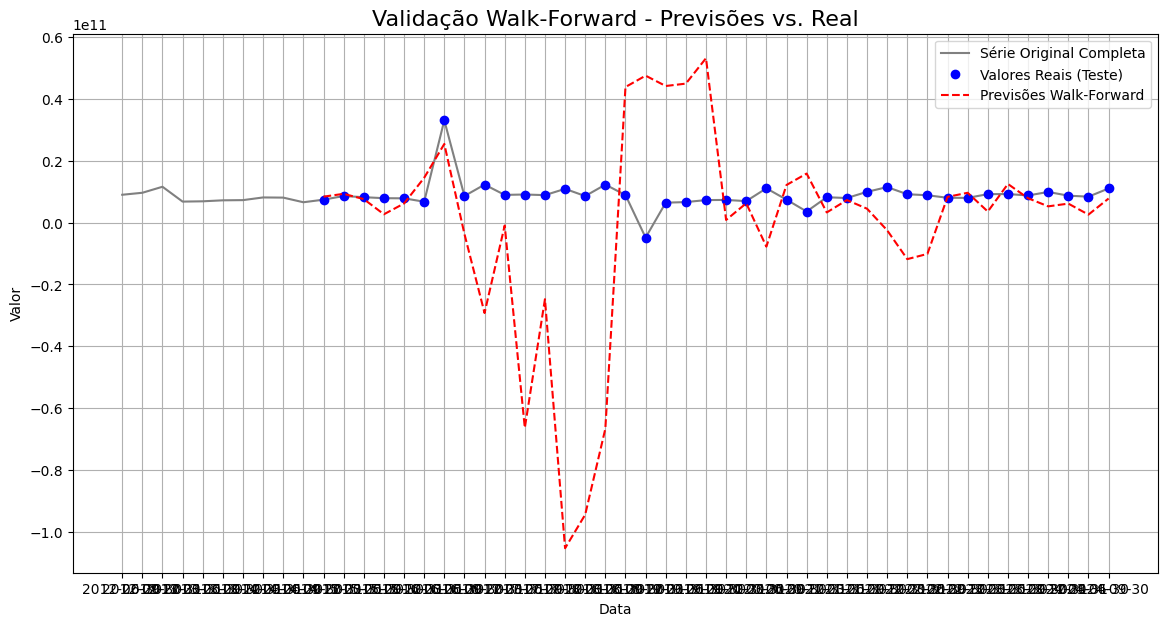


Empresa 18376 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 10, Tamanho do Teste: 5
--- Dobra 2/8 ---
Tamanho do Treino: 15, Tamanho do Teste: 5
--- Dobra 3/8 ---
Tamanho do Treino: 20, Tamanho do Teste: 5
--- Dobra 4/8 ---
Tamanho do Treino: 25, Tamanho do Teste: 5
--- Dobra 5/8 ---
Tamanho do Treino: 30, Tamanho do Teste: 5
--- Dobra 6/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 5
--- Dobra 7/8 ---
Tamanho do Treino: 40, Tamanho do Teste: 5
--- Dobra 8/8 ---
Tamanho do Treino: 45, Tamanho do Teste: 5
                               SARIMAX Results                                
Dep. Variable:                  18376   No. Observations:                   45
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -972.824
Date:                Tue, 23 Sep 2025   AIC                           1953.649
Time:                        20:18:00   BIC                           1960.786
Sample:                    06-30-2012  

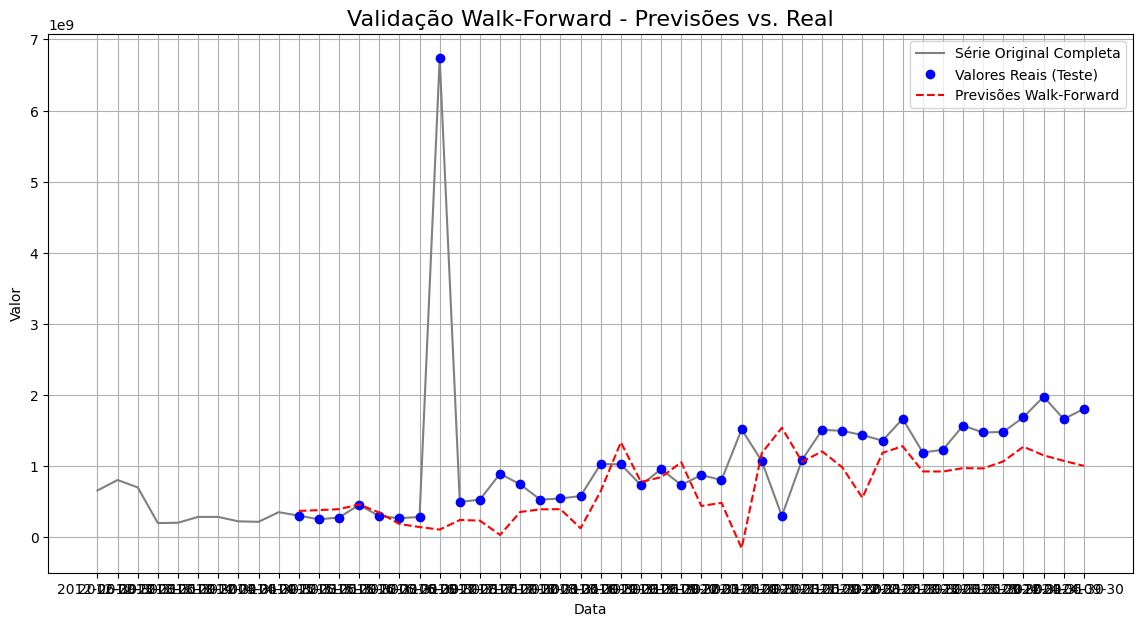


Empresa 20257 - Ordem ARIMA: [1, 1, 4]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 10, Tamanho do Teste: 5
--- Dobra 2/8 ---
Tamanho do Treino: 15, Tamanho do Teste: 5
--- Dobra 3/8 ---
Tamanho do Treino: 20, Tamanho do Teste: 5
--- Dobra 4/8 ---
Tamanho do Treino: 25, Tamanho do Teste: 5
--- Dobra 5/8 ---
Tamanho do Treino: 30, Tamanho do Teste: 5
--- Dobra 6/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 5
--- Dobra 7/8 ---
Tamanho do Treino: 40, Tamanho do Teste: 5
--- Dobra 8/8 ---
Tamanho do Treino: 45, Tamanho do Teste: 5
                               SARIMAX Results                                
Dep. Variable:                  20257   No. Observations:                   45
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -884.175
Date:                Tue, 23 Sep 2025   AIC                           1800.350
Time:                        20:18:03   BIC                           1828.897
Sample:                    06-30-2012  

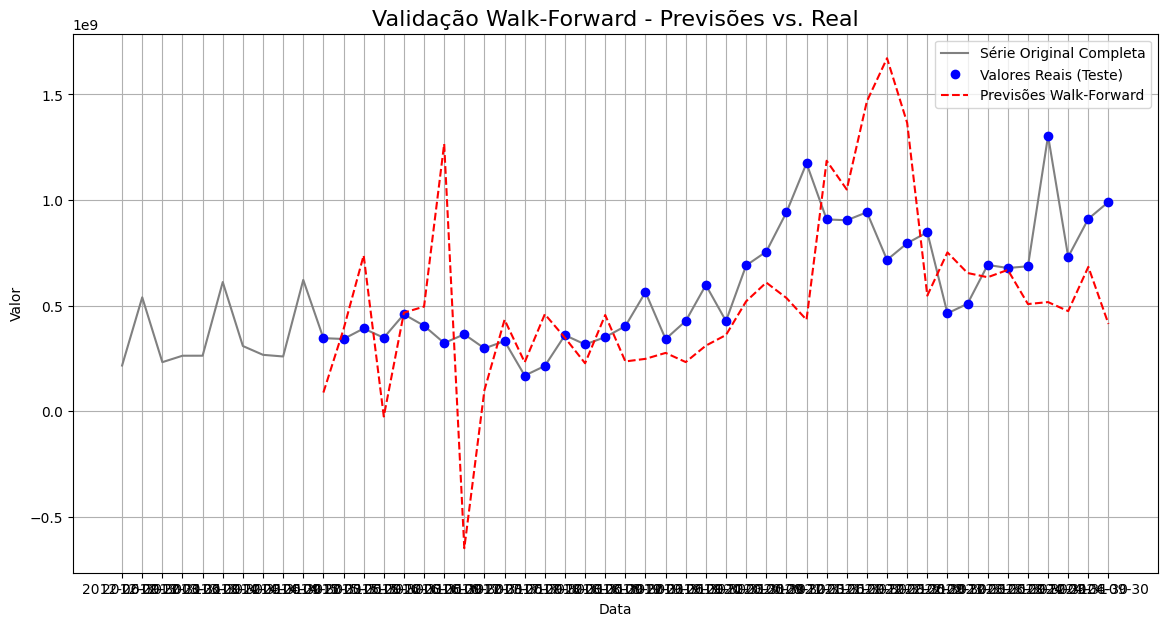


Empresa 21490 - Ordem ARIMA: [1, 1, 5]
Iniciando a validação Walk-Forward...
--- Dobra 1/8 ---
Tamanho do Treino: 10, Tamanho do Teste: 5
--- Dobra 2/8 ---
Tamanho do Treino: 15, Tamanho do Teste: 5
--- Dobra 3/8 ---
Tamanho do Treino: 20, Tamanho do Teste: 5
--- Dobra 4/8 ---
Tamanho do Treino: 25, Tamanho do Teste: 5
--- Dobra 5/8 ---
Tamanho do Treino: 30, Tamanho do Teste: 5
--- Dobra 6/8 ---
Tamanho do Treino: 35, Tamanho do Teste: 5
--- Dobra 7/8 ---
Tamanho do Treino: 40, Tamanho do Teste: 5
--- Dobra 8/8 ---
Tamanho do Treino: 45, Tamanho do Teste: 5
                               SARIMAX Results                                
Dep. Variable:                  21490   No. Observations:                   45
Model:                 ARIMA(1, 1, 5)   Log Likelihood                -906.939
Date:                Tue, 23 Sep 2025   AIC                           1857.877
Time:                        20:18:08   BIC                           1897.130
Sample:                    06-30-2012  

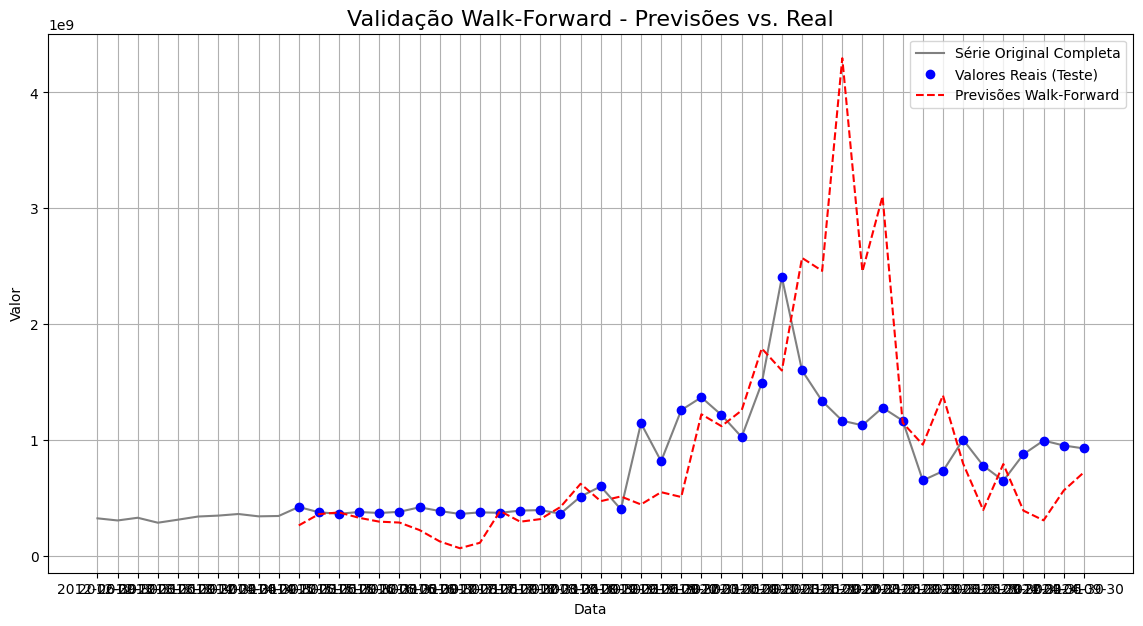

In [195]:
rmse_dict = {}
modelo_arimax = {}
for empresa in resultado_bruto.keys():
    print(f"\nEmpresa {empresa} - Ordem ARIMA: {resultado_bruto_comp_arima.loc[empresa].tolist()}")
    rmse_dict[empresa], modelo_arimax[empresa] = walk_forward_arimax(resultado_bruto[empresa][9:], ordem_arima=resultado_bruto_comp_arima.loc[empresa].tolist(), n_splits=8, input_exog=input_receita[empresa])


Empresa 2437 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward (One-Step-Ahead)...
Tamanho do treino inicial: 12, Número de previsões a fazer: 38
--- Prevendo passo 10/38 (Treinando com 21 observações) ---
--- Prevendo passo 20/38 (Treinando com 31 observações) ---
--- Prevendo passo 30/38 (Treinando com 41 observações) ---
--- Prevendo passo 38/38 (Treinando com 49 observações) ---

Validação Walk-Forward concluída.
RMSE Final (out-of-sample): 20080833202.5606


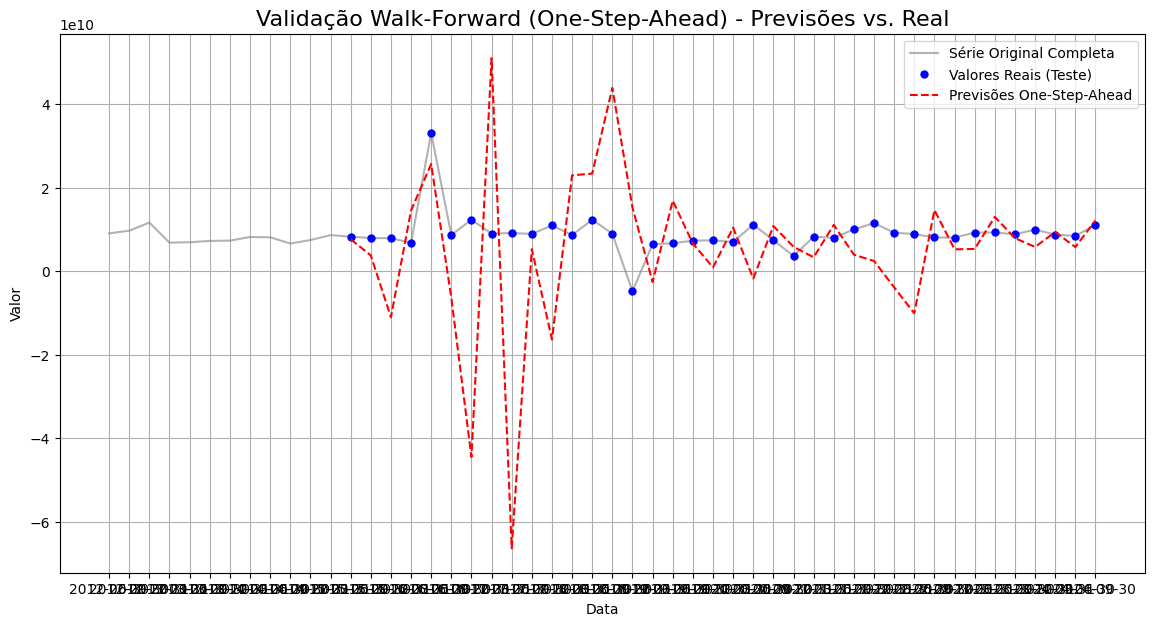


Empresa 18376 - Ordem ARIMA: [1, 1, 1]
Iniciando a validação Walk-Forward (One-Step-Ahead)...
Tamanho do treino inicial: 12, Número de previsões a fazer: 38
--- Prevendo passo 10/38 (Treinando com 21 observações) ---
--- Prevendo passo 20/38 (Treinando com 31 observações) ---
--- Prevendo passo 30/38 (Treinando com 41 observações) ---
--- Prevendo passo 38/38 (Treinando com 49 observações) ---

Validação Walk-Forward concluída.
RMSE Final (out-of-sample): 1424536450.5321


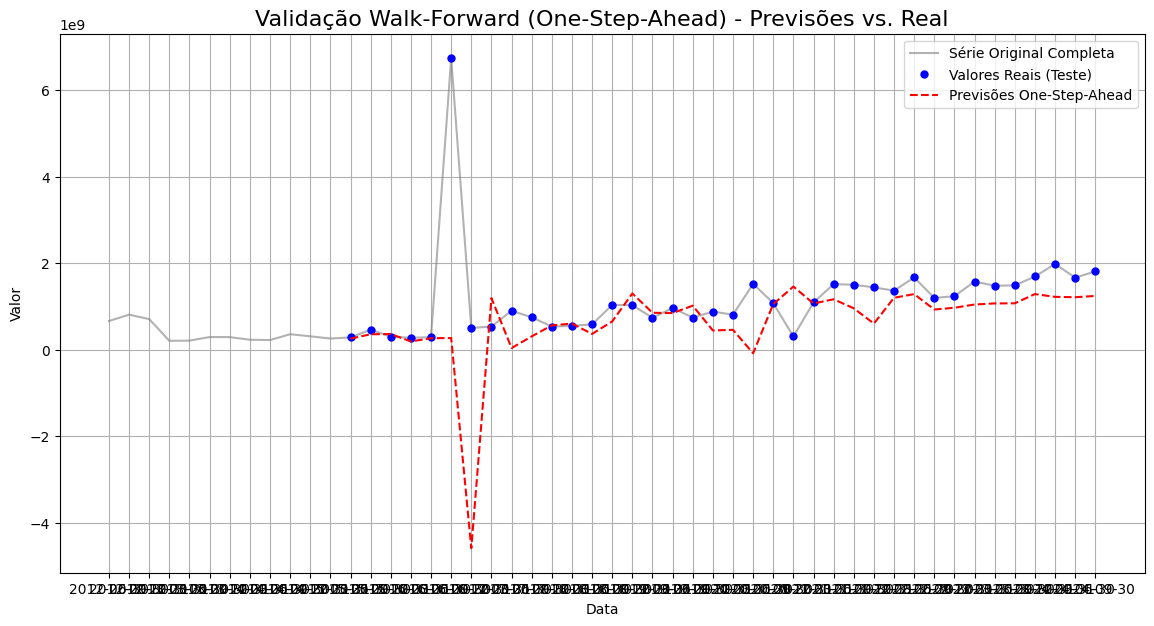


Empresa 20257 - Ordem ARIMA: [1, 1, 4]
Iniciando a validação Walk-Forward (One-Step-Ahead)...
Tamanho do treino inicial: 12, Número de previsões a fazer: 38
--- Prevendo passo 10/38 (Treinando com 21 observações) ---
--- Prevendo passo 20/38 (Treinando com 31 observações) ---
--- Prevendo passo 30/38 (Treinando com 41 observações) ---
--- Prevendo passo 38/38 (Treinando com 49 observações) ---

Validação Walk-Forward concluída.
RMSE Final (out-of-sample): 281210034.9507


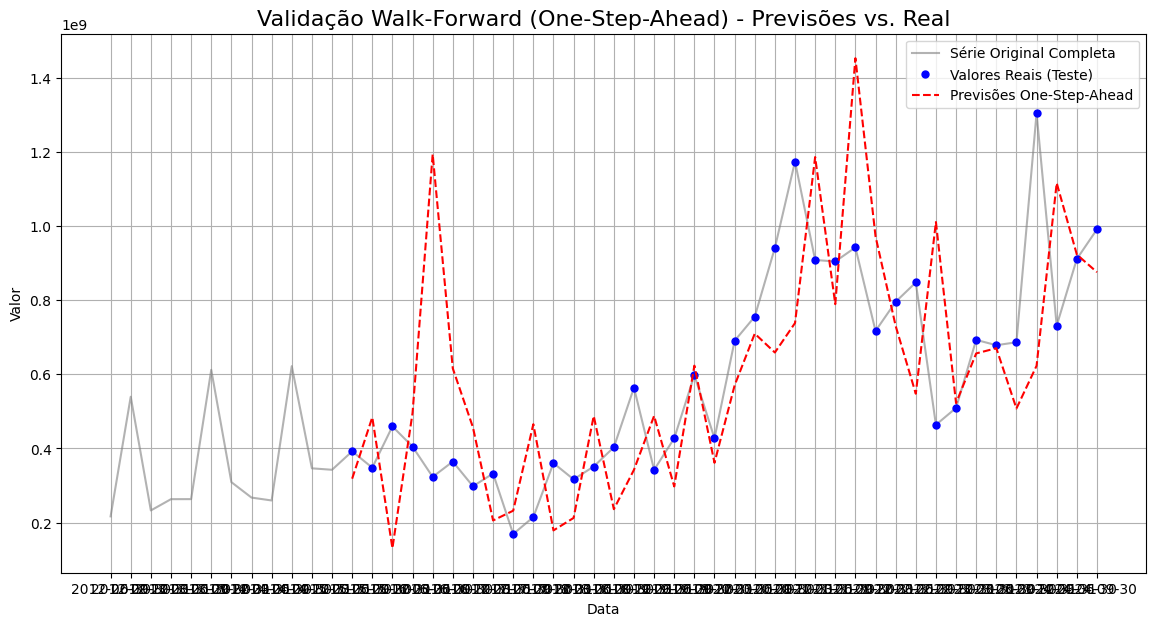


Empresa 21490 - Ordem ARIMA: [1, 1, 5]
Iniciando a validação Walk-Forward (One-Step-Ahead)...
Tamanho do treino inicial: 12, Número de previsões a fazer: 38
--- Prevendo passo 10/38 (Treinando com 21 observações) ---
--- Prevendo passo 20/38 (Treinando com 31 observações) ---
--- Prevendo passo 30/38 (Treinando com 41 observações) ---
--- Prevendo passo 38/38 (Treinando com 49 observações) ---

Validação Walk-Forward concluída.
RMSE Final (out-of-sample): 524059246.2613


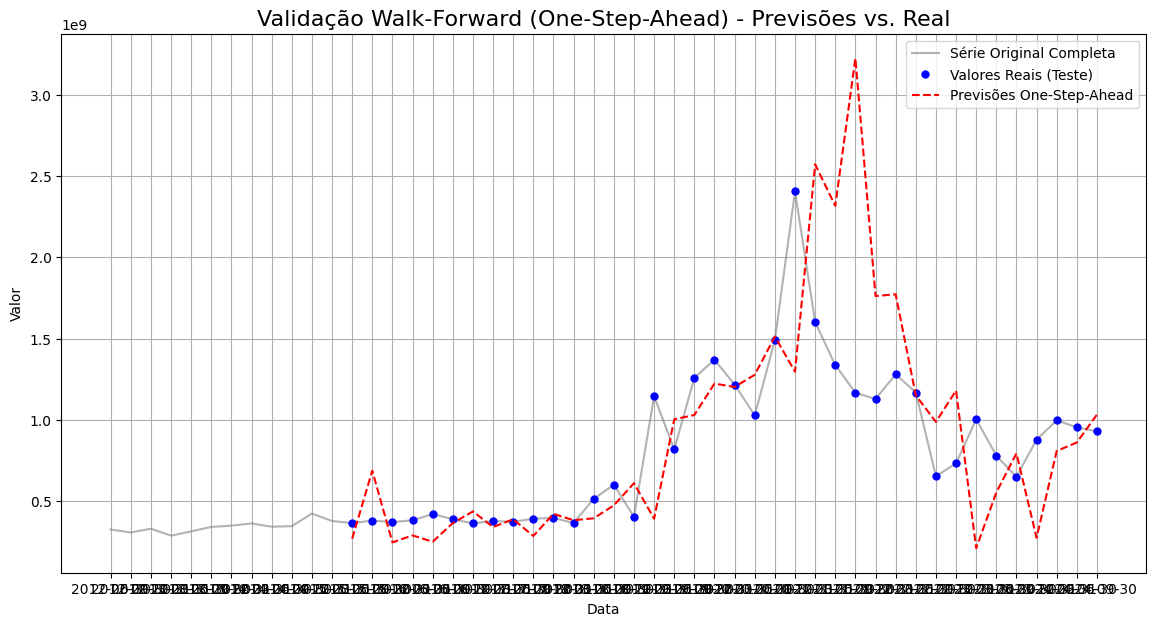

In [199]:
rmse_dict_one_step = {}
modelo_arimax_one_step = {}
for empresa in resultado_bruto.keys():
    print(f"\nEmpresa {empresa} - Ordem ARIMA: {resultado_bruto_comp_arima.loc[empresa].tolist()}")
    rmse_dict_one_step[empresa], modelo_arimax_one_step[empresa] = walk_forward_arimax_one_step(resultado_bruto[empresa][9:], ordem_arima=resultado_bruto_comp_arima.loc[empresa].tolist(), tamanho_treino_inicial=12, input_exog=input_receita[empresa])

In [164]:
rmse_dict

{2437: 35353464767.36079,
 18376: 1165582069.4447086,
 20257: 397118007.0375822,
 21490: 724928376.9261365}